This notebook runs data analysis on MCM-CB data from IBM Q, and is currently set up to analyze 4-qubit data from an MCM-CB experiment with 4-qubits, 1 MCM, and exhausive sampling of the MCM-CB subexperiments. 

In [1]:
import numpy as np
import pygsti
import pygsti.baseobjs.label as _lbl
import pygsti.modelmembers as mm
from pygsti.circuits import Circuit as _cir
import pygsti.algorithms.randomcircuit as _rc
from pygsti.tools import symplectic as _symp
import itertools
from pygsti.processors import CliffordCompilationRules as CCR

from matplotlib import pyplot as plt
from scipy.optimize import curve_fit

In [2]:
decay_form = lambda x, A, b: A*(b**x)

In [4]:
import pickle
with open('experiment_dict_ibm_osaka_05_18.pkl', 'rb') as f:
    exp_dict = pickle.load(f)

In [5]:
cs_by_pauli = exp_dict['cs']
tbs_by_pauli = exp_dict['tbs']
signs_by_pauli = exp_dict['signs']

In [6]:
ds = pygsti.io.read_dataset('05_18_test_mcmcb_ibm_osaka/data/dataset.txt')

Reading 05_18_test_mcmcb_ibm_osaka/data/dataset.txt: 100%


In [7]:
#measured_qubit is 40
qubit_labels = ('Q40','Q41','Q42','Q43')
n = len(qubit_labels)
availability = {'Gcphase':[(f'Q{i}',f'Q{i+1}') for i in range(40,43)]}
gate_names = [f'Gc{i}' for i in range(24)]+['Gcphase']#['Gc16', 'Gzr']+['Gcphase']
pspec = pygsti.processors.QubitProcessorSpec(n, gate_names, availability=availability, qubit_labels=qubit_labels) 

In [8]:
depths = [0,2,4,8,12]
num_randomizations = 30
num_meas = 1
num_unmeas = 3
measured_qs = qubit_labels[:num_meas]
unmeasured_qs = [q for q in qubit_labels if q not in measured_qs]

cycle = pygsti.circuits.Circuit([[pygsti.baseobjs.label.Label('Iz',('Q40'))],[pygsti.baseobjs.label.Label('Gc0',f'{i}') for i in qubit_labels]])

In [9]:
subsets = [('Q40',),('Q41',),('Q42',),('Q43',),('Q40','Q41'),('Q40','Q42'),('Q40','Q43'),
           ('Q41','Q42'), ('Q42','Q43'), ('Q41','Q43'), ('Q40','Q41','Q42'),('Q40','Q41','Q43'),
           ('Q41','Q42','Q43'),('Q40','Q42','Q43'),('Q40','Q41','Q42','Q43')]

In [10]:
def bootstrap_error(data_by_depth, depths, bootstrap_samples=100, n_shots=10000):
    rs = []
    for _ in range(bootstrap_samples):
        new_ps = {}
        for energies, d in zip(data_by_depth,depths):
            if type(energies) != list:
                energies = [energies]
            probs = [(e+1)/2 for e in energies]
            #sample probabilities from existing
            sampled_probs = np.random.choice(probs, len(energies))
            new_ps[d] = []
            for p in sampled_probs:
                outcomes = np.random.binomial(1, p, size=n_shots)
                #compute new  probs
                new_p = sum(outcomes)/len(outcomes)
                new_ps[d].append(new_p)
        
        mean_sps = [2*np.mean(new_ps[d])-1 for d in depths]
        result = curve_fit(decay_form, [d for d in depths if d != 1], mean_sps, p0=[1,0.99])[0]
        rs.append(result[-1])
    return np.std(rs)

def outcome_energy(outcome, measurement, sign, tbs):
    energy = 1
    for i,j,k in zip(outcome,measurement,tbs):
        if j == 'Z' and (i != k):
            energy = -1*energy
    return sign*energy

def avg_energy(cd, measurement, sign, tbs):
    energy = 0
    total = sum(cd.values())
    for i,count in cd.items():
        out_eng = outcome_energy(i[0],measurement,sign, tbs)
        energy += count * out_eng    
    return energy / total

def ignore_mcm_results(count_dict):
    new_dict = {}
    for key, count in count_dict.items():
        new_key = (key[-1],)
        if new_key in new_dict:
            new_dict[new_key] += count
        else:
            new_dict[new_key] = count
    return new_dict

decay_form = lambda x, A, b: A*(b**x)

def avg_energy_sign_mod(cd, measurement, sign, tbs):
    energy = 0
    total = sum(cd.values())
    for i,count in cd.items():
        if len(i)>1:
            #is this right tbs
            mcm_results = [0 if b=='p0' else 1 for b in i[:-1]]
            mcm_tbs = [0 if tbs[j]=='0' else 1 for j in range(len(mcm_results))]
            mcm_adjusted_results = np.logical_xor(mcm_results, mcm_tbs)
            this_sign = (-1)**(sum(mcm_adjusted_results)%2)
        else:
            this_sign=1
        #there's no need to use odd depths
        #but if you do, and you're toggling the MCM Pauli, you need to change the final measured Pauli
        if len(i)%2==0 and measurement[0] == 'Z':
            measurement[0]='I'
        if measurement[0]=='I' and len(i)%2==0:
            measurement[0]='Z'
        out_eng = outcome_energy(i[-1],measurement,sign, tbs[-len(measurement):])*this_sign
        energy += count * out_eng    
    return energy / total

def compute_eigenvalue_decays(data_by_pauli, cs_by_pauli, signs_by_pauli, tbs_by_pauli):
    energies_by_pauli = {}
    circuit_energies_by_pauli = {}
    for pauli, ds_by_d in data_by_pauli.items():
        circuits = cs_by_pauli[pauli]
        signs = signs_by_pauli[pauli]
        tbs = tbs_by_pauli[pauli]
        energies = []
        #transform into z type Pauli
        meas_pauli = [p if p in ['I', 'Z'] else 'Z' for p in pauli]
        circuit_energies_by_pauli[pauli] = []
        avg_energies = []
        for clist, signlist, ds in zip(circuits, signs, ds_by_d):
            circuit_energies = []
            
            for c, sign in zip(clist,signlist):
                dsrow = ds[c]
                cd = ignore_mcm_results(dsrow.to_dict())
                energy = avg_energy(cd, meas_pauli, sign)
                circuit_energies.append(energy)
            avg_energies.append(np.mean(circuit_energies))
            circuit_energies_by_pauli[pauli].append(circuit_energies)
        energies_by_pauli[pauli] = avg_energies
            
    return energies_by_pauli, circuit_energies_by_pauli

def compute_toggle_decays(data_by_pauli, cs_by_pauli, signs_by_pauli, tbs_by_pauli):
    #compute pauli measurement results, use MCM results
    energies_by_pauli = {}
    circuit_energies_by_pauli = {}
    for pauli, ds_by_d in data_by_pauli.items():
        circuits = cs_by_pauli[pauli]
        signs = signs_by_pauli[pauli]
        energies = []
        #transform into z type Pauli
        circuit_energies_by_pauli[pauli] = []
        meas_pauli = [p if p in ['I', 'Z'] else 'Z' for p in pauli]
        avg_energies = []
        for clist, signlist, ds in zip(circuits, signs, ds_by_d):
            circuit_energies = []
            
            for c, sign in zip(clist,signlist):
                meas_pauli = [p if p in ['I', 'Z'] else 'Z' for p in pauli]
                dsrow = ds[c]
                cd = ignore_mcm_results(dsrow.to_dict())
                energy = avg_energy_sign_mod(dsrow.to_dict(), meas_pauli, sign)
                circuit_energies.append(energy)
            avg_energies.append(np.mean(circuit_energies))
            circuit_energies_by_pauli[pauli].append(circuit_energies)
        energies_by_pauli[pauli] = avg_energies
    return energies_by_pauli, circuit_energies_by_pauli

def determine_new_sign(c, tbs, measured_qubits, pspec, meas_pauli):
    #this would be better done while generating circuits
    n = c.width
    #remove measured qubit
    rest_c = c.copy(editable=True)
    rest_c.delete_lines(measured_qubits)
    #simplectic simulation TODO
    init_stab, init_phase = _symp.prep_stabilizer_state(len(rest_c.line_labels))
    s_c, p_c = _symp.symplectic_rep_of_clifford_circuit(rest_c, pspec=pspec.subset(gate_names_to_include='all', qubit_labels_to_keep=rest_c.line_labels)) 
    s_state, p_state = _symp.compose_cliffords(s1 = init_stab, p1 = init_phase, s2 = s_c, p2 = p_c)
    #measure at end
    meas = _rc._measure(s_state, p_state) #list of 0 and 1 outcomes
    meas_to_count = [0 if p=='I' else 1 for p in meas_pauli][len(measured_qubits):]
    new_sign = (-1)**(np.dot(meas, meas_to_count))
    #now we have the sign
    #tbs already accounted for via this analysis
    new_tbs = tbs[:-n]+'0'*n
    return new_sign, new_tbs

In [11]:
def compute_required_paulis(subset, meas_qubits):
    subset_unmeas = [q for q in subset if q not in meas_qubits]
    num_unmeas=len(qubit_labels)-1
    #num_unmeas = len([q for q in subset if q not in meas_qubits])
    unmeas_subset_paulis = list(itertools.product(['I','X','Y','Z'], repeat=num_unmeas))
    unmeas_paulis = [tuple(p[j-1] if qubit_labels[j] in subset_unmeas else 'I'for j in range(1,len(qubit_labels))) for p in unmeas_subset_paulis]
    if 'Q40' in subset:
        paulis = [('Z',)+p for p in unmeas_paulis]+[('I',)+p for p in unmeas_paulis]
    else:
        paulis = [('I',)+p for p in unmeas_paulis]
    return list(set(paulis))

In [12]:
#iterate through the experiments
circuit_energies_by_pauli = {}
circuit_alt_energies_by_pauli = {}
energies_by_pauli = {}
missing = 0
for p in cs_by_pauli.keys():
    clists = cs_by_pauli[p]
    tbslists = tbs_by_pauli[p]
    signlists = signs_by_pauli[p]
    circuit_energies_by_pauli[p] = []
    circuit_alt_energies_by_pauli[p] = []
    meas_pauli = [q if q in ['I', 'Z'] else 'Z' for q in p]
    print(p)
    avg_energies = []
    
        
    for cs, tbss, signs in zip(clists, tbslists, signlists):
        circuit_energies = []
        circuit_alt_energies = []
        #print(tbss)
        for c, tbs, sign in zip(cs, tbss, signs):
            if c in ds:
                counts = ds[c].counts
                cd = ignore_mcm_results(counts)
                #print(c, cd, model.probabilities(c),tbs, sign, meas_pauli)
                #print('TBS:'+tbs, tbs[-(num_meas+num_unmeas):])
                energy = avg_energy(cd, meas_pauli, sign,tbs[-(num_meas+num_unmeas):])
                #print(p, energy)
                circuit_energies.append(energy)

                #toggle computation
                energy = avg_energy_sign_mod(counts, meas_pauli, sign, tbs)
                circuit_alt_energies.append(energy)
                #print(energy)
            else:
                missing += 1
        avg_energies.append(np.mean(circuit_energies))
        circuit_energies_by_pauli[p].append(circuit_energies)
        circuit_alt_energies_by_pauli[p].append(circuit_alt_energies)
    energies_by_pauli[p] = avg_energies

    

('Z', 'I', 'I', 'I')
('Z', 'I', 'I', 'X')
('Z', 'I', 'I', 'Y')
('Z', 'I', 'I', 'Z')
('Z', 'I', 'X', 'I')
('Z', 'I', 'X', 'X')
('Z', 'I', 'X', 'Y')
('Z', 'I', 'X', 'Z')
('Z', 'I', 'Y', 'I')
('Z', 'I', 'Y', 'X')
('Z', 'I', 'Y', 'Y')
('Z', 'I', 'Y', 'Z')
('Z', 'I', 'Z', 'I')
('Z', 'I', 'Z', 'X')
('Z', 'I', 'Z', 'Y')
('Z', 'I', 'Z', 'Z')
('Z', 'X', 'I', 'I')
('Z', 'X', 'I', 'X')
('Z', 'X', 'I', 'Y')
('Z', 'X', 'I', 'Z')
('Z', 'X', 'X', 'I')
('Z', 'X', 'X', 'X')
('Z', 'X', 'X', 'Y')
('Z', 'X', 'X', 'Z')
('Z', 'X', 'Y', 'I')
('Z', 'X', 'Y', 'X')
('Z', 'X', 'Y', 'Y')
('Z', 'X', 'Y', 'Z')
('Z', 'X', 'Z', 'I')
('Z', 'X', 'Z', 'X')
('Z', 'X', 'Z', 'Y')
('Z', 'X', 'Z', 'Z')
('Z', 'Y', 'I', 'I')
('Z', 'Y', 'I', 'X')
('Z', 'Y', 'I', 'Y')
('Z', 'Y', 'I', 'Z')
('Z', 'Y', 'X', 'I')
('Z', 'Y', 'X', 'X')
('Z', 'Y', 'X', 'Y')
('Z', 'Y', 'X', 'Z')
('Z', 'Y', 'Y', 'I')
('Z', 'Y', 'Y', 'X')
('Z', 'Y', 'Y', 'Y')
('Z', 'Y', 'Y', 'Z')
('Z', 'Y', 'Z', 'I')
('Z', 'Y', 'Z', 'X')
('Z', 'Y', 'Z', 'Y')
('Z', 'Y', 'Z

In [13]:
for p in cs_by_pauli.keys():
    clists = cs_by_pauli[p]
    tbslists = tbs_by_pauli[p]
    signlists = signs_by_pauli[p]

    meas_pauli = ['I']+[q if q in ['I', 'Z'] else 'Z' for q in p][1:]
    avg_energies = []
    
    new_p = tuple(['I']+list(p[1:]))
    print(new_p)
    circuit_energies_by_pauli[new_p] = []
    circuit_alt_energies_by_pauli[new_p] = []
    
    for cs, tbss, signs in zip(clists, tbslists, signlists):
        circuit_energies = []
        circuit_alt_energies = []
        #print(tbss)
        for c, tbs, sign in zip(cs, tbss, signs):
            if c in ds:
                new_sign, new_tbs = determine_new_sign(c, tbs, ['Q40'], pspec, meas_pauli)
                counts = ds[c].counts
                cd = ignore_mcm_results(counts)
                #print(c, cd, model.probabilities(c),tbs, sign, meas_pauli)
                #print('TBS:'+tbs, tbs[-(num_meas+num_unmeas):])
                energy = avg_energy(cd, meas_pauli, new_sign,new_tbs[-(num_meas+num_unmeas):])
                #print(meas_pauli, energy)
                circuit_energies.append(energy)

                #toggle computation
                energy = avg_energy_sign_mod(counts, meas_pauli, new_sign, new_tbs)
                circuit_alt_energies.append(energy)
                #print(energy)

                
            else:
                missing += 1
        avg_energies.append(np.mean(circuit_energies))
        circuit_energies_by_pauli[new_p].append(circuit_energies)
        circuit_alt_energies_by_pauli[new_p].append(circuit_alt_energies)
    energies_by_pauli[new_p] = avg_energies

('I', 'I', 'I', 'I')
('I', 'I', 'I', 'X')
('I', 'I', 'I', 'Y')
('I', 'I', 'I', 'Z')
('I', 'I', 'X', 'I')
('I', 'I', 'X', 'X')
('I', 'I', 'X', 'Y')
('I', 'I', 'X', 'Z')
('I', 'I', 'Y', 'I')
('I', 'I', 'Y', 'X')
('I', 'I', 'Y', 'Y')
('I', 'I', 'Y', 'Z')
('I', 'I', 'Z', 'I')
('I', 'I', 'Z', 'X')
('I', 'I', 'Z', 'Y')
('I', 'I', 'Z', 'Z')
('I', 'X', 'I', 'I')
('I', 'X', 'I', 'X')
('I', 'X', 'I', 'Y')
('I', 'X', 'I', 'Z')
('I', 'X', 'X', 'I')
('I', 'X', 'X', 'X')
('I', 'X', 'X', 'Y')
('I', 'X', 'X', 'Z')
('I', 'X', 'Y', 'I')
('I', 'X', 'Y', 'X')
('I', 'X', 'Y', 'Y')
('I', 'X', 'Y', 'Z')
('I', 'X', 'Z', 'I')
('I', 'X', 'Z', 'X')
('I', 'X', 'Z', 'Y')
('I', 'X', 'Z', 'Z')
('I', 'Y', 'I', 'I')
('I', 'Y', 'I', 'X')
('I', 'Y', 'I', 'Y')
('I', 'Y', 'I', 'Z')
('I', 'Y', 'X', 'I')
('I', 'Y', 'X', 'X')
('I', 'Y', 'X', 'Y')
('I', 'Y', 'X', 'Z')
('I', 'Y', 'Y', 'I')
('I', 'Y', 'Y', 'X')
('I', 'Y', 'Y', 'Y')
('I', 'Y', 'Y', 'Z')
('I', 'Y', 'Z', 'I')
('I', 'Y', 'Z', 'X')
('I', 'Y', 'Z', 'Y')
('I', 'Y', 'Z

('Z', 'I', 'I', 'I')
[0.93557935 0.96371245] 0.004277095456900269


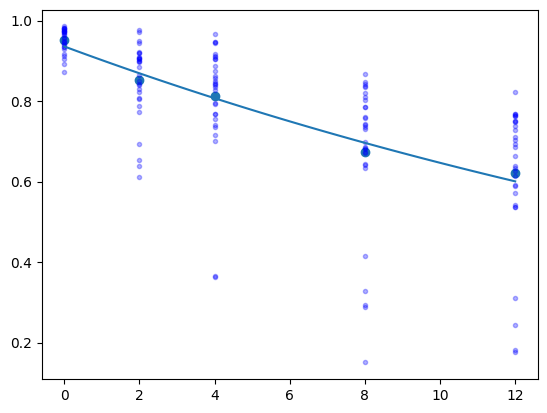

('Z', 'I', 'I', 'X')
[0.91800203 0.89415911] 0.009558518494273896


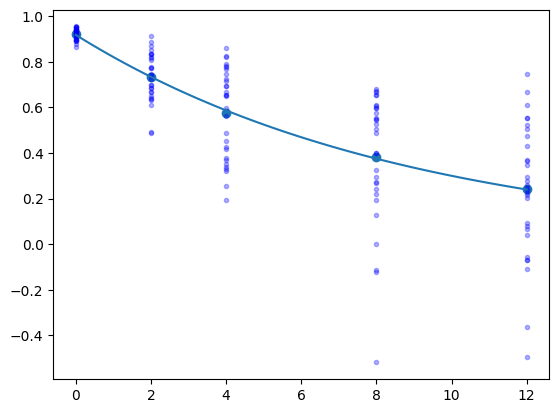

('Z', 'I', 'I', 'Y')
[0.91062558 0.90906706] 0.011385892783192733


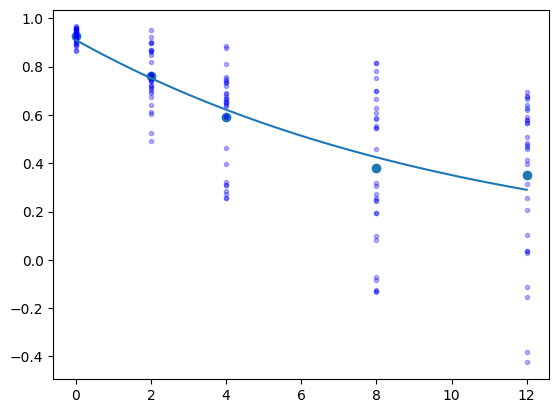

('Z', 'I', 'I', 'Z')
[0.88952801 0.95636421] 0.003557795272912126


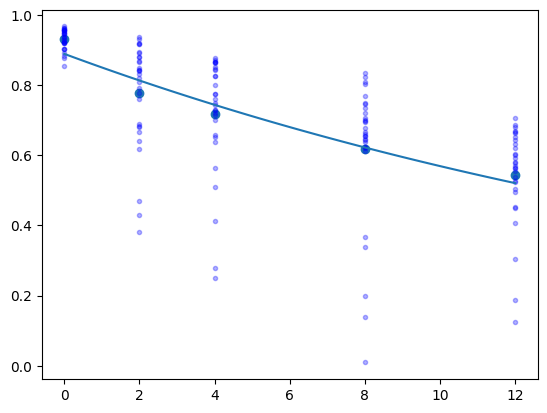

('Z', 'I', 'X', 'I')
[0.96943765 0.82485842] 0.012849811631393822


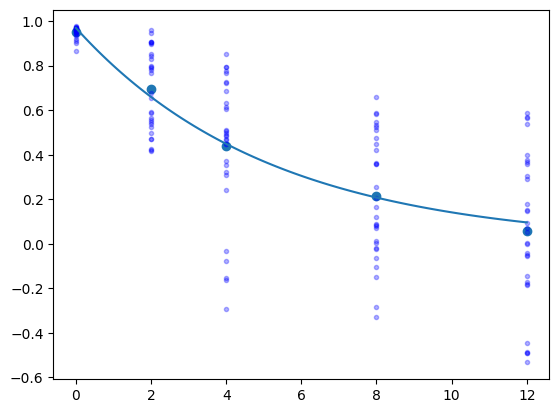

('Z', 'I', 'X', 'X')
[0.91398944 0.86464687] 0.014973965685501316


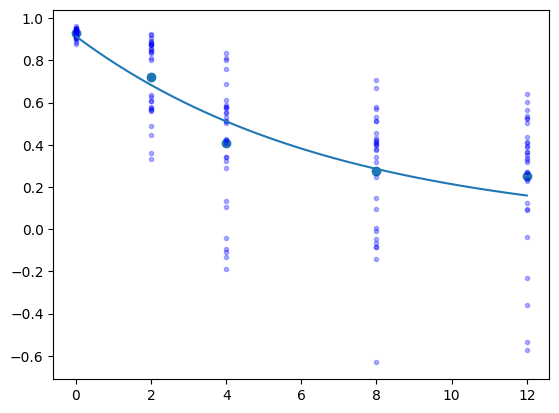

('Z', 'I', 'X', 'Y')
[0.91009286 0.8694242 ] 0.015343523678820603


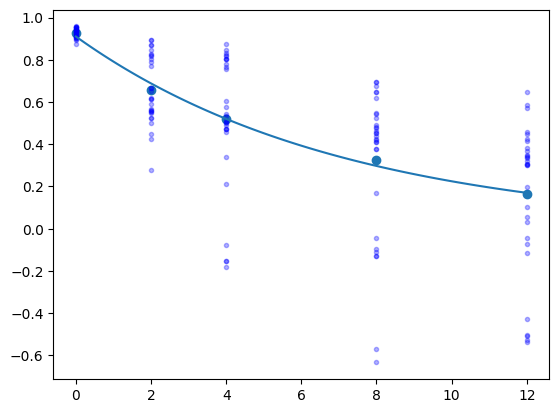

('Z', 'I', 'X', 'Z')
[0.9309527  0.81133569] 0.02146829088690681


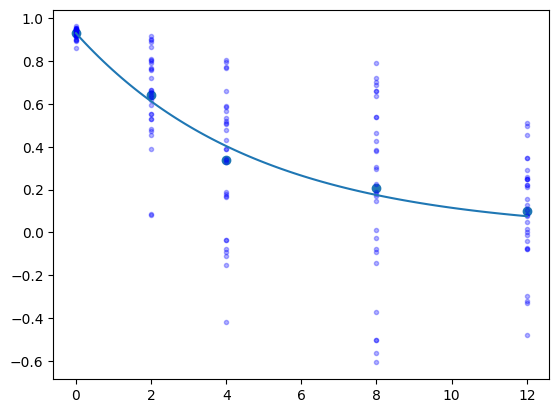

('Z', 'I', 'Y', 'I')
[0.94787486 0.82849482] 0.01643295863677499


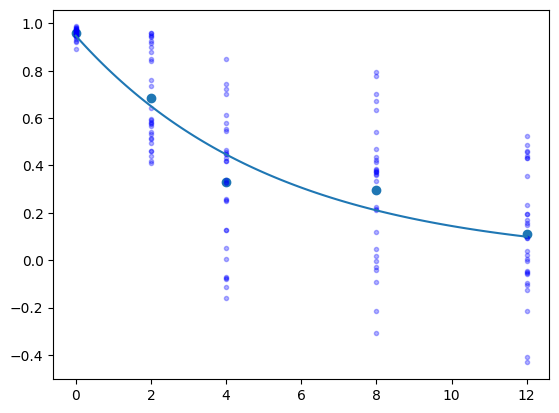

('Z', 'I', 'Y', 'X')
[0.94852456 0.83498961] 0.015632158866282216


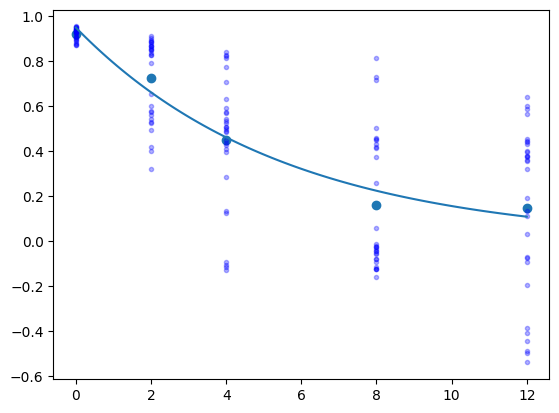

('Z', 'I', 'Y', 'Y')
[0.92169919 0.85455123] 0.016517120110088525


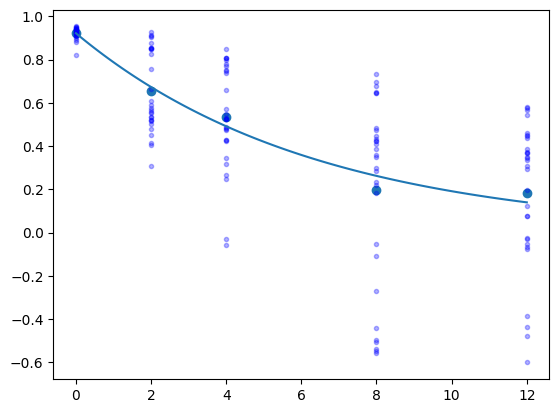

('Z', 'I', 'Y', 'Z')
[0.94466014 0.83386723] 0.014801609085295481


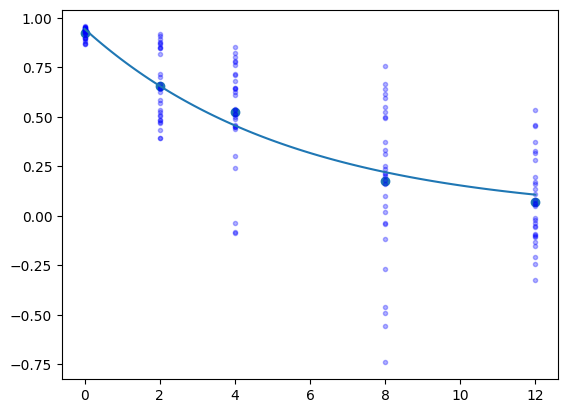

('Z', 'I', 'Z', 'I')
[0.92540322 0.97294126] 0.0031012604919953483


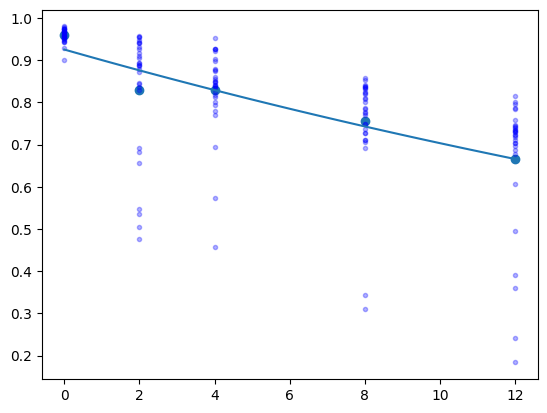

('Z', 'I', 'Z', 'X')
[0.91268199 0.91167616] 0.009086542811046813


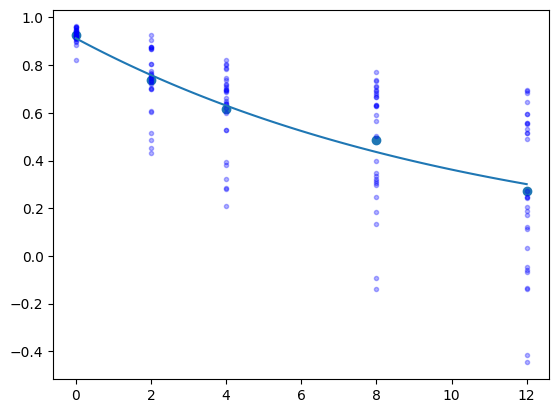

('Z', 'I', 'Z', 'Y')
[0.94559197 0.8977073 ] 0.008560396221256202


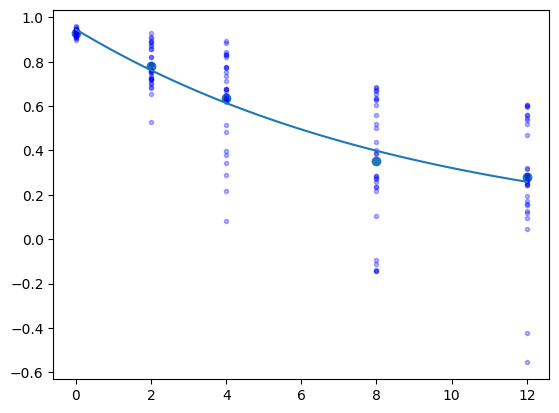

('Z', 'I', 'Z', 'Z')
[0.91790351 0.95895235] 0.0036807114920098007


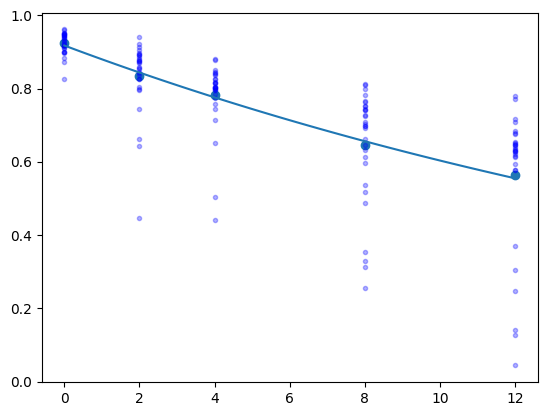

('Z', 'X', 'I', 'I')
[0.85888031 0.86969925] 0.015544308257667241


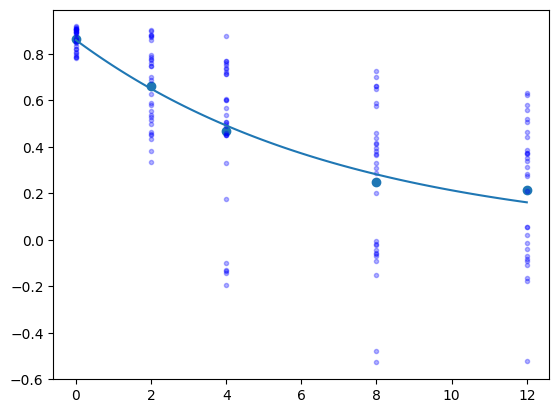

('Z', 'X', 'I', 'X')
[0.83126105 0.84082127] 0.013543923577394614


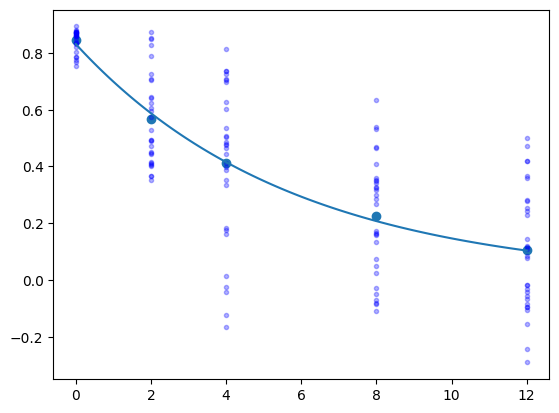

('Z', 'X', 'I', 'Y')
[0.85604336 0.81484433] 0.01775024135737945


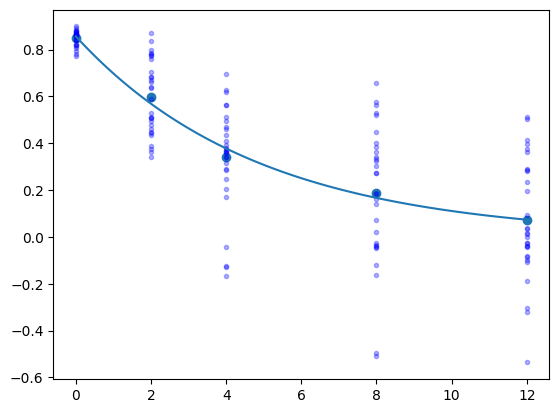

('Z', 'X', 'I', 'Z')
[0.83647301 0.87310406] 0.012065946804612121


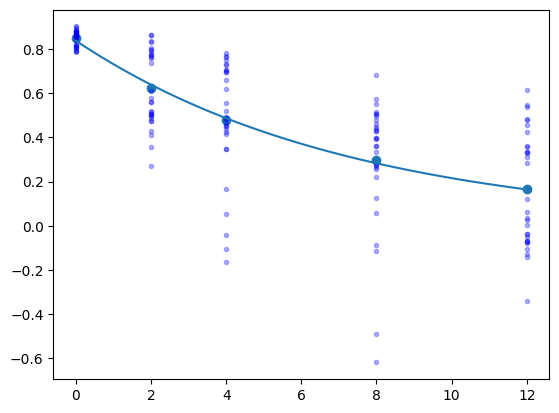

('Z', 'X', 'X', 'I')
[0.85868019 0.89445678] 0.008298659780307928


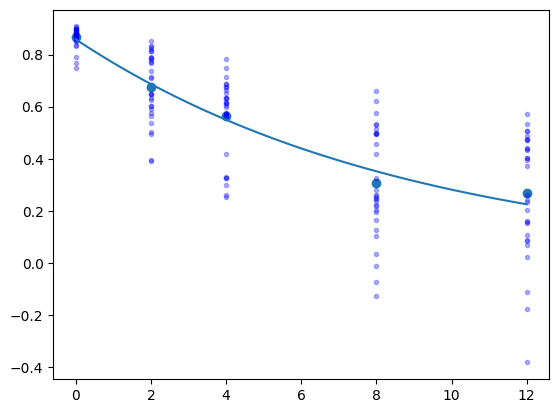

('Z', 'X', 'X', 'X')
[0.84973994 0.94307421] 0.0037724640070504593


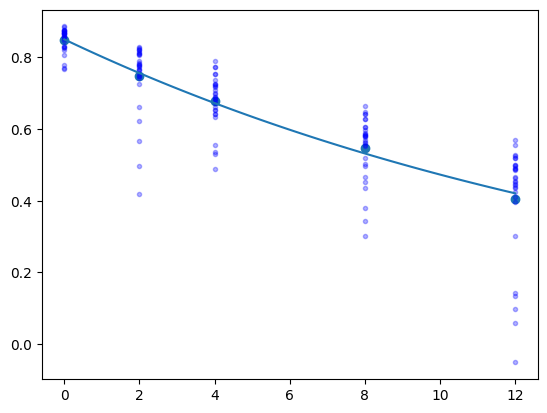

('Z', 'X', 'X', 'Y')
[0.83042595 0.94175626] 0.004536572873397098


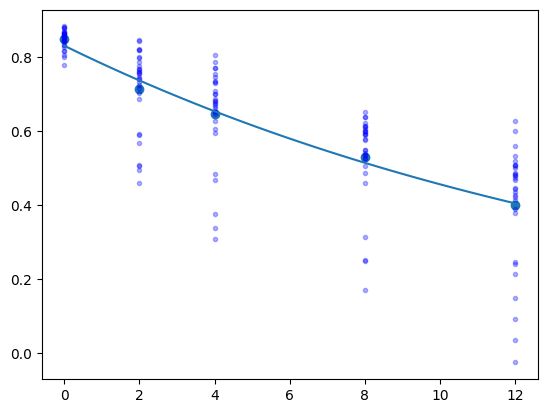

('Z', 'X', 'X', 'Z')
[0.83165153 0.9070434 ] 0.0074667178494045175


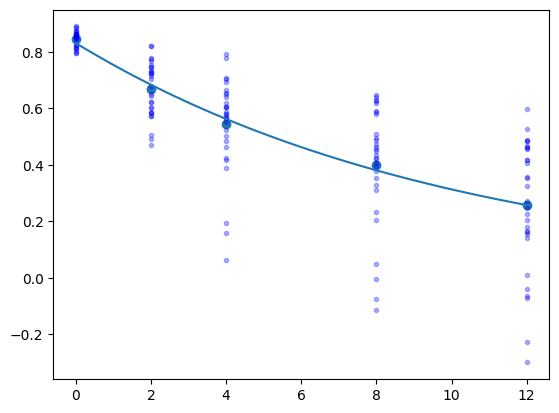

('Z', 'X', 'Y', 'I')
[0.89090791 0.89021757] 0.008519266051842476


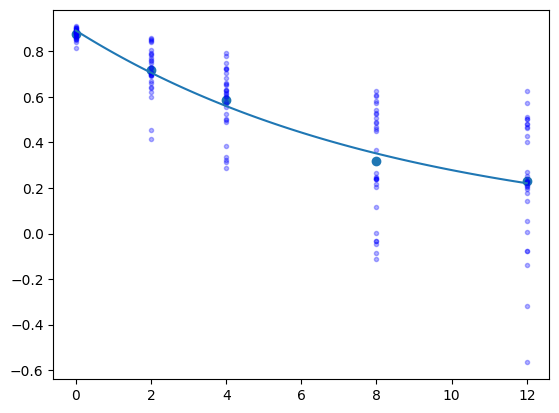

('Z', 'X', 'Y', 'X')
[0.82369922 0.94296541] 0.0040321166588212914


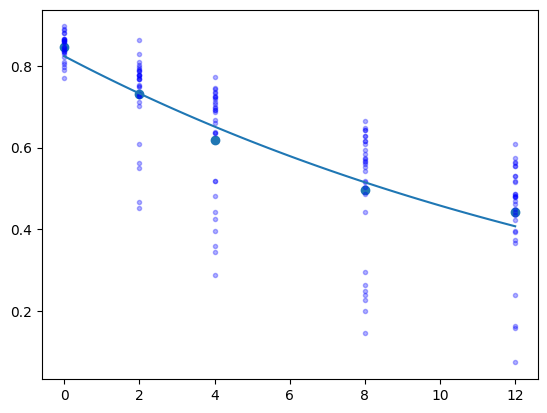

('Z', 'X', 'Y', 'Y')
[0.84748689 0.94347465] 0.004770212534650734


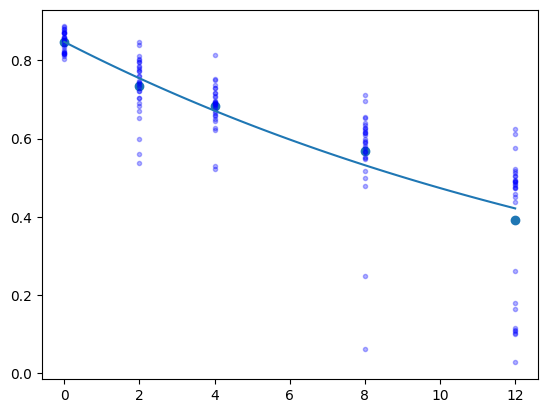

('Z', 'X', 'Y', 'Z')
[0.83904184 0.91414859] 0.0064597167750682395


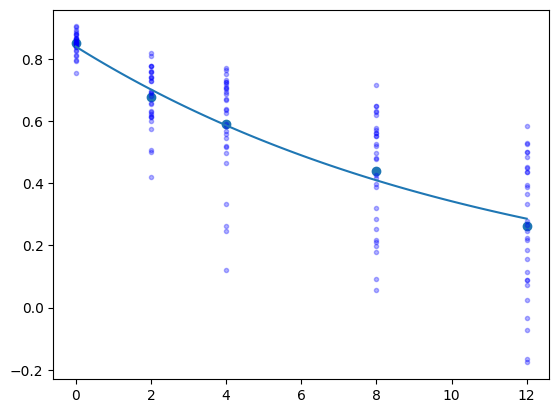

('Z', 'X', 'Z', 'I')
[0.83874949 0.87750703] 0.01764638435290471


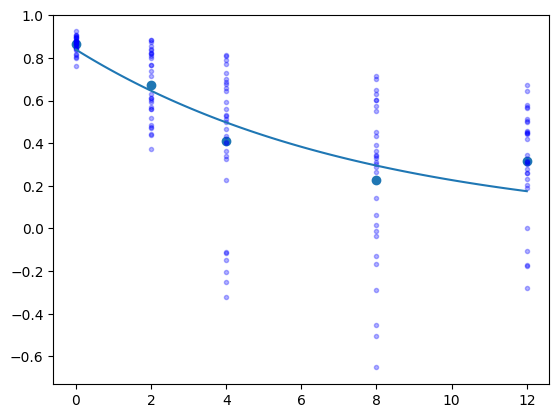

('Z', 'X', 'Z', 'X')
[0.82875167 0.83288307] 0.012837545994491644


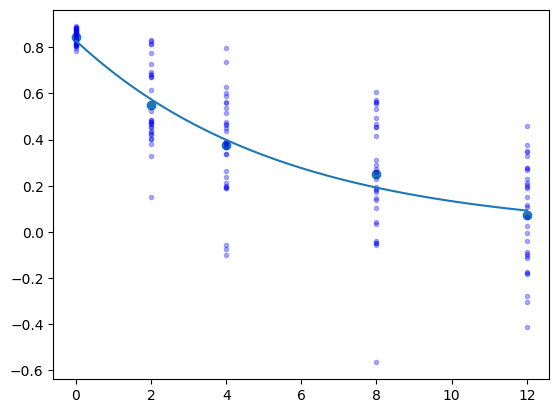

('Z', 'X', 'Z', 'Y')
[0.83116086 0.81622358] 0.018112727937392464


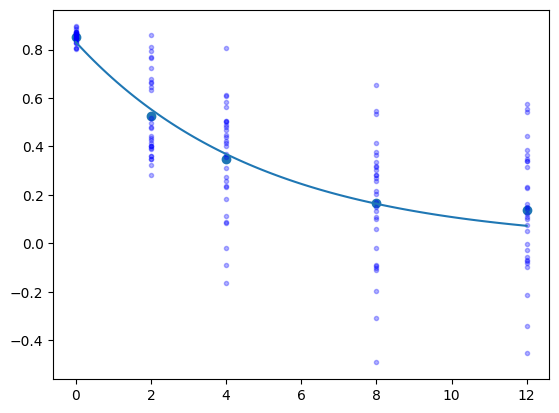

('Z', 'X', 'Z', 'Z')
[0.79479881 0.87179684] 0.012867142429427771


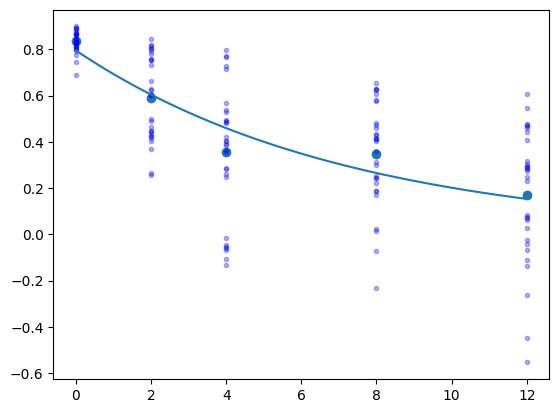

('Z', 'Y', 'I', 'I')
[0.88409914 0.86311502] 0.011780975367382084


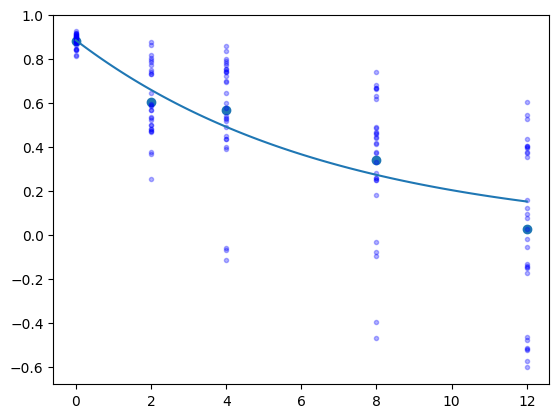

('Z', 'Y', 'I', 'X')
[0.84813933 0.8063214 ] 0.016862195496075292


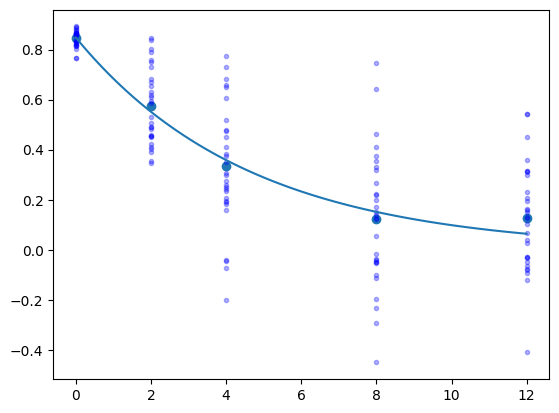

('Z', 'Y', 'I', 'Y')
[0.85019888 0.82035159] 0.0140803803108287


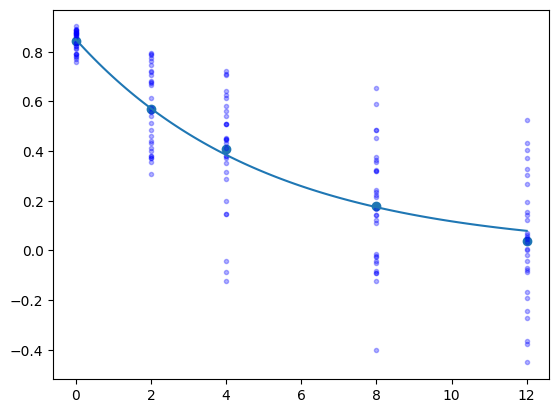

('Z', 'Y', 'I', 'Z')
[0.83211002 0.8549907 ] 0.015105996053888253


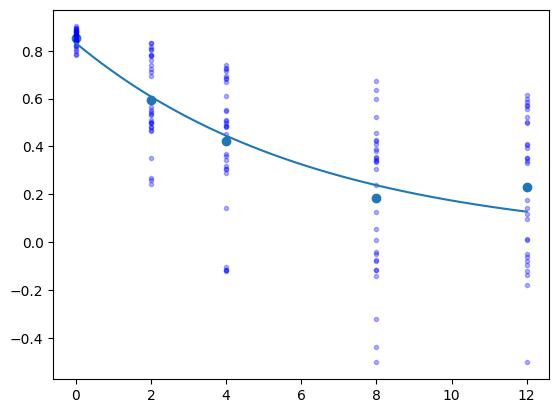

('Z', 'Y', 'X', 'I')
[0.84941198 0.90251583] 0.008338086122996784


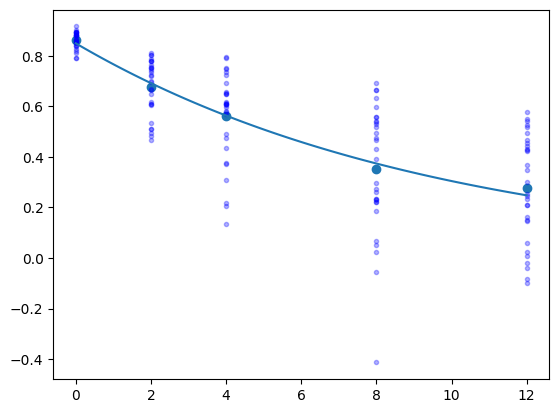

('Z', 'Y', 'X', 'X')
[0.82332395 0.94945243] 0.00339690438941817


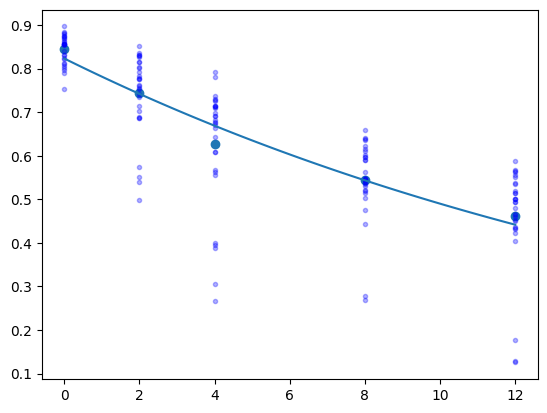

('Z', 'Y', 'X', 'Y')
[0.84315405 0.94263365] 0.00427877518187232


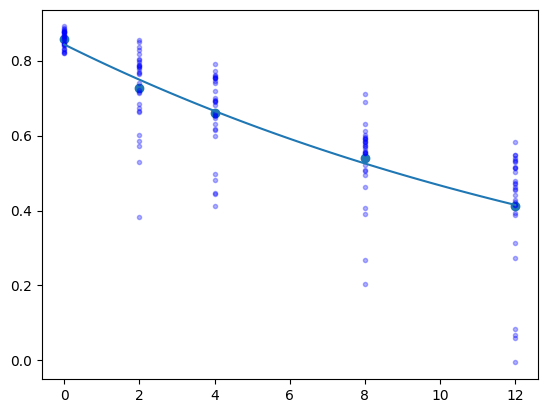

('Z', 'Y', 'X', 'Z')
[0.83207778 0.90269543] 0.007785230955611296


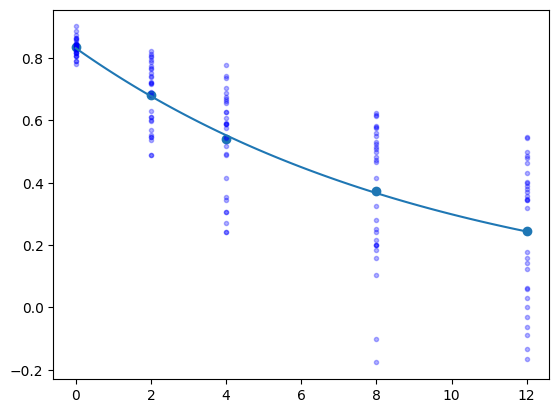

('Z', 'Y', 'Y', 'I')
[0.86758965 0.90042263] 0.007861357365741183


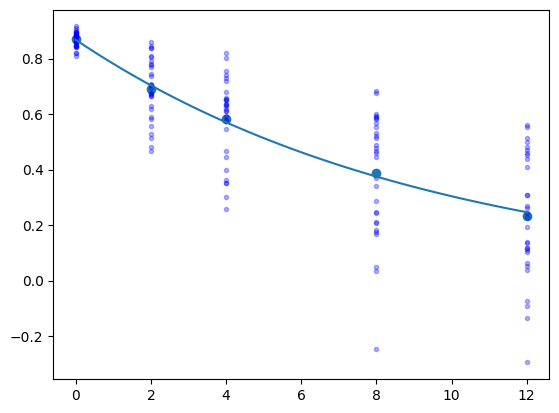

('Z', 'Y', 'Y', 'X')
[0.85638535 0.93655205] 0.003913877015962361


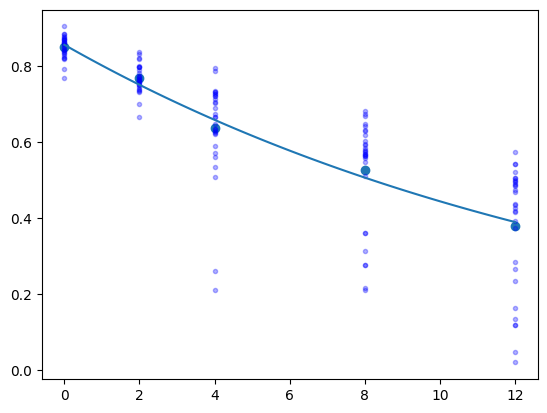

('Z', 'Y', 'Y', 'Y')
[0.81369746 0.94449417] 0.005003003950185283


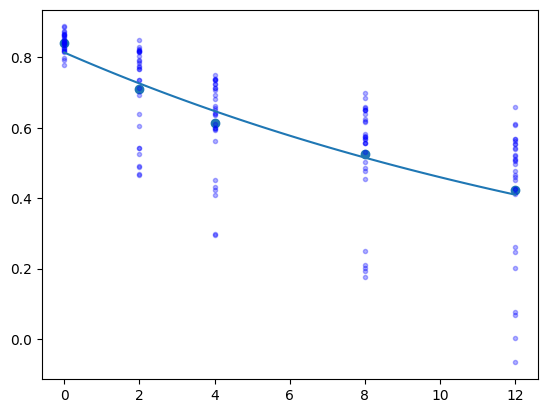

('Z', 'Y', 'Y', 'Z')
[0.86422298 0.88976283] 0.008933877489093857


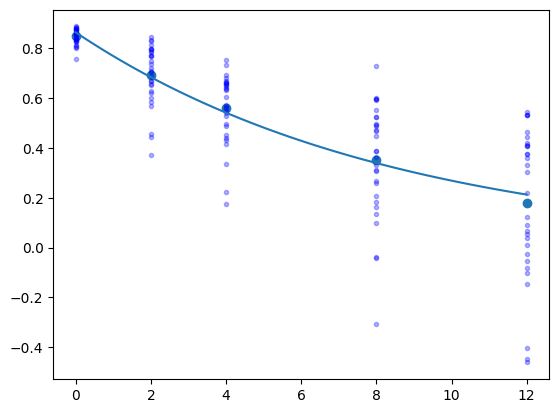

('Z', 'Y', 'Z', 'I')
[0.8841054  0.82606633] 0.01827483777763555


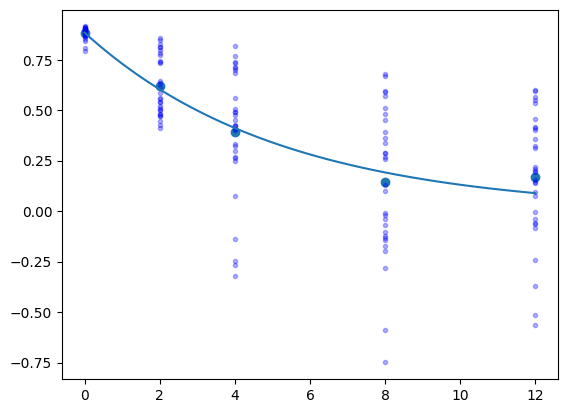

('Z', 'Y', 'Z', 'X')
[0.86910235 0.78471568] 0.014627064525836612


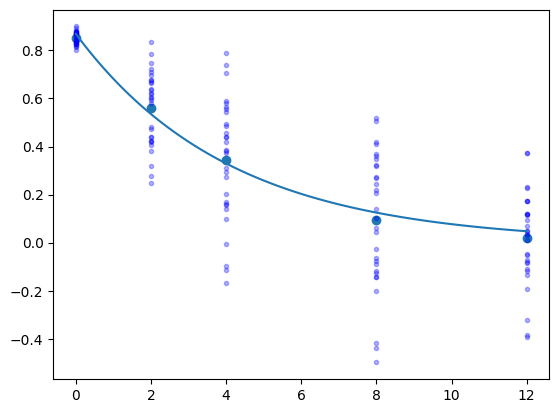

('Z', 'Y', 'Z', 'Y')
[0.84694318 0.82071228] 0.014456332060160556


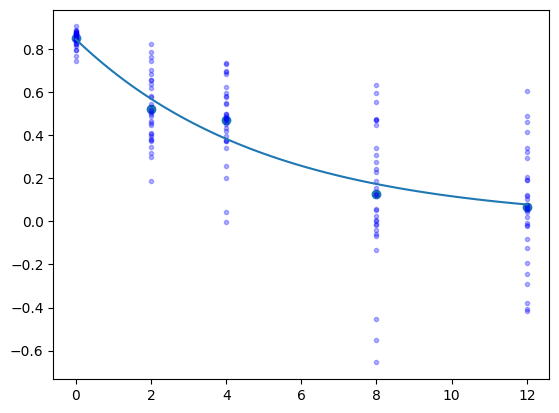

('Z', 'Y', 'Z', 'Z')
[0.85027425 0.85305305] 0.01559064795713421


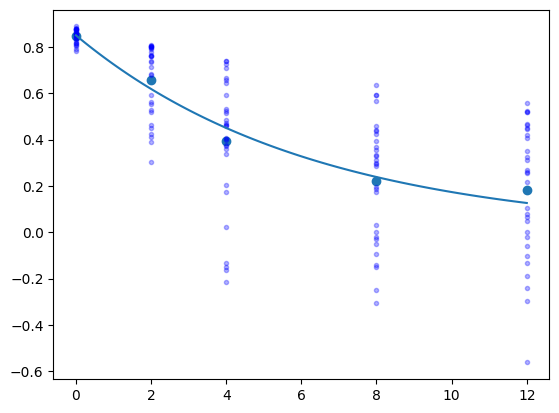

('Z', 'Z', 'I', 'I')
[0.86858204 0.9449811 ] 0.004560578235785158


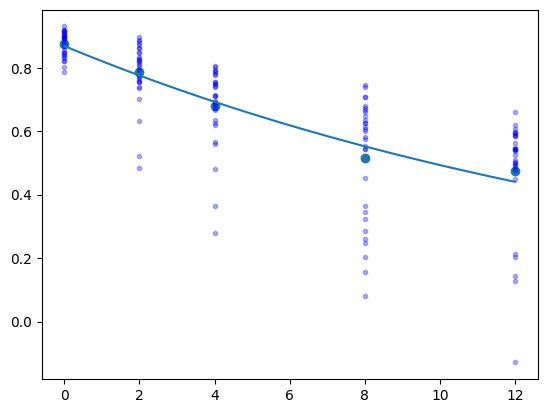

('Z', 'Z', 'I', 'X')
[0.86661375 0.89301465] 0.009459094855439757


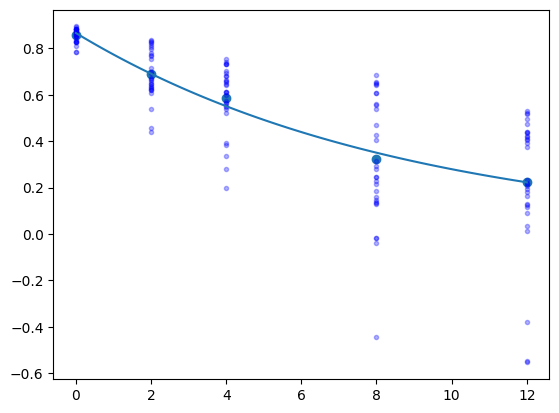

('Z', 'Z', 'I', 'Y')
[0.83397902 0.89786471] 0.007524890719109699


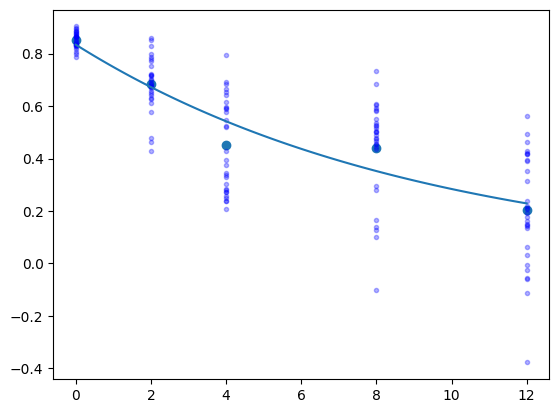

('Z', 'Z', 'I', 'Z')
[0.85679654 0.94162948] 0.004297000523782316


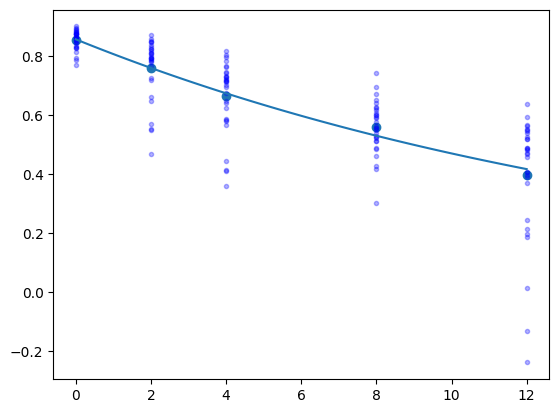

('Z', 'Z', 'X', 'I')
[0.8453464  0.78723412] 0.02628324776448536


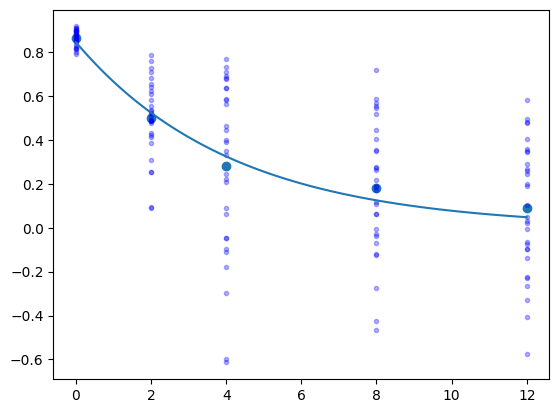

('Z', 'Z', 'X', 'X')
[0.82623959 0.84124891] 0.0163735719653286


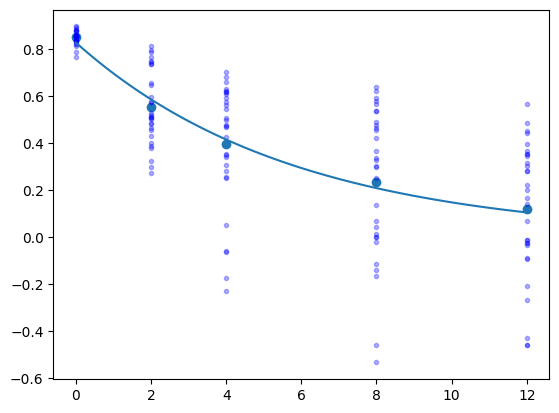

('Z', 'Z', 'X', 'Y')
[0.8359775  0.85101373] 0.013448461274521744


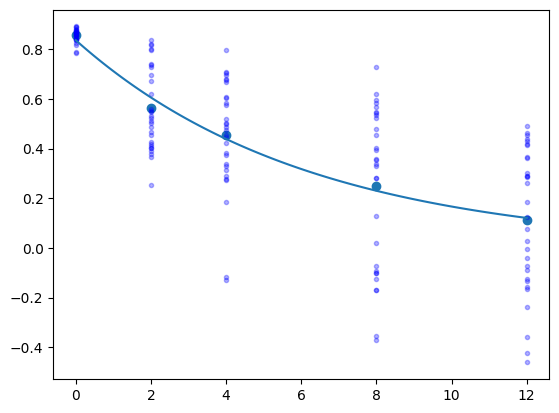

('Z', 'Z', 'X', 'Z')
[0.83023848 0.81460154] 0.021028626521496938


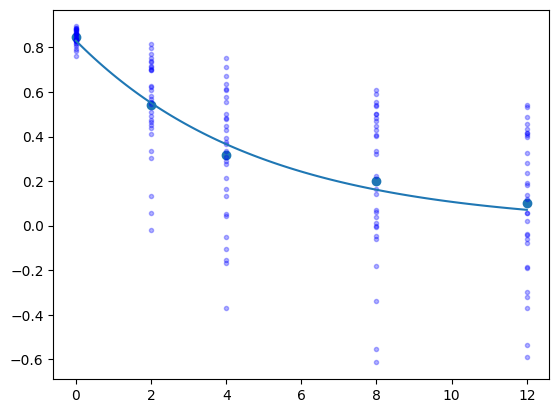

('Z', 'Z', 'Y', 'I')
[0.88583275 0.82082849] 0.018702051543402393


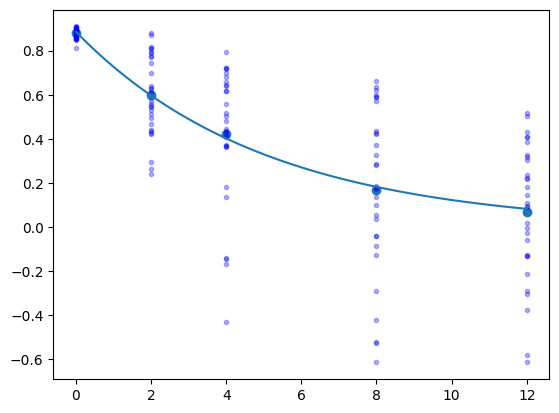

('Z', 'Z', 'Y', 'X')
[0.82794726 0.84326011] 0.017474286712049383


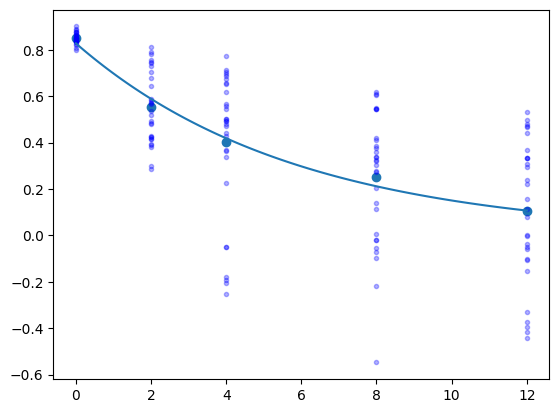

('Z', 'Z', 'Y', 'Y')
[0.84786625 0.85827225] 0.01327989344686798


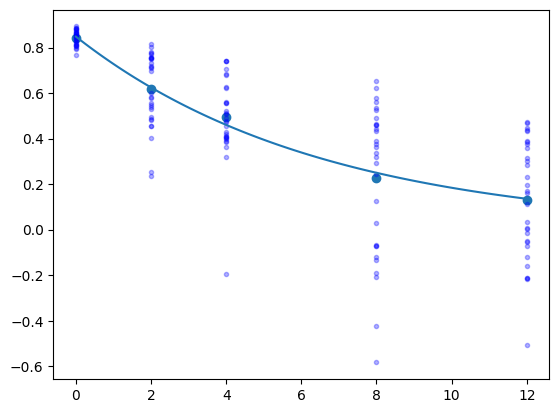

('Z', 'Z', 'Y', 'Z')
[0.86023344 0.79621609] 0.020172931219719945


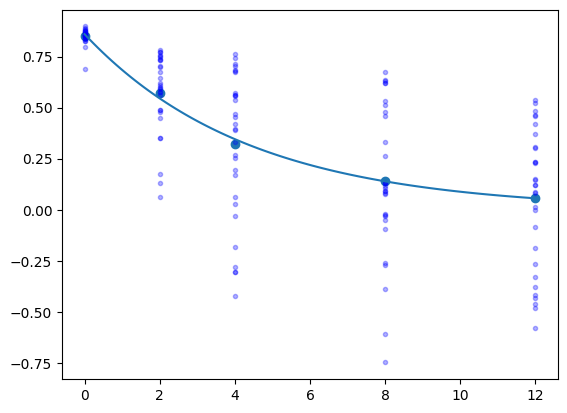

('Z', 'Z', 'Z', 'I')
[0.87674459 0.94068852] 0.0048442760934020316


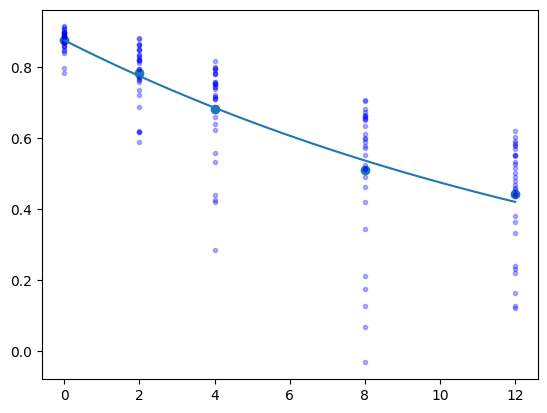

('Z', 'Z', 'Z', 'X')
[0.84788509 0.89697942] 0.006873934770082536


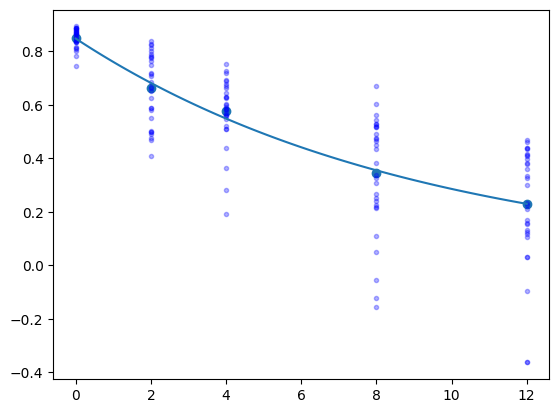

('Z', 'Z', 'Z', 'Y')
[0.85935179 0.89311528] 0.009047735984840667


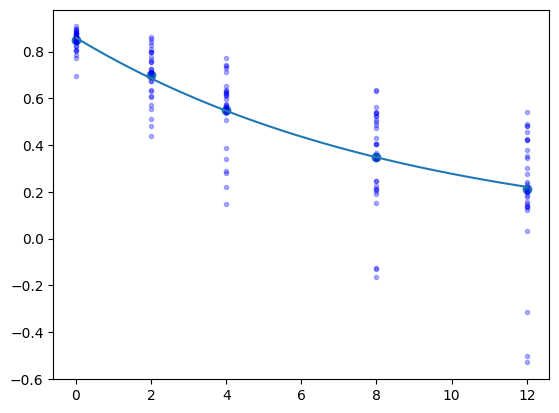

('Z', 'Z', 'Z', 'Z')
[0.83631681 0.94075343] 0.004780825984876919


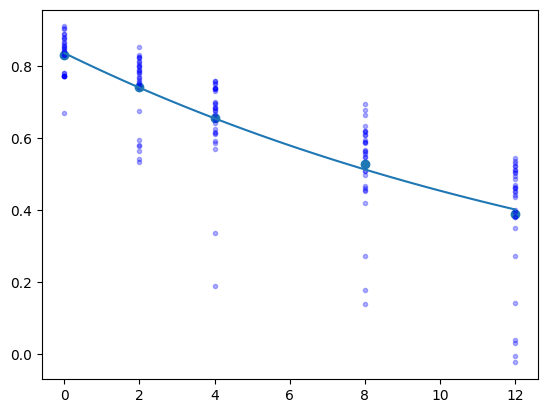

('I', 'I', 'I', 'I')
[1. 1.] 0.0


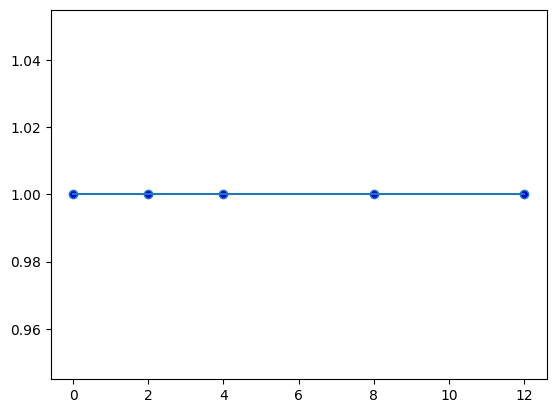

('I', 'I', 'I', 'X')
[0.97615523 0.9415587 ] 0.008781681458580609


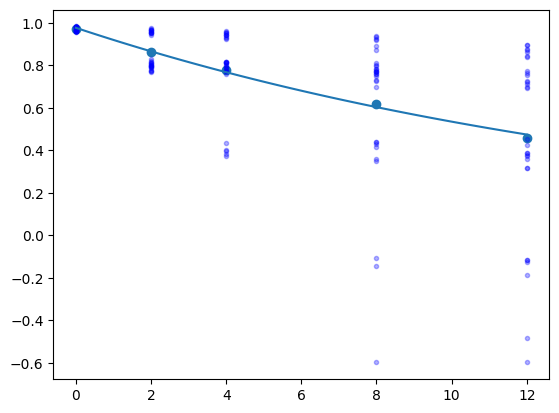

('I', 'I', 'I', 'Y')
[0.93620905 0.95952494] 0.008597256014020923


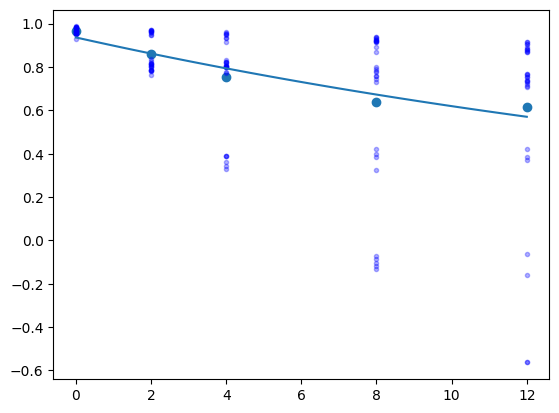

('I', 'I', 'I', 'Z')
[0.97111756 0.99420591] 0.00034653825223754327


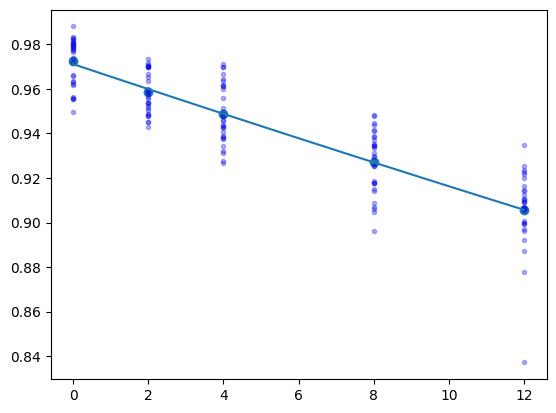

('I', 'I', 'X', 'I')
[0.98025731 0.85209384] 0.013577618261373419


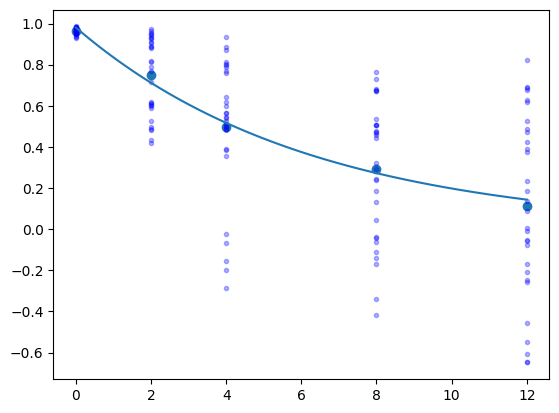

('I', 'I', 'X', 'X')
[0.91268335 0.90735883] 0.013571800413294971


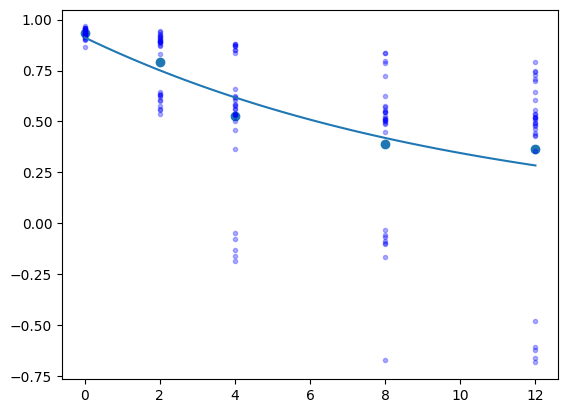

('I', 'I', 'X', 'Y')
[0.92720137 0.89360298] 0.01523514346907238


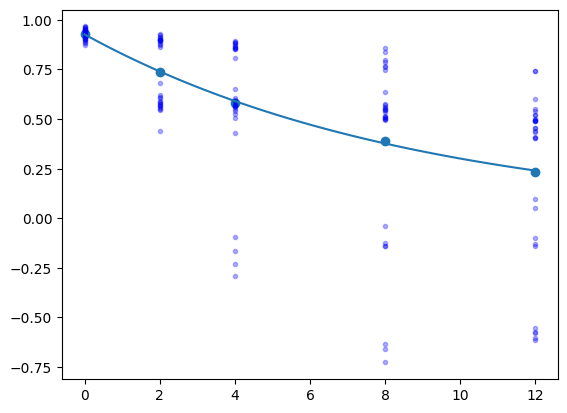

('I', 'I', 'X', 'Z')
[0.91005563 0.85546042] 0.02037680036572765


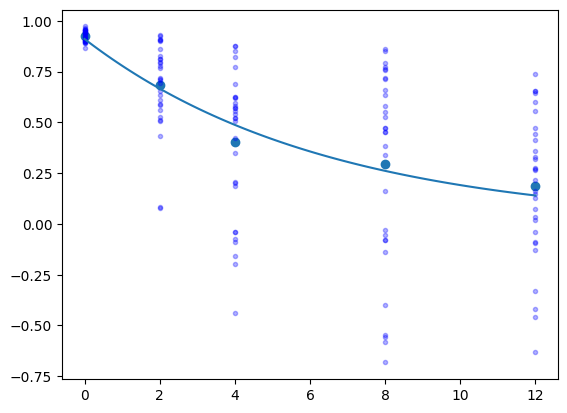

('I', 'I', 'Y', 'I')
[0.9421105  0.86531423] 0.015418039905009704


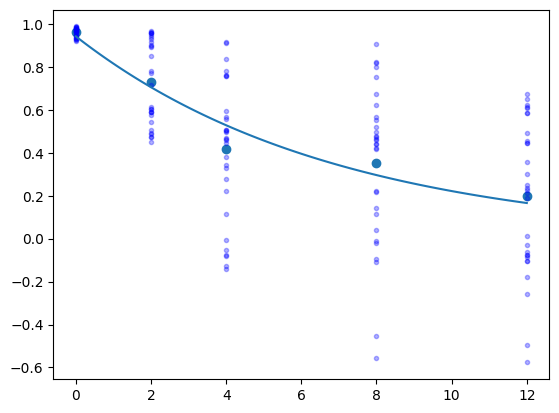

('I', 'I', 'Y', 'X')
[0.9527078  0.86359893] 0.014919893931050176


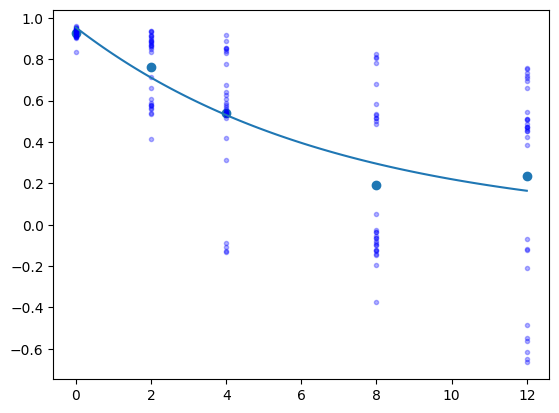

('I', 'I', 'Y', 'Y')
[0.91883916 0.8951291 ] 0.01614818004439159


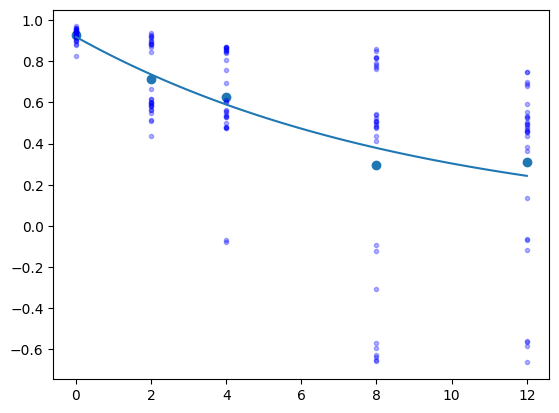

('I', 'I', 'Y', 'Z')
[0.96587957 0.86262702] 0.017568758911261046


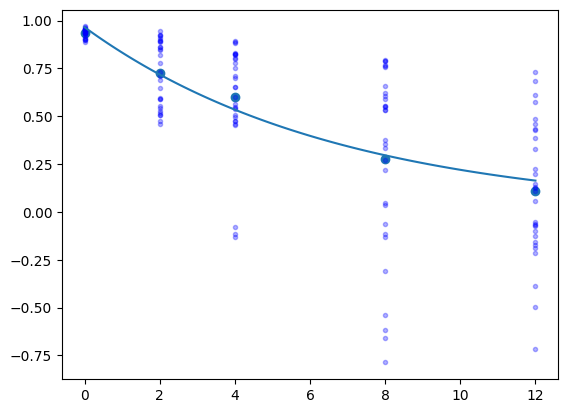

('I', 'I', 'Z', 'I')
[0.95722827 0.98080926] 0.0013348722921243034


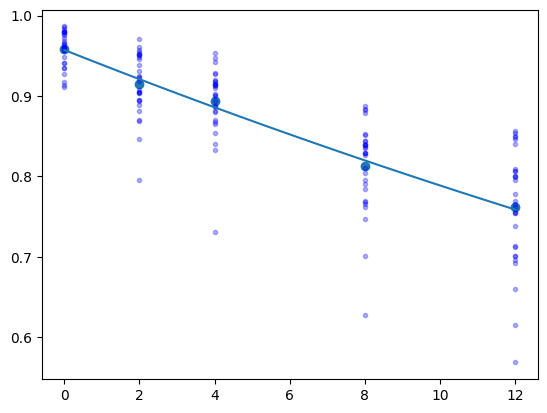

('I', 'I', 'Z', 'X')
[0.93991796 0.93014931] 0.009346543069273789


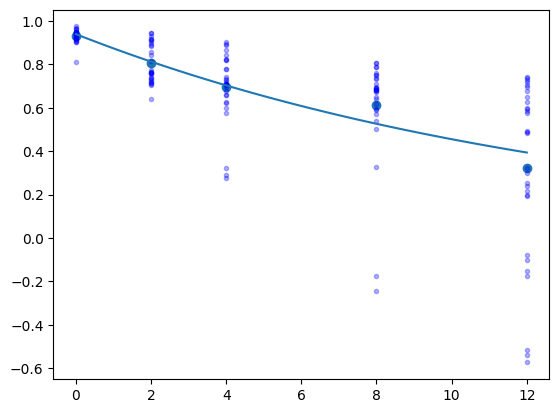

('I', 'I', 'Z', 'Y')
[0.94846063 0.92524559] 0.008702334309457932


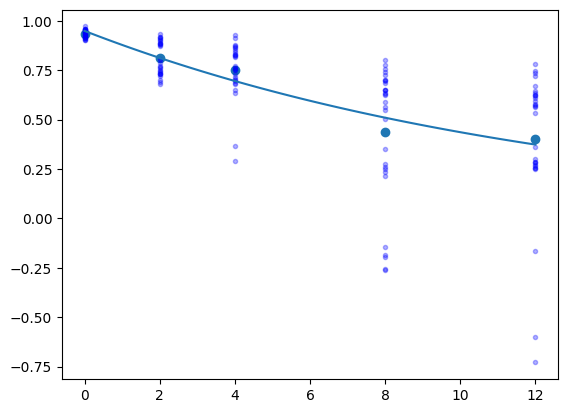

('I', 'I', 'Z', 'Z')
[0.92752124 0.9758628 ] 0.0012278865925795719


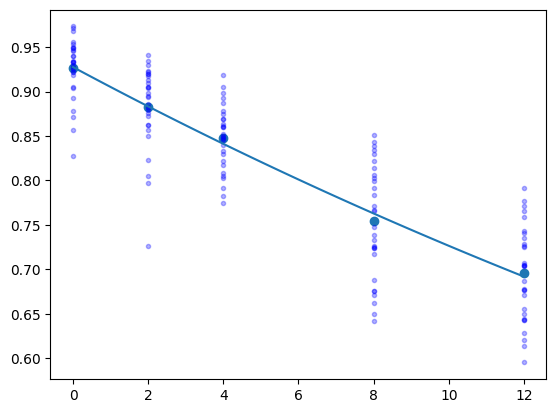

('I', 'X', 'I', 'I')
[0.91312881 0.89054101] 0.013341412049873474


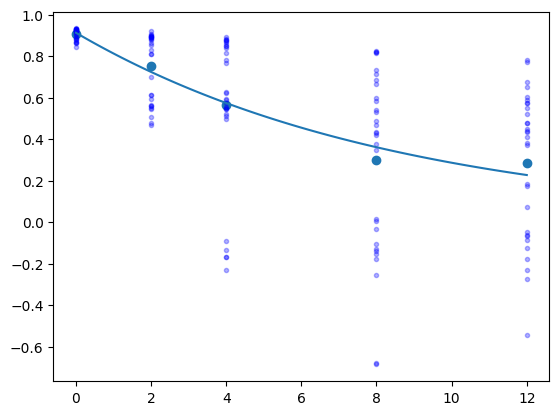

('I', 'X', 'I', 'X')
[0.86473659 0.86042347] 0.01280558772542334


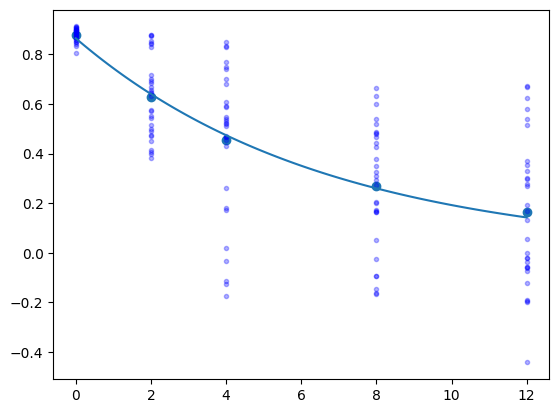

('I', 'X', 'I', 'Y')
[0.89745147 0.83677072] 0.01589222771943775


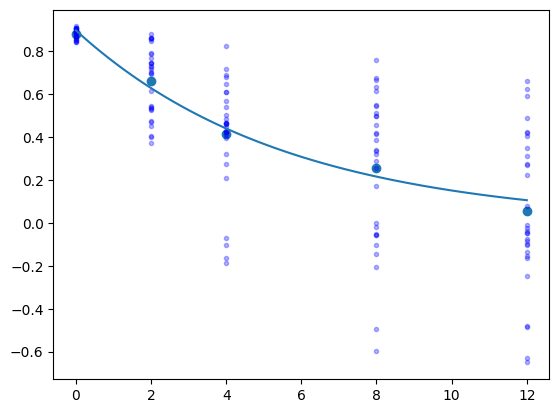

('I', 'X', 'I', 'Z')
[0.8735203 0.8984633] 0.011629699831197535


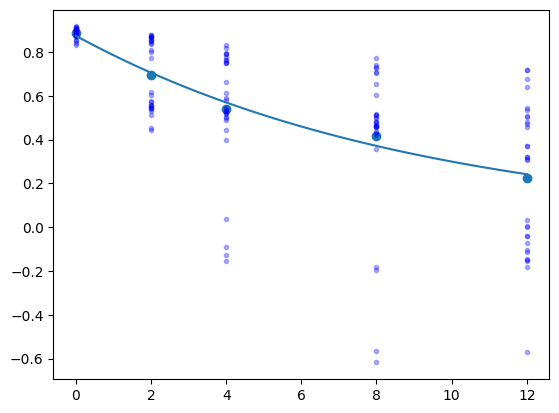

('I', 'X', 'X', 'I')
[0.86738686 0.92545544] 0.007763449110937903


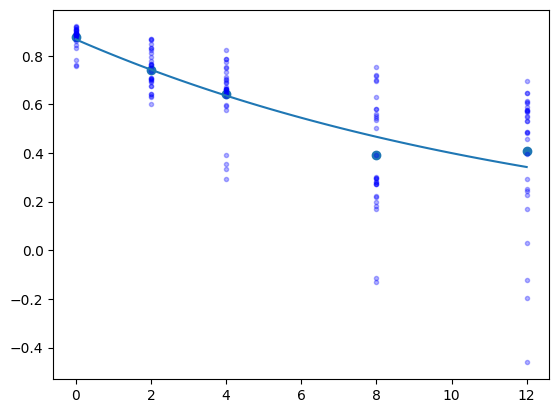

('I', 'X', 'X', 'X')
[0.85847364 0.96650181] 0.0009149909842909269


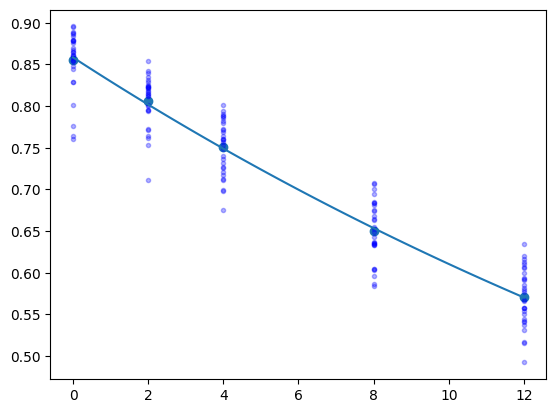

('I', 'X', 'X', 'Y')
[0.85428483 0.96772254] 0.001169408948845265


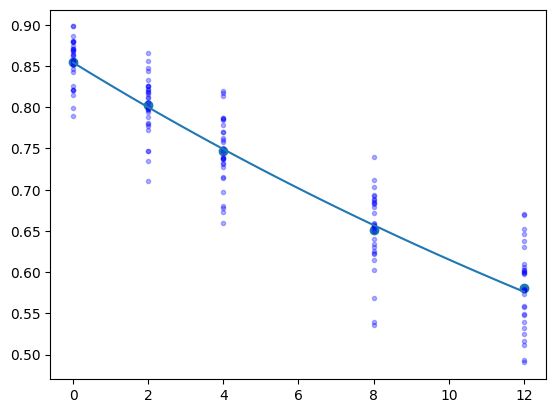

('I', 'X', 'X', 'Z')
[0.84891371 0.92714635] 0.008280198325461587


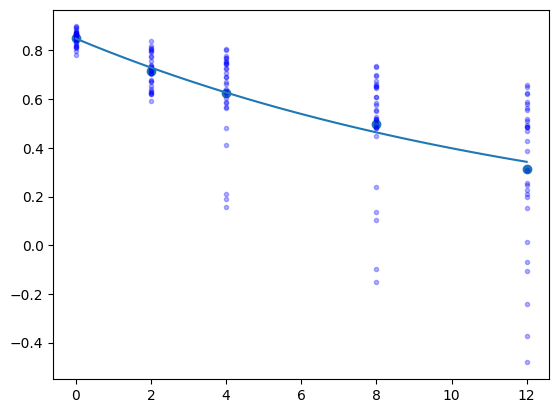

('I', 'X', 'Y', 'I')
[0.90008092 0.90799451] 0.010506068871901617


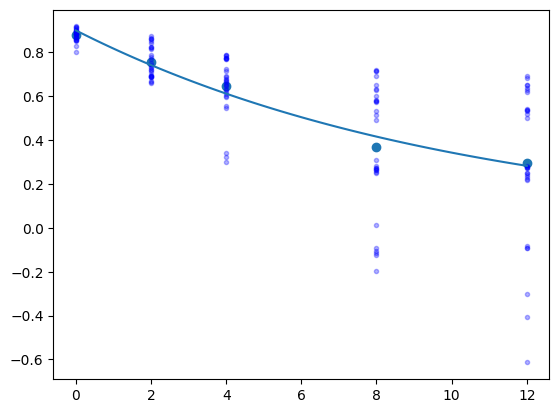

('I', 'X', 'Y', 'X')
[0.85112722 0.96912204] 0.0009942759096492765


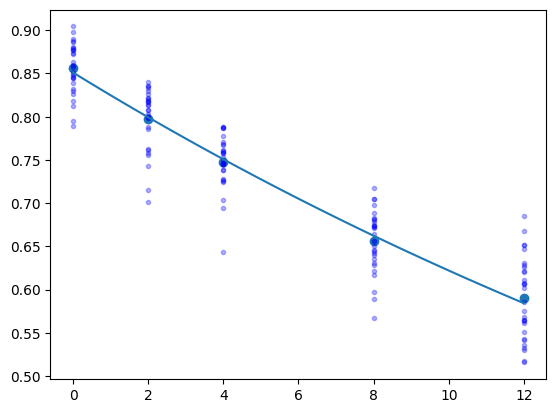

('I', 'X', 'Y', 'Y')
[0.84498155 0.97014734] 0.0009639107107089906


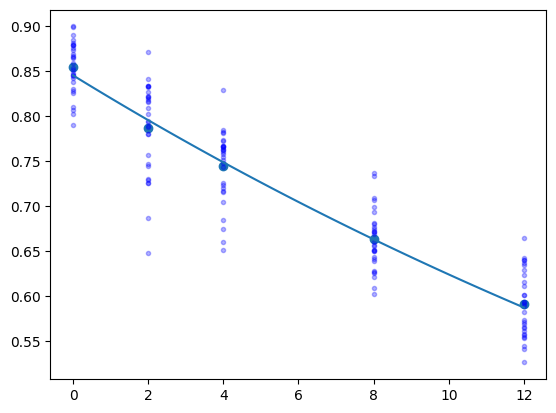

('I', 'X', 'Y', 'Z')
[0.85001846 0.93782262] 0.006065298708049867


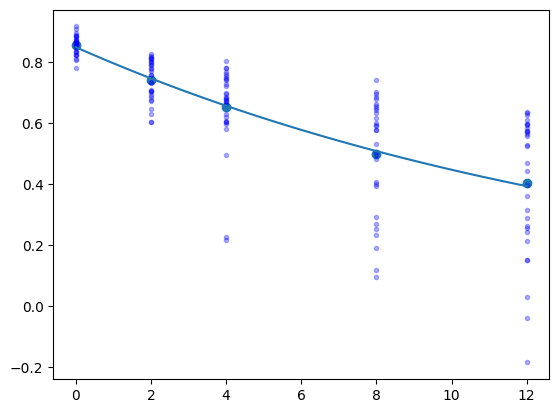

('I', 'X', 'Z', 'I')
[0.83800065 0.91070132] 0.017971187995134478


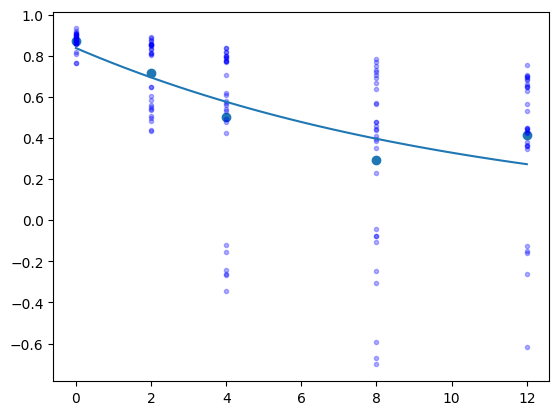

('I', 'X', 'Z', 'X')
[0.8465298  0.85049816] 0.01737114600275622


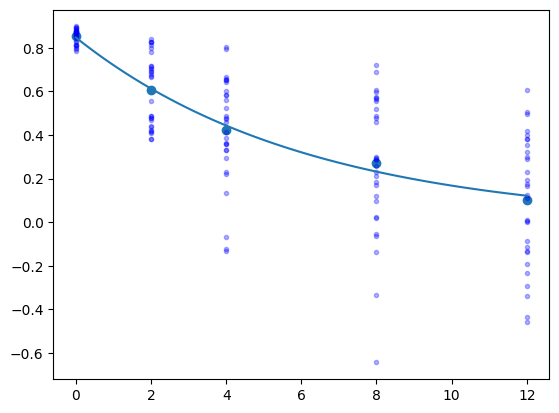

('I', 'X', 'Z', 'Y')
[0.82187344 0.85847943] 0.017422964255999086


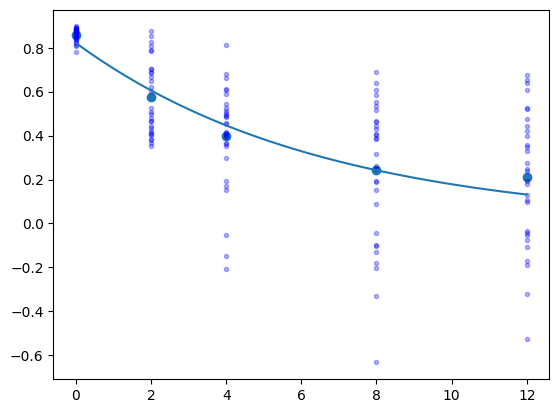

('I', 'X', 'Z', 'Z')
[0.79964002 0.90276872] 0.012715097718198346


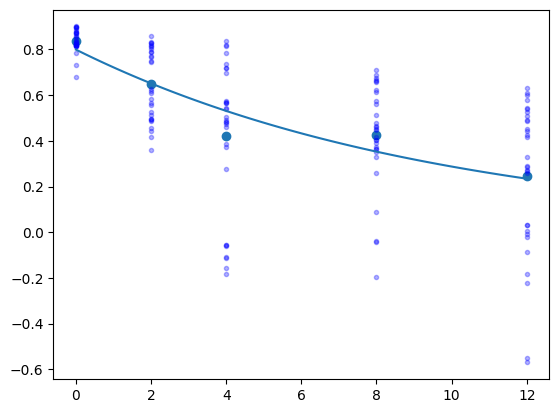

('I', 'Y', 'I', 'I')
[0.92648336 0.88903302] 0.012783098816307846


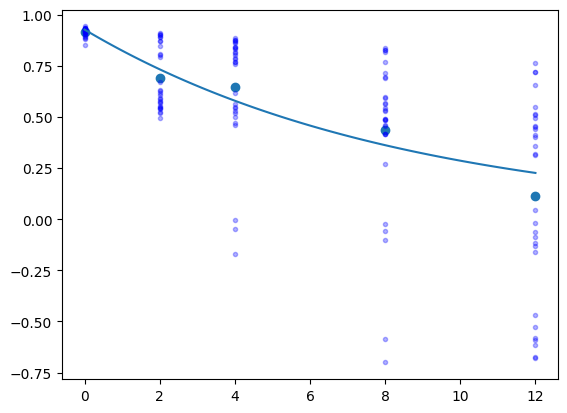

('I', 'Y', 'I', 'X')
[0.89500786 0.83193446] 0.018195005814109464


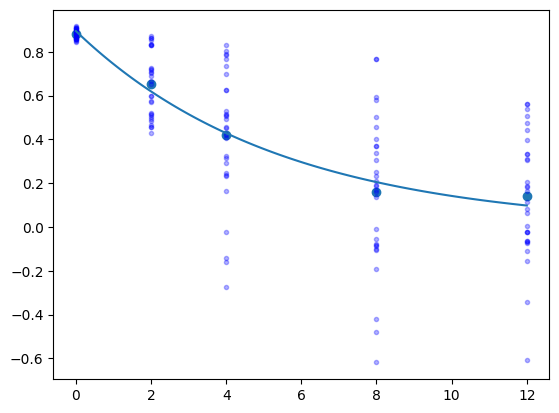

('I', 'Y', 'I', 'Y')
[0.89297224 0.83712186] 0.015235303434982462


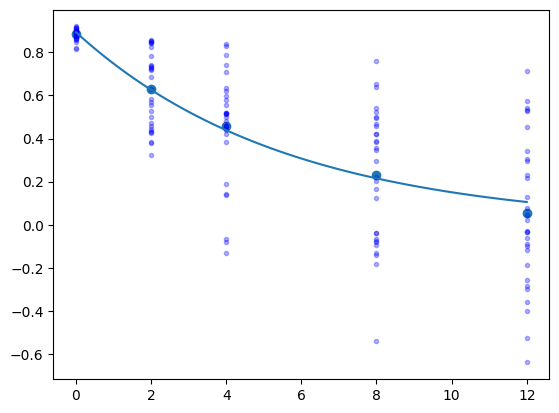

('I', 'Y', 'I', 'Z')
[0.87304075 0.88567719] 0.015562128328457981


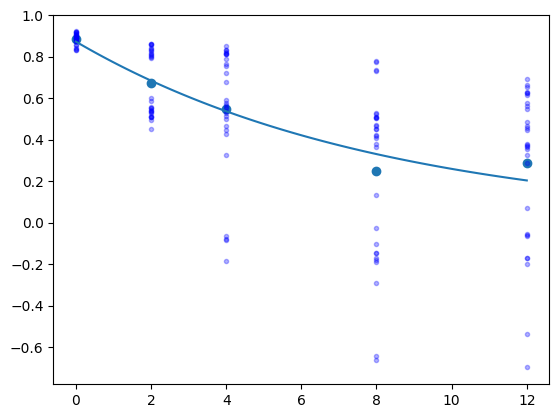

('I', 'Y', 'X', 'I')
[0.87870697 0.93189095] 0.00838882395012427


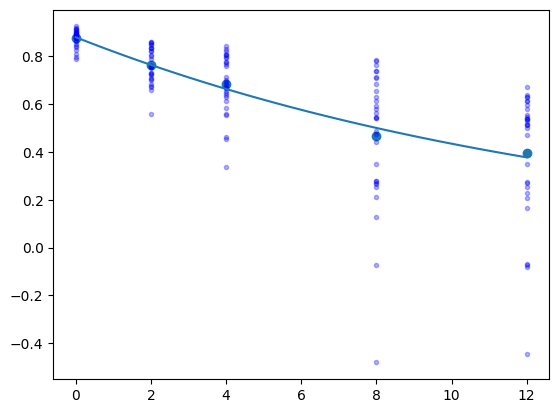

('I', 'Y', 'X', 'X')
[0.84678054 0.96993094] 0.0009983302157397416


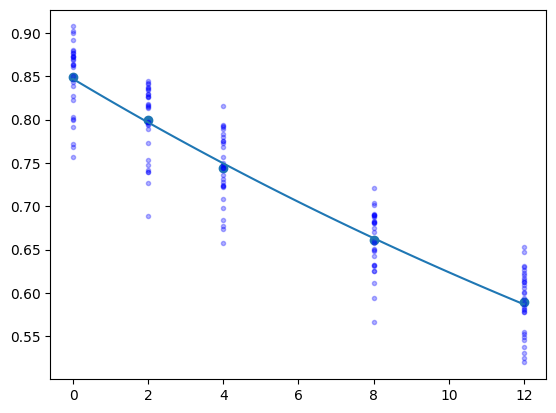

('I', 'Y', 'X', 'Y')
[0.86499667 0.96605855] 0.0010887721355899898


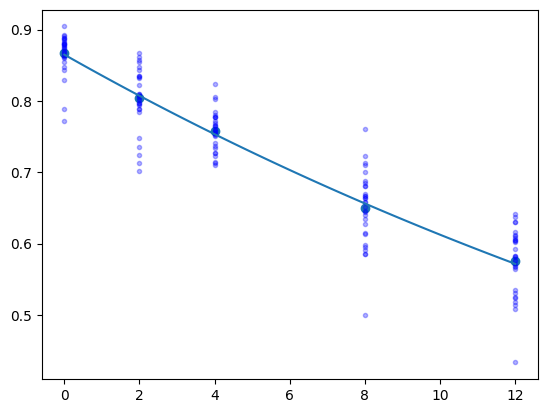

('I', 'Y', 'X', 'Z')
[0.83424757 0.93497554] 0.0079765830541308


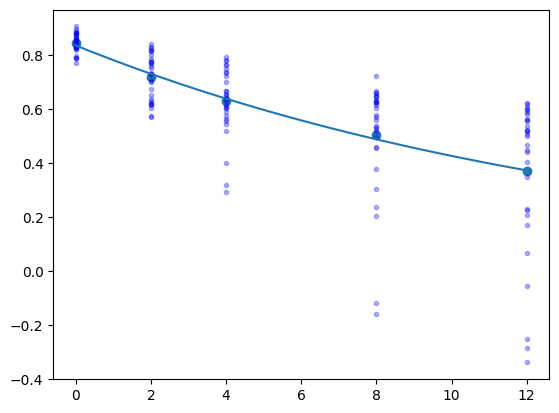

('I', 'Y', 'Y', 'I')
[0.89133515 0.9240436 ] 0.007285119204341318


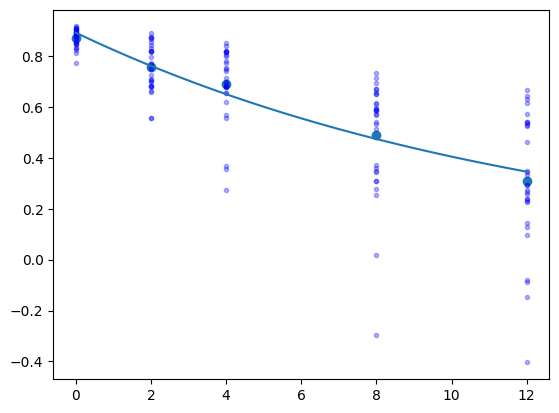

('I', 'Y', 'Y', 'X')
[0.85192402 0.9690743 ] 0.0010661132384437195


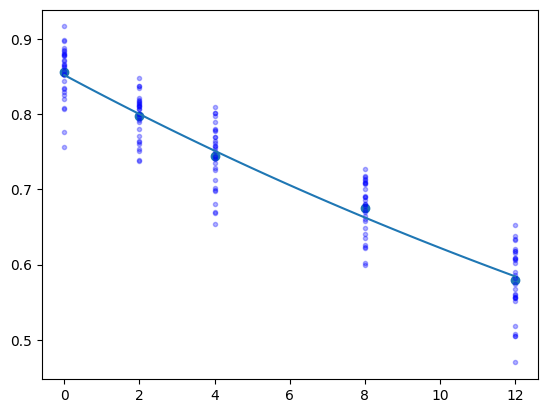

('I', 'Y', 'Y', 'Y')
[0.83962648 0.97225919] 0.001122275723025482


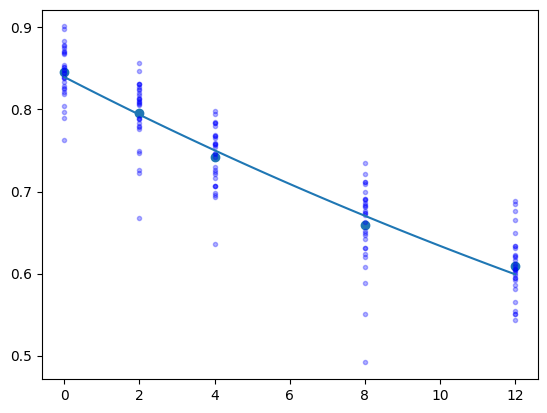

('I', 'Y', 'Y', 'Z')
[0.88028694 0.91038984] 0.010034855459016436


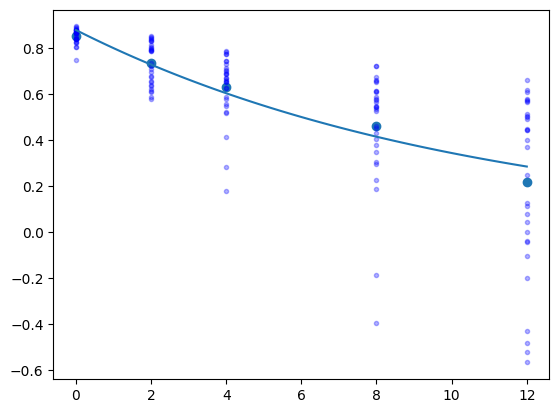

('I', 'Y', 'Z', 'I')
[0.87991664 0.87130958] 0.02026611967488627


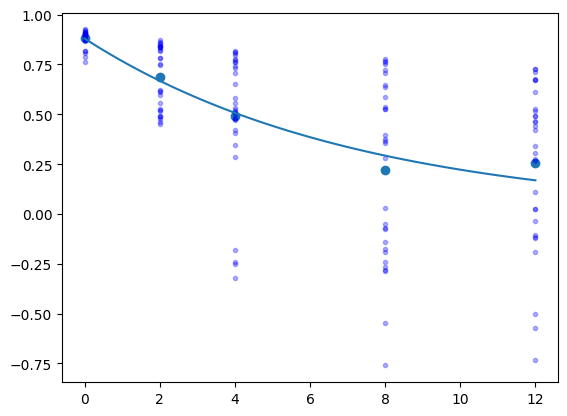

('I', 'Y', 'Z', 'X')
[0.88612716 0.79896578] 0.015746984526560055


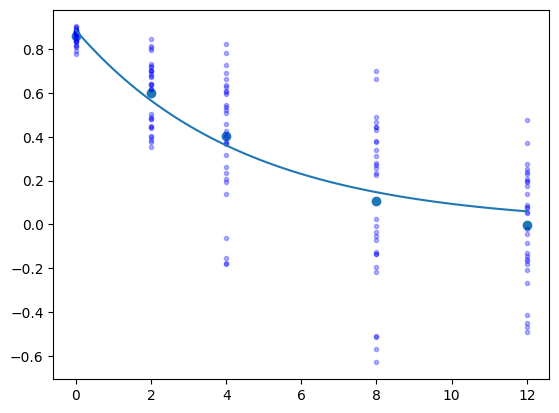

('I', 'Y', 'Z', 'Y')
[0.85796587 0.84734778] 0.01631394479841172


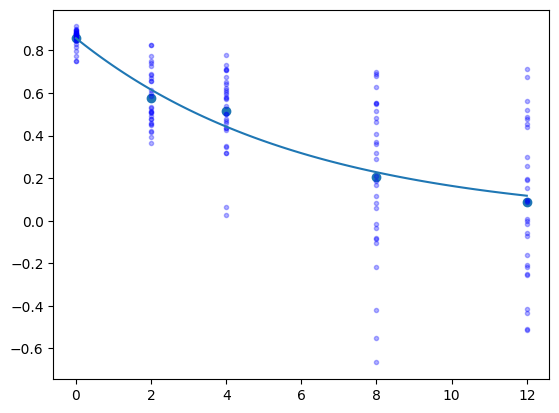

('I', 'Y', 'Z', 'Z')
[0.86033406 0.87777222] 0.015404094998576598


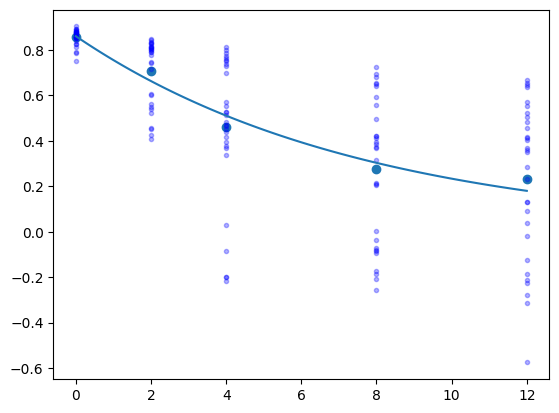

('I', 'Z', 'I', 'I')
[0.91757743 0.97728857] 0.0018375531267896786


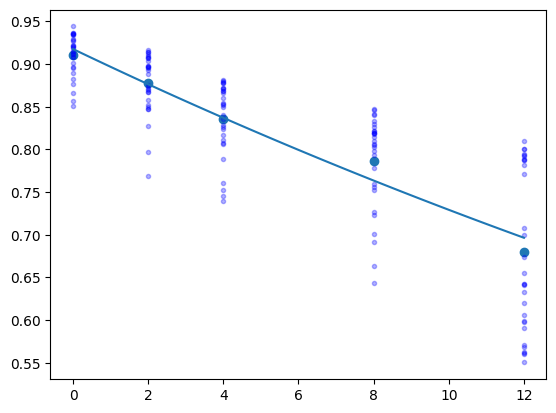

('I', 'Z', 'I', 'X')
[0.91354146 0.92311905] 0.00951717656117346


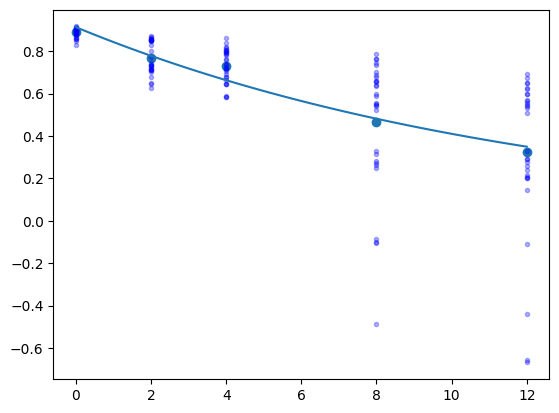

('I', 'Z', 'I', 'Y')
[0.86168491 0.93199481] 0.008320144361595134


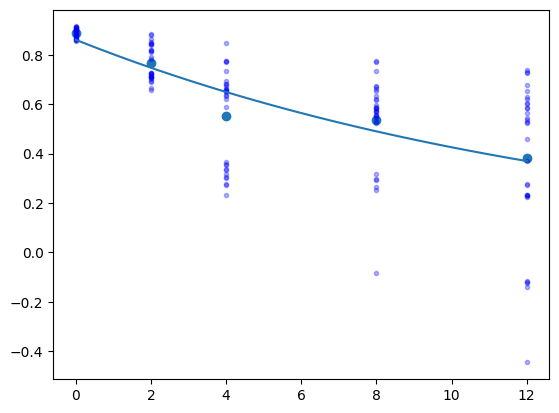

('I', 'Z', 'I', 'Z')
[0.88934387 0.97502794] 0.0013226765197550448


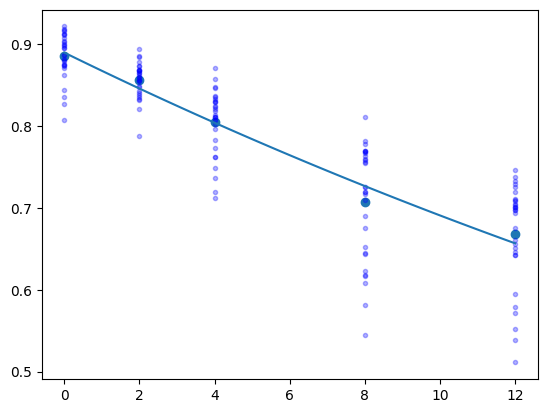

('I', 'Z', 'X', 'I')
[0.85116375 0.82814577] 0.02438604943402007


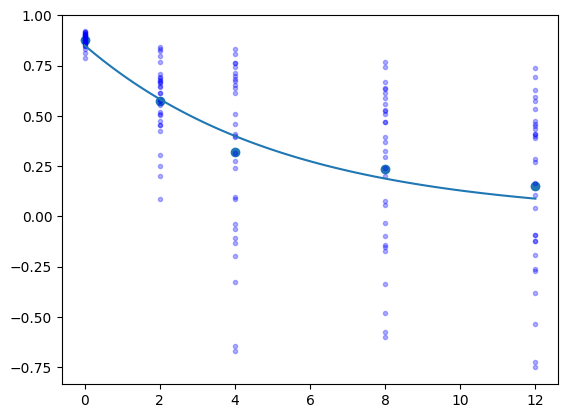

('I', 'Z', 'X', 'X')
[0.84501221 0.87273634] 0.016478351743648527


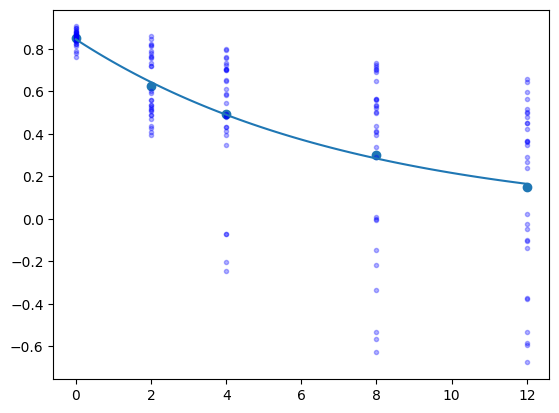

('I', 'Z', 'X', 'Y')
[0.84332799 0.87952504] 0.017404336446231513


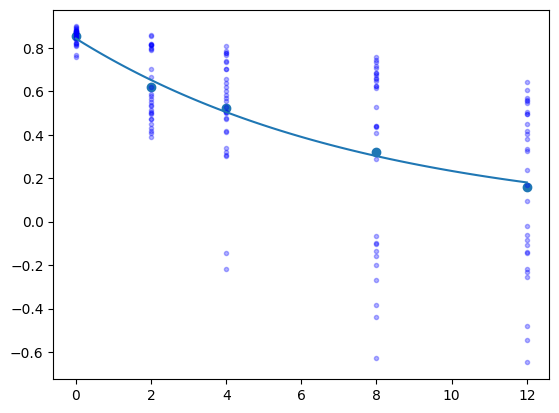

('I', 'Z', 'X', 'Z')
[0.84321685 0.85662282] 0.020200797975186962


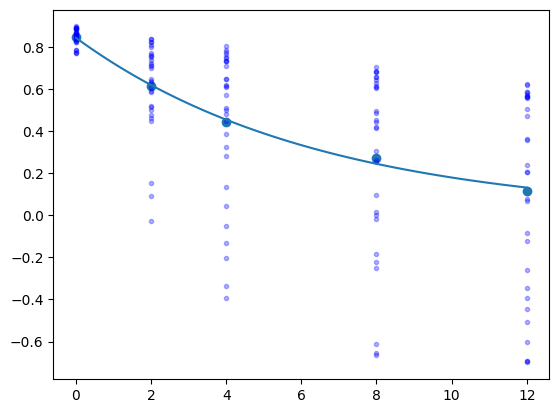

('I', 'Z', 'Y', 'I')
[0.90882697 0.84219377] 0.018991393995808264


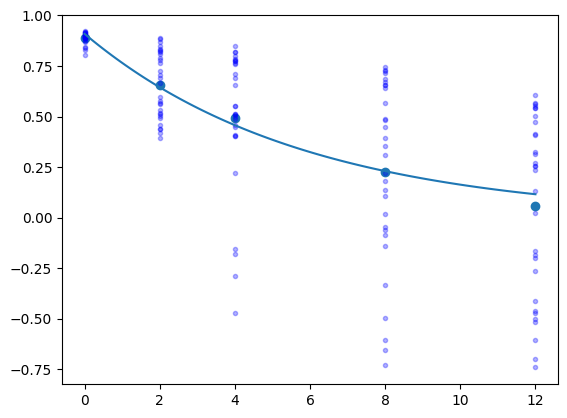

('I', 'Z', 'Y', 'X')
[0.81942294 0.88577286] 0.01879589929952353


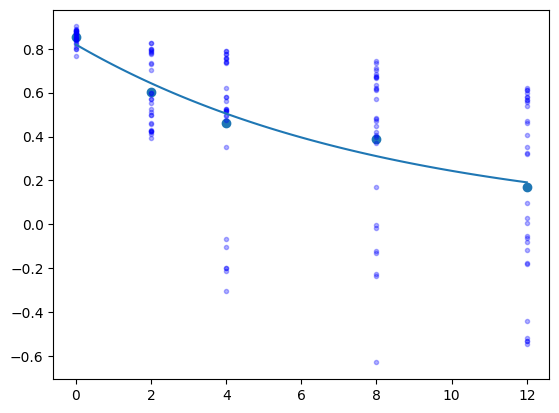

('I', 'Z', 'Y', 'Y')
[0.86896054 0.87635653] 0.015333569346532544


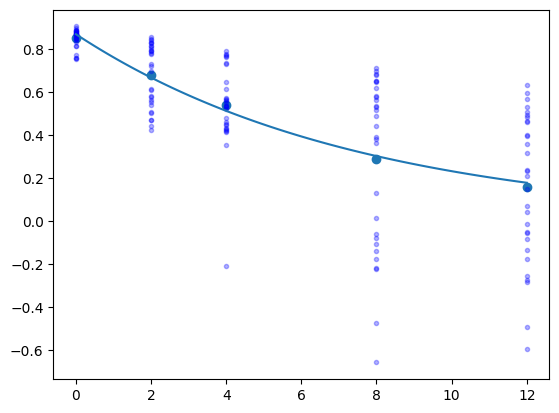

('I', 'Z', 'Y', 'Z')
[0.8676382  0.82217349] 0.02483120166587107


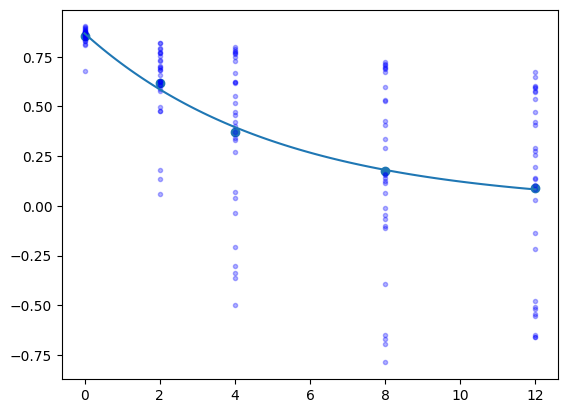

('I', 'Z', 'Z', 'I')
[0.8843633  0.97196963] 0.0014520992354178533


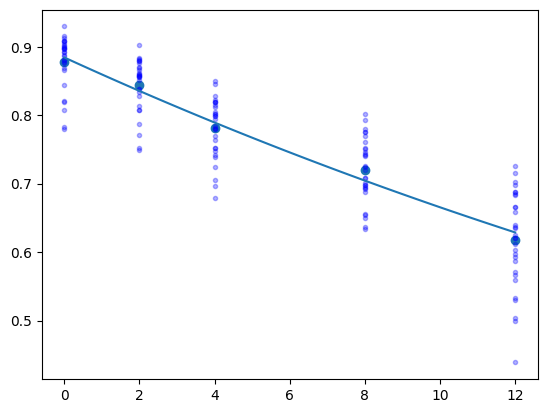

('I', 'Z', 'Z', 'X')
[0.86891103 0.9226927 ] 0.007399637103040197


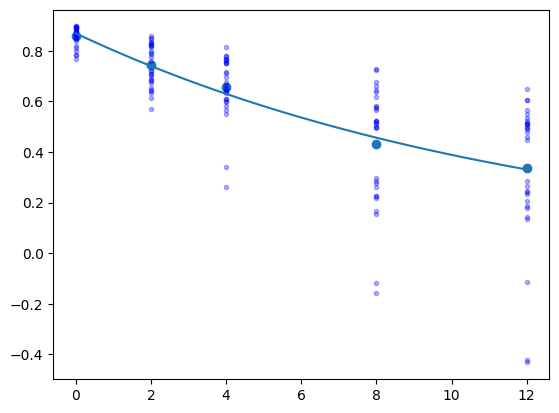

('I', 'Z', 'Z', 'Y')
[0.86291403 0.91817481] 0.008757780265259897


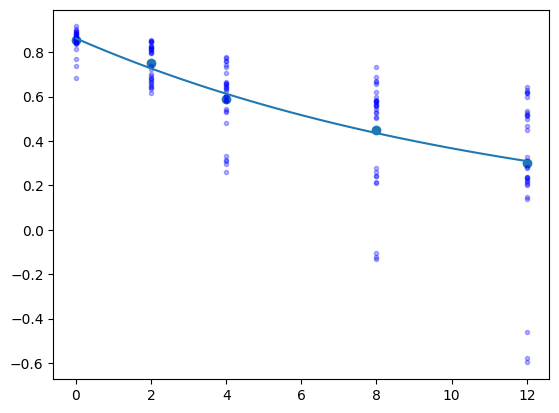

('I', 'Z', 'Z', 'Z')
[0.8439122  0.96918127] 0.001427016705127268


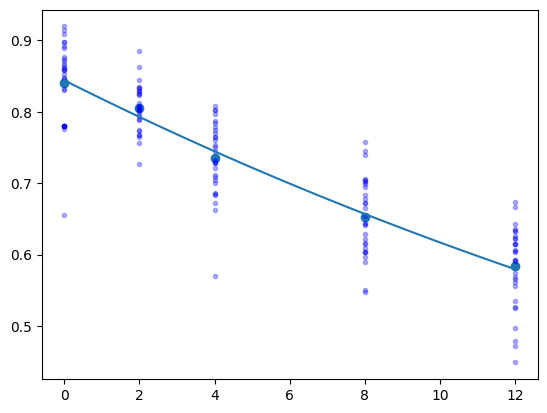

In [14]:
eigs = {}
eigs_std = {}
for p, energy_lists in circuit_energies_by_pauli.items():
    print(p)
    means = [np.mean(l) for l in energy_lists]
    res = curve_fit(decay_form, depths, means, p0=[1,0.99])[0]

    std = bootstrap_error(energy_lists, depths, bootstrap_samples=100, n_shots=5000)
    eigs[(p,False)] = res[1]
    eigs_std[(p,False)] = std
    print(res, std)
    xs = np.linspace(0,12, 100)
    f = [decay_form(x, *res) for x in xs]
    plt.scatter(depths, means)
    plt.plot(xs, f)
    for d, elist in zip(depths, energy_lists):
        plt.scatter([d for _ in elist], elist, alpha=0.3, color='blue', marker='.')
    plt.show()

('Z', 'I', 'I', 'I')
[0.94413413 0.97444598] 0.002914820302808401


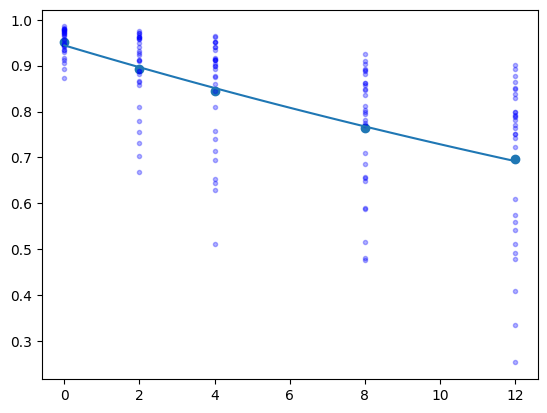

('Z', 'I', 'I', 'X')
[0.91139577 0.91247174] 0.00958198620163348


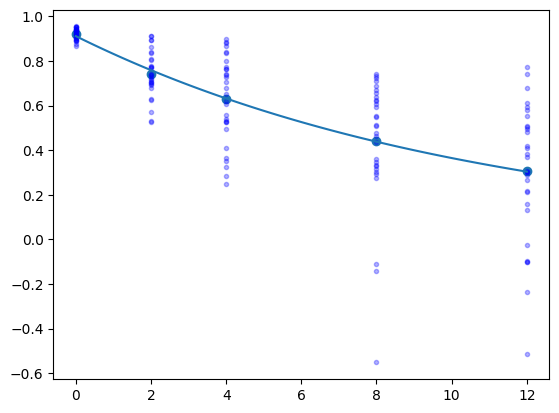

('Z', 'I', 'I', 'Y')
[0.90295661 0.9285526 ] 0.008076888063914588


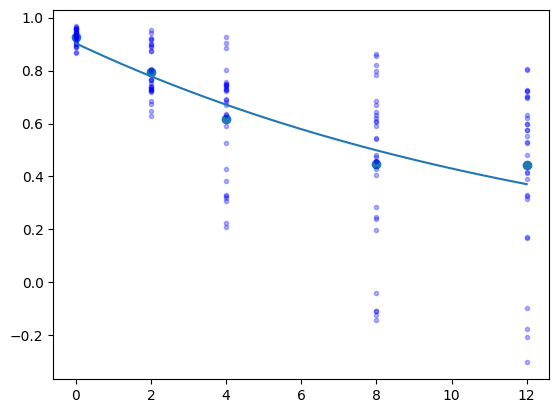

('Z', 'I', 'I', 'Z')
[0.900538   0.96831536] 0.0028328930052672844


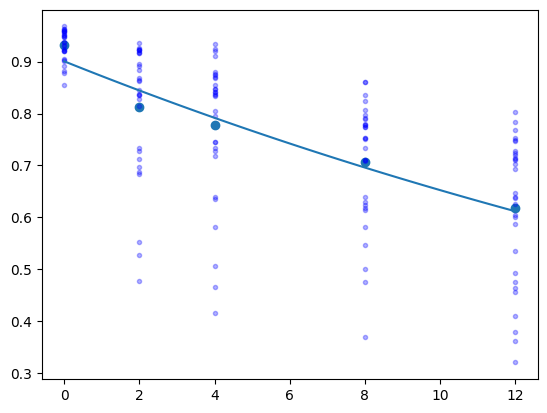

('Z', 'I', 'X', 'I')
[0.96543171 0.83471742] 0.015763681964926286


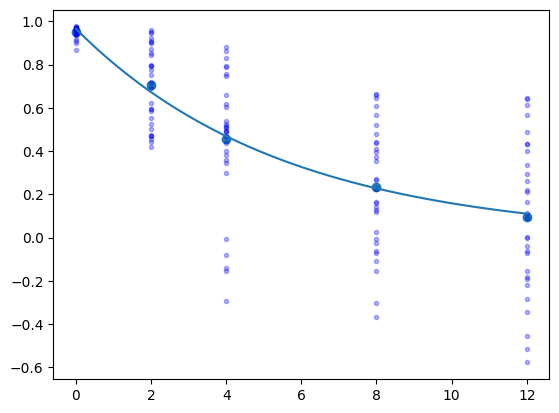

('Z', 'I', 'X', 'X')
[0.91359418 0.87030057] 0.014475727705244135


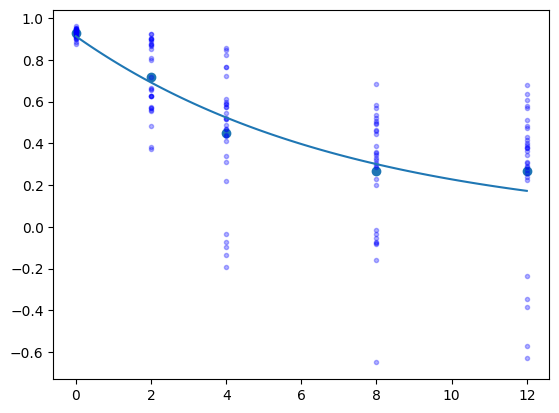

('Z', 'I', 'X', 'Y')
[0.92018284 0.8709615 ] 0.015323874017840173


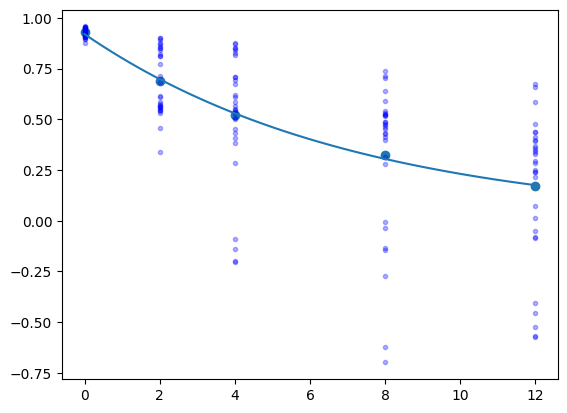

('Z', 'I', 'X', 'Z')
[0.9242196  0.81999145] 0.019914566394954886


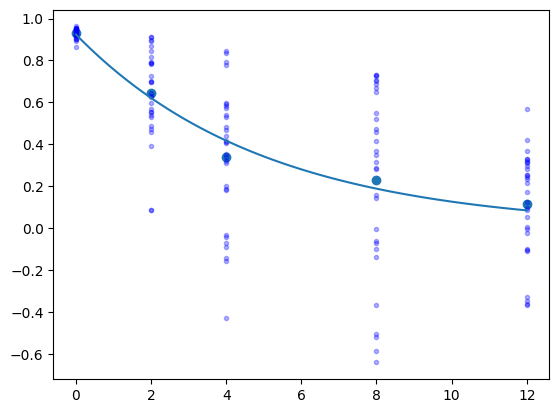

('Z', 'I', 'Y', 'I')
[0.94005375 0.84054961] 0.015354620388969856


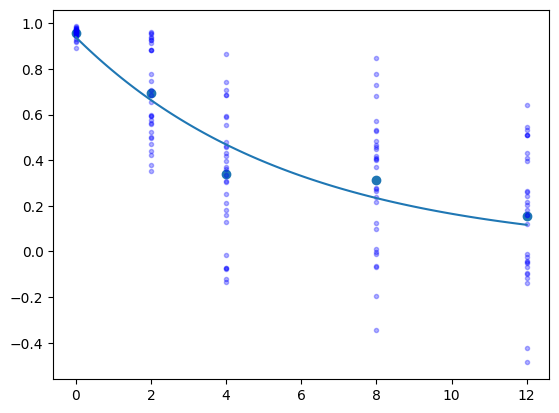

('Z', 'I', 'Y', 'X')
[0.94507372 0.84261355] 0.016673034900489325


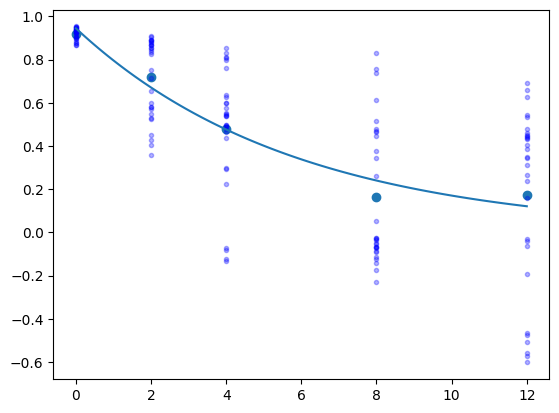

('Z', 'I', 'Y', 'Y')
[0.91815516 0.8635072 ] 0.01672500514723766


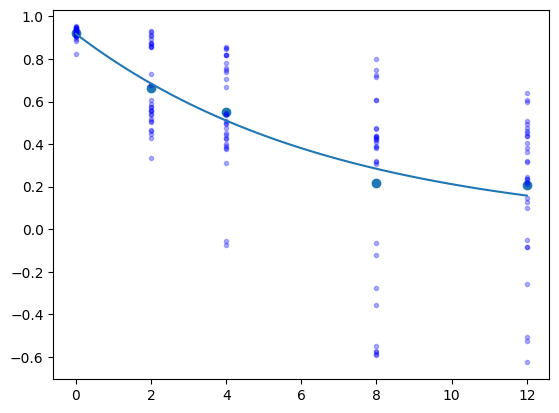

('Z', 'I', 'Y', 'Z')
[0.94545347 0.84361144] 0.013800810913262063


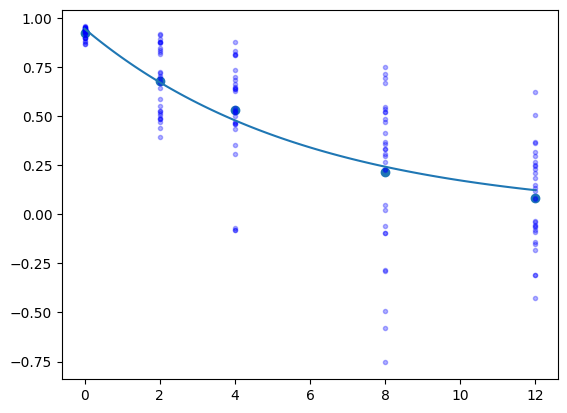

('Z', 'I', 'Z', 'I')
[0.92325897 0.97224247] 0.0025006182661047433


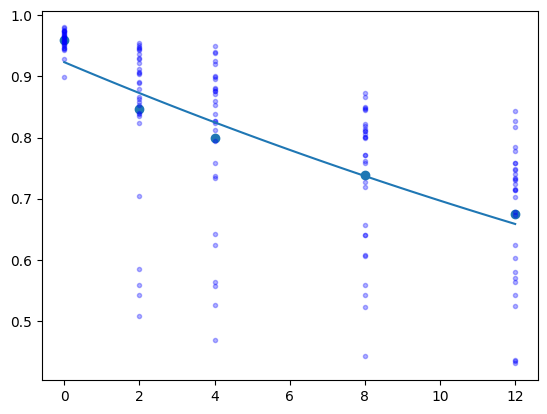

('Z', 'I', 'Z', 'X')
[0.9216482  0.91481668] 0.008700647954458018


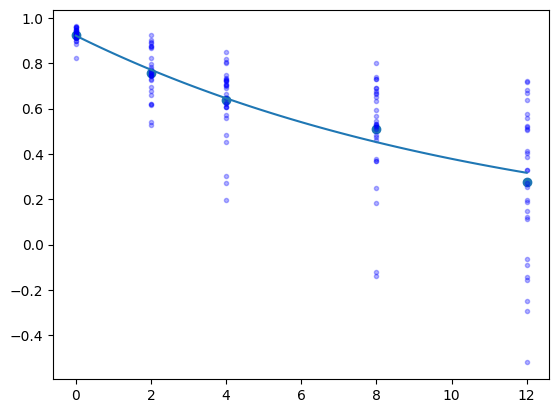

('Z', 'I', 'Z', 'Y')
[0.93520091 0.90417531] 0.00852217336464864


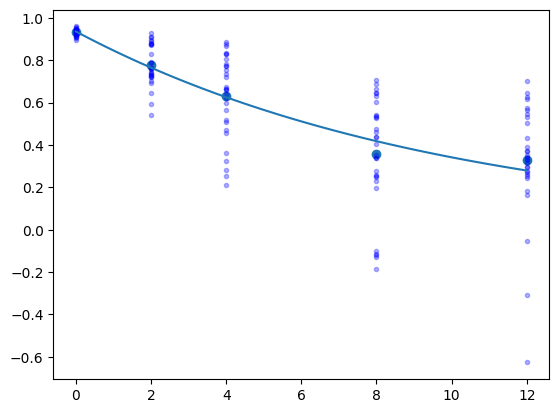

('Z', 'I', 'Z', 'Z')
[0.91363603 0.96319013] 0.0029370749828180527


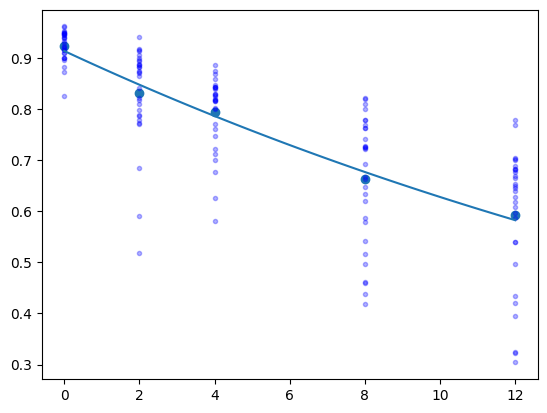

('Z', 'X', 'I', 'I')
[0.86119263 0.87358445] 0.013894712688896173


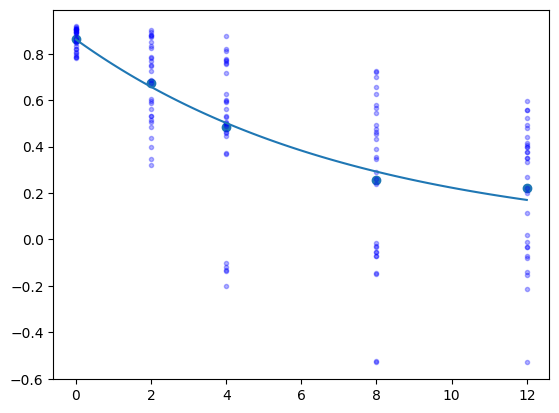

('Z', 'X', 'I', 'X')
[0.82962474 0.84427028] 0.012858107909475404


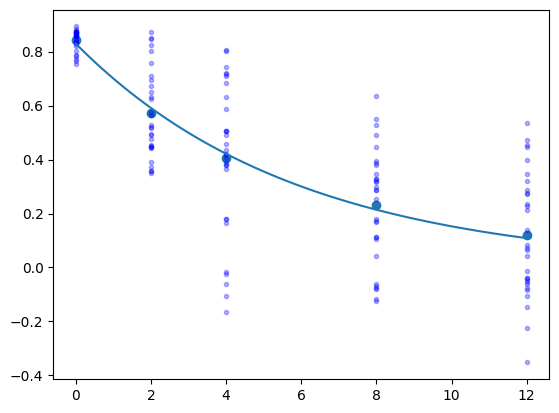

('Z', 'X', 'I', 'Y')
[0.85828166 0.82062313] 0.015697905390970702


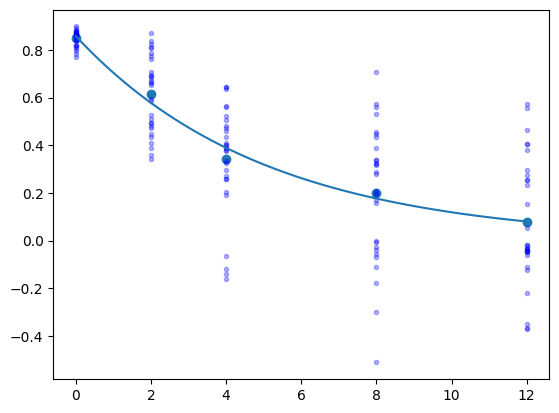

('Z', 'X', 'I', 'Z')
[0.83981374 0.87798625] 0.011625819918947894


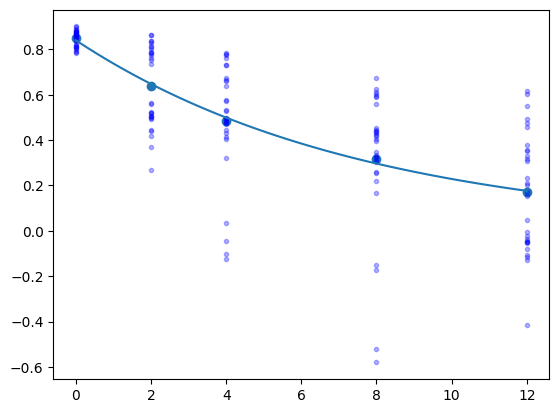

('Z', 'X', 'X', 'I')
[0.86006173 0.90076844] 0.0075249091641933575


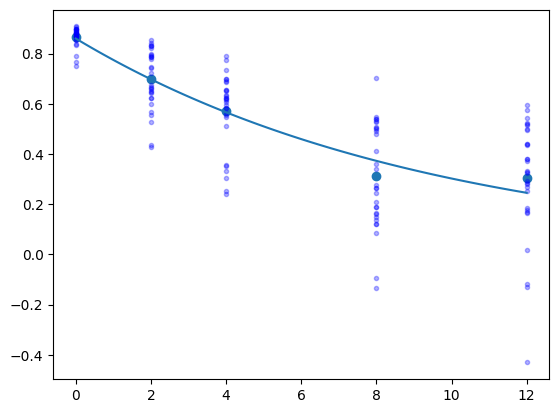

('Z', 'X', 'X', 'X')
[0.84316533 0.94958993] 0.0025435649009992226


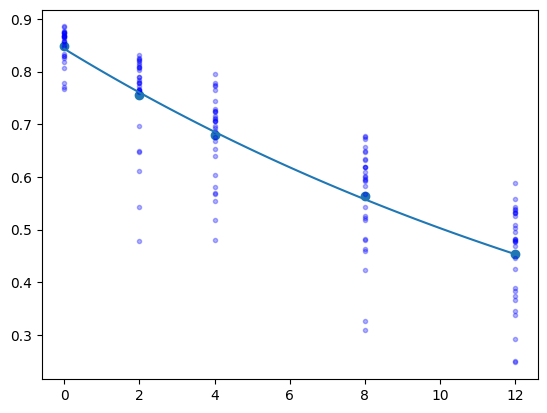

('Z', 'X', 'X', 'Y')
[0.82381194 0.94873353] 0.003013927301179463


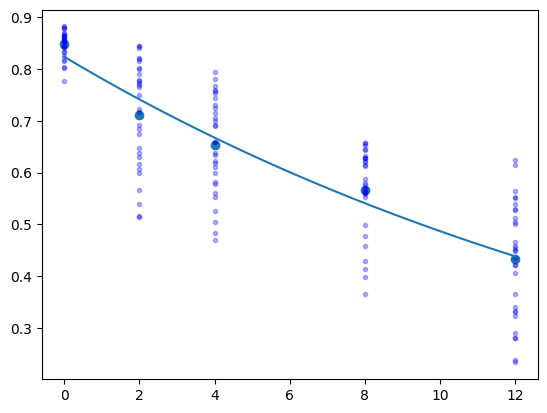

('Z', 'X', 'X', 'Z')
[0.8317471  0.90792626] 0.008300391084344747


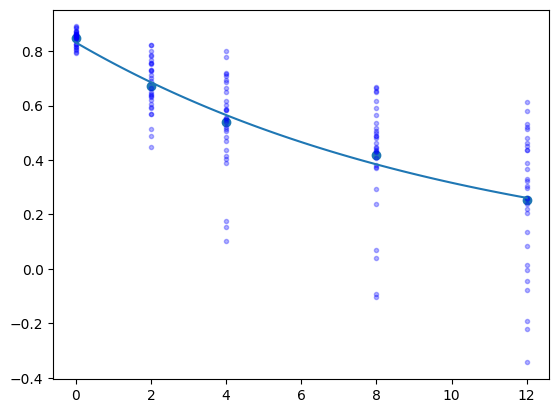

('Z', 'X', 'Y', 'I')
[0.89877001 0.88797152] 0.009894487305552702


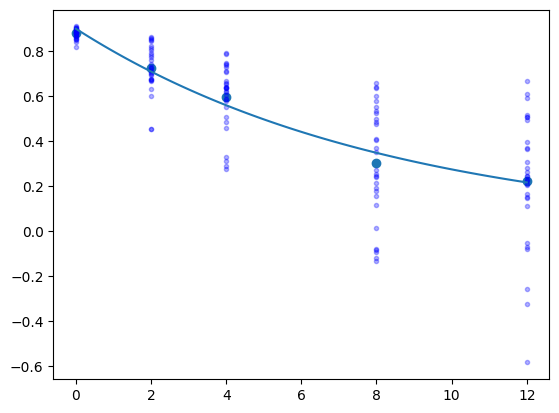

('Z', 'X', 'Y', 'X')
[0.83274459 0.94611794] 0.0033932412123835473


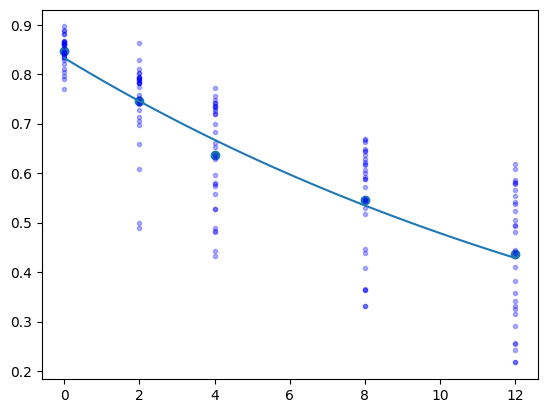

('Z', 'X', 'Y', 'Y')
[0.84304084 0.94985291] 0.0027734254449789312


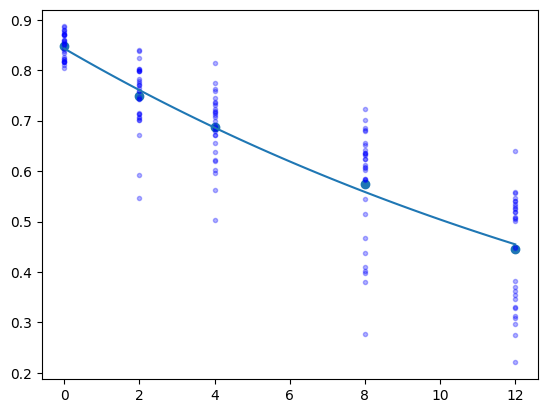

('Z', 'X', 'Y', 'Z')
[0.83639322 0.91959857] 0.005834201688740434


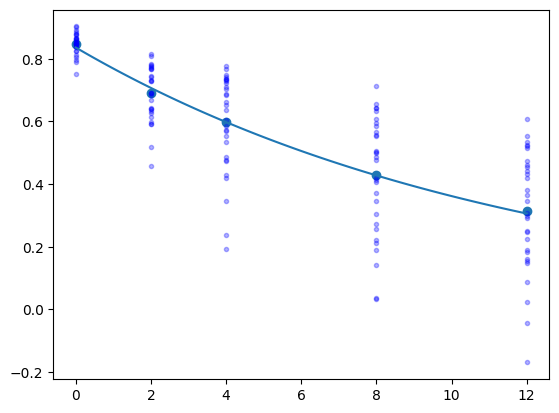

('Z', 'X', 'Z', 'I')
[0.84034956 0.88235492] 0.017179489989285705


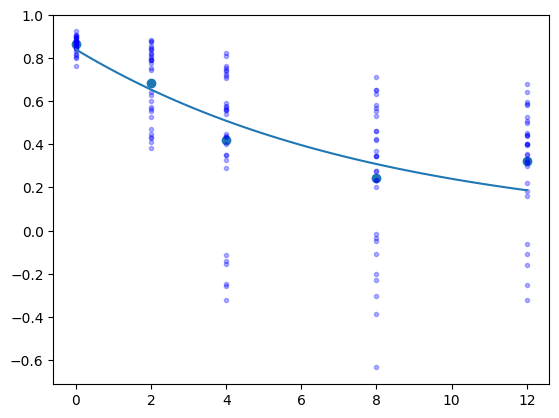

('Z', 'X', 'Z', 'X')
[0.83213422 0.83325928] 0.01357138753440682


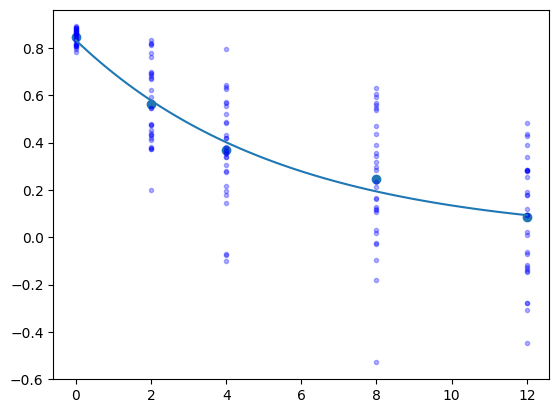

('Z', 'X', 'Z', 'Y')
[0.82018224 0.8314035 ] 0.017518794727986287


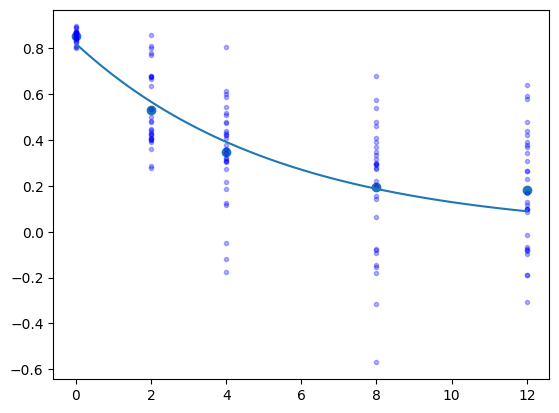

('Z', 'X', 'Z', 'Z')
[0.78755175 0.8809557 ] 0.013673155698741009


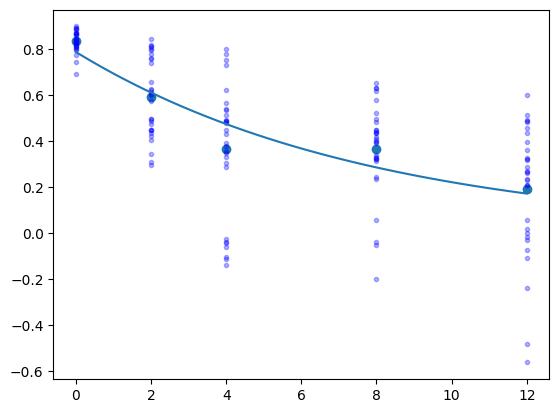

('Z', 'Y', 'I', 'I')
[0.88040091 0.87054911] 0.012668866979088488


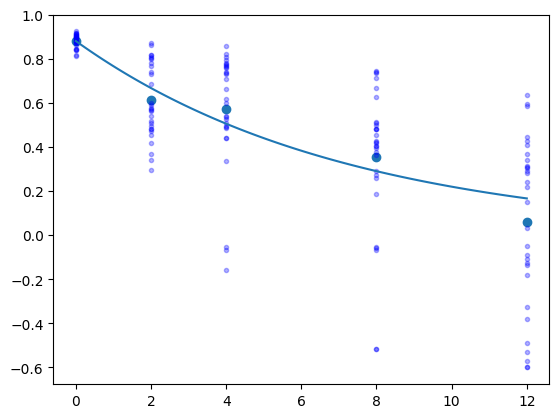

('Z', 'Y', 'I', 'X')
[0.85134365 0.81015552] 0.015190815191718835


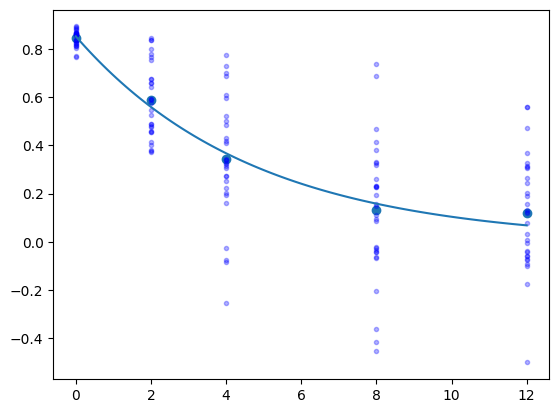

('Z', 'Y', 'I', 'Y')
[0.84867427 0.82318361] 0.012759153957398642


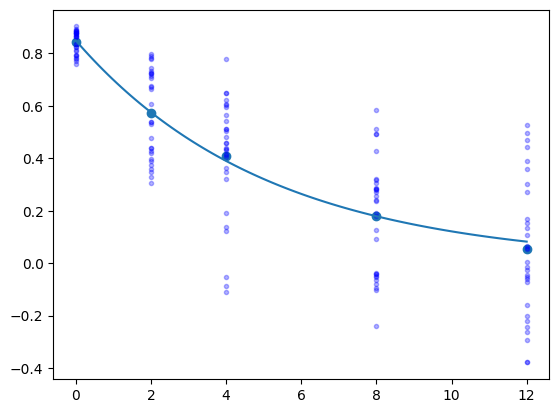

('Z', 'Y', 'I', 'Z')
[0.83716896 0.85953024] 0.014355139434669319


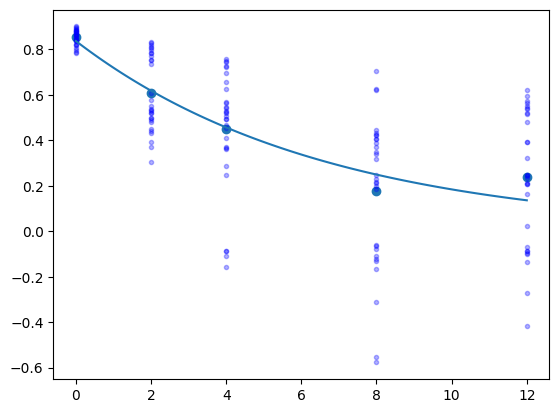

('Z', 'Y', 'X', 'I')
[0.85202972 0.91130179] 0.008839676954755984


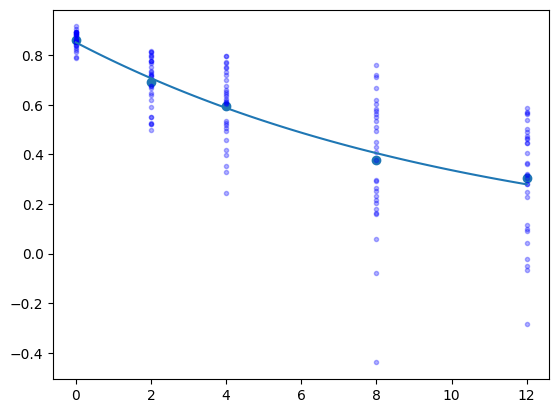

('Z', 'Y', 'X', 'X')
[0.83217858 0.9497918 ] 0.0025767994897301348


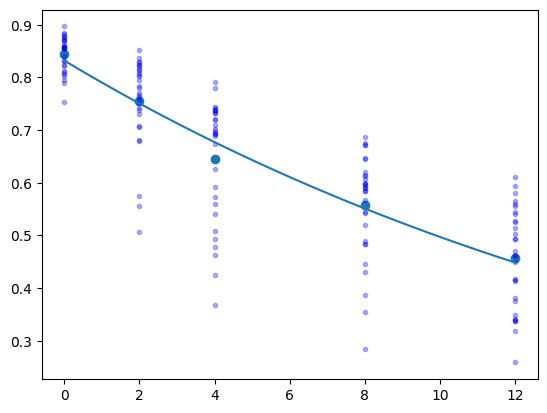

('Z', 'Y', 'X', 'Y')
[0.84986406 0.94769615] 0.0027853590865502408


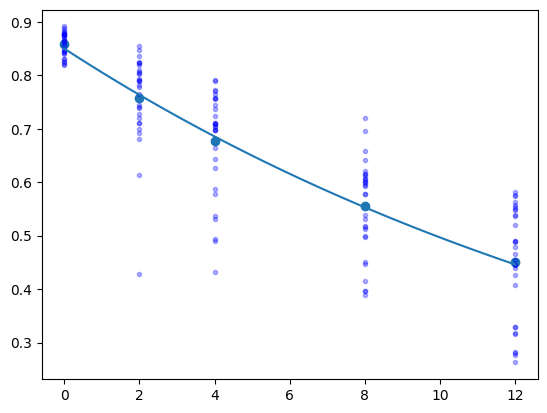

('Z', 'Y', 'X', 'Z')
[0.82675634 0.91192842] 0.007861063010153161


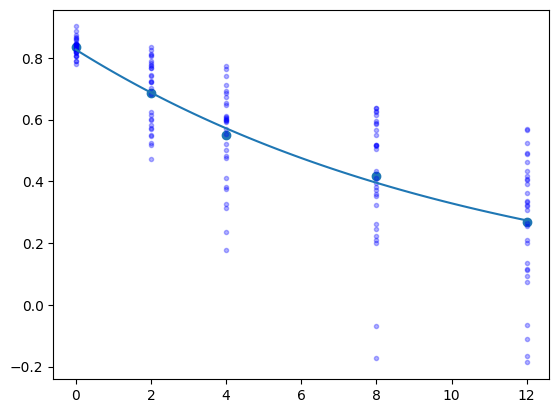

('Z', 'Y', 'Y', 'I')
[0.86877554 0.90385699] 0.00699772173964943


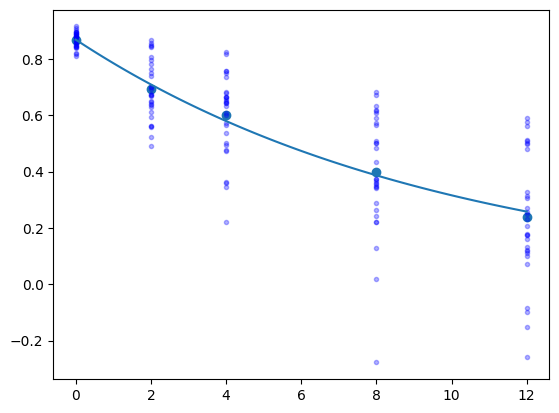

('Z', 'Y', 'Y', 'X')
[0.84040984 0.94431872] 0.0028006667896164424


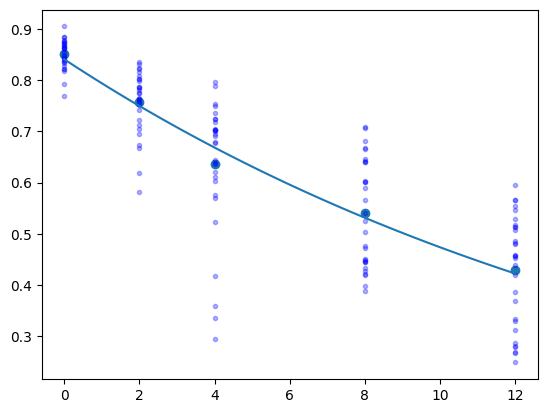

('Z', 'Y', 'Y', 'Y')
[0.81847567 0.95141236] 0.003880712766759651


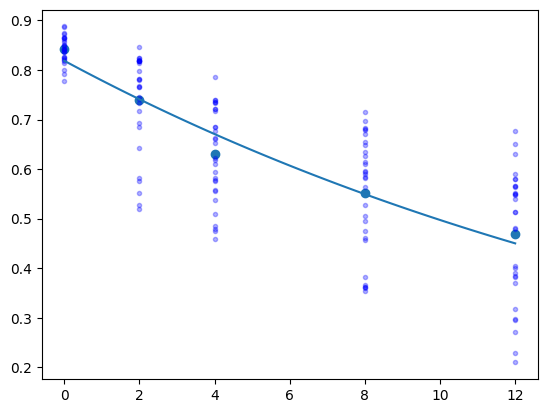

('Z', 'Y', 'Y', 'Z')
[0.86086373 0.89593674] 0.008280123450557878


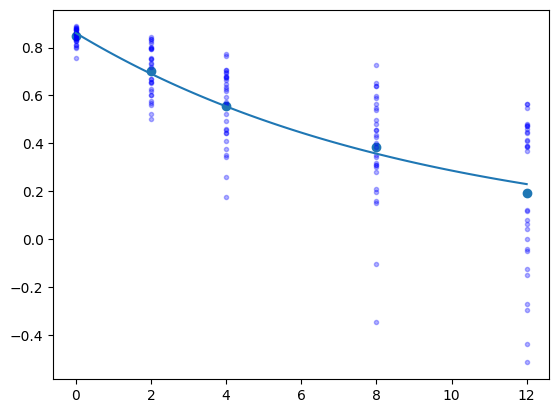

('Z', 'Y', 'Z', 'I')
[0.87959647 0.84109915] 0.019889102244233906


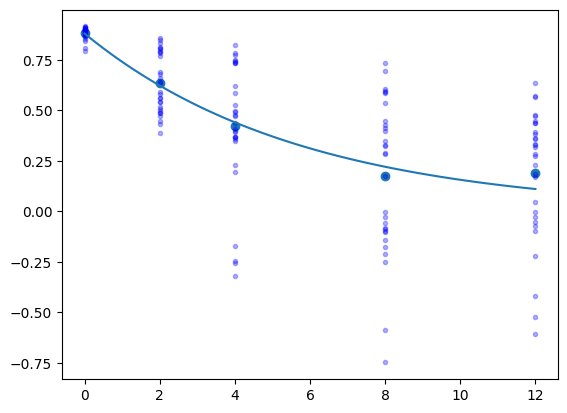

('Z', 'Y', 'Z', 'X')
[0.8674287  0.78673562] 0.01675325786316673


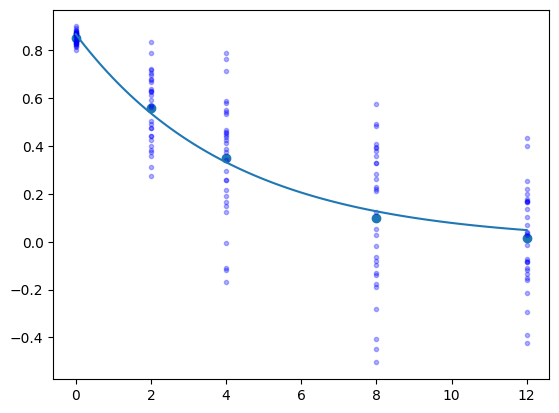

('Z', 'Y', 'Z', 'Y')
[0.85241193 0.82433509] 0.015784841068246746


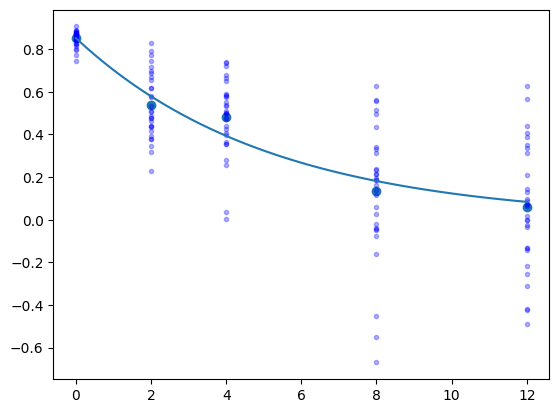

('Z', 'Y', 'Z', 'Z')
[0.84644991 0.85542291] 0.01382589503244566


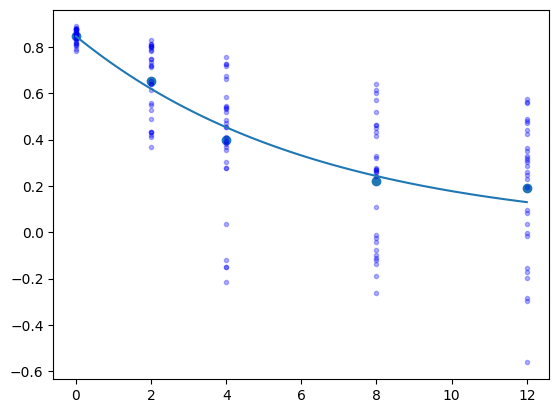

('Z', 'Z', 'I', 'I')
[0.86788804 0.95239835] 0.002748080355827262


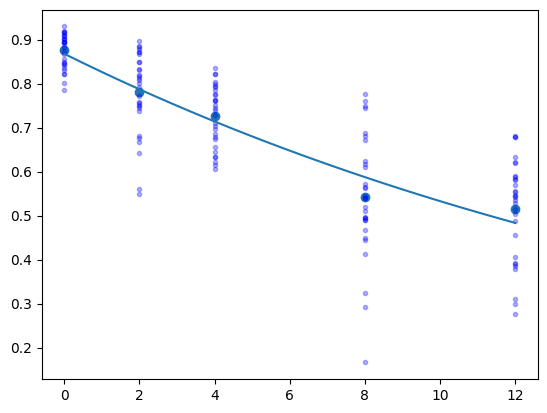

('Z', 'Z', 'I', 'X')
[0.86684993 0.90500077] 0.008162909196416192


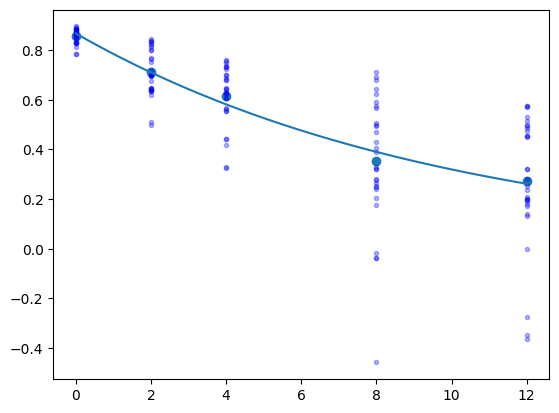

('Z', 'Z', 'I', 'Y')
[0.82708793 0.90552623] 0.008055364559995667


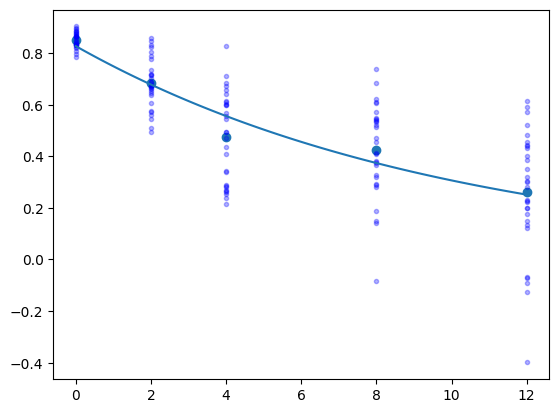

('Z', 'Z', 'I', 'Z')
[0.84663784 0.95375039] 0.0029415013359974733


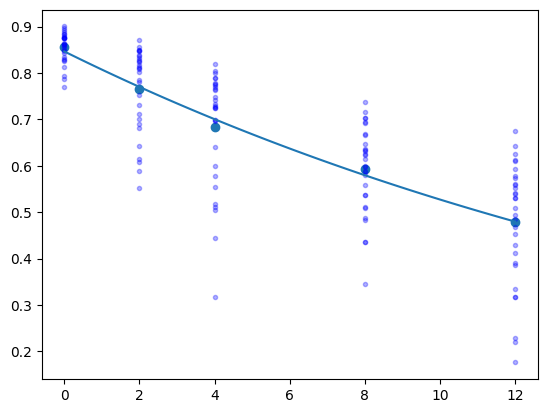

('Z', 'Z', 'X', 'I')
[0.84894107 0.79295863] 0.022367084941581388


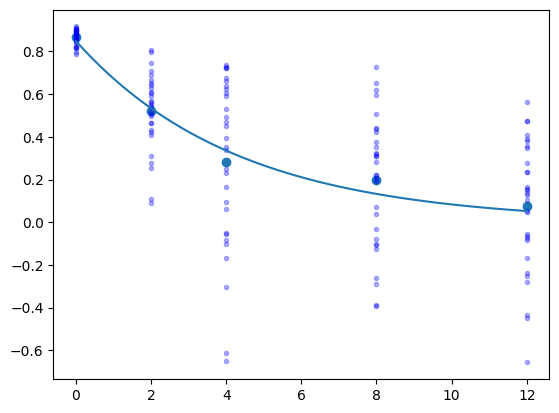

('Z', 'Z', 'X', 'X')
[0.82964183 0.84853028] 0.01713062628436461


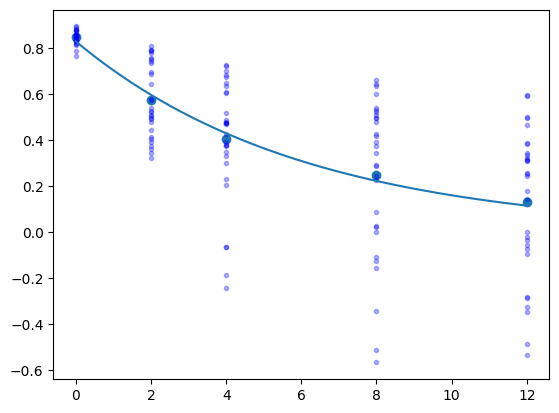

('Z', 'Z', 'X', 'Y')
[0.83786797 0.85625925] 0.015591479357682885


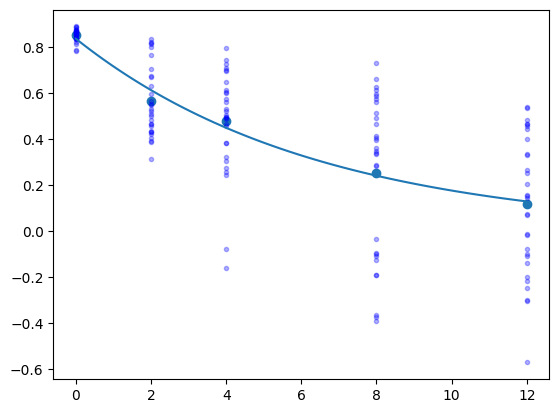

('Z', 'Z', 'X', 'Z')
[0.83204635 0.82348456] 0.019729203213459508


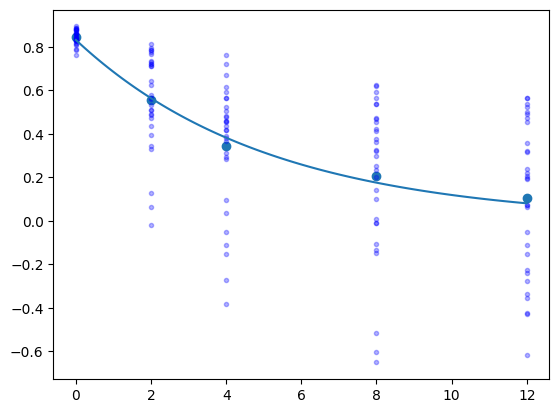

('Z', 'Z', 'Y', 'I')
[0.88535271 0.8267138 ] 0.019593152924928543


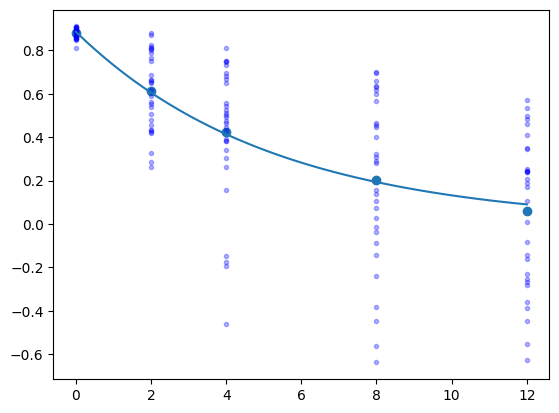

('Z', 'Z', 'Y', 'X')
[0.82486425 0.8553434 ] 0.015503515573671477


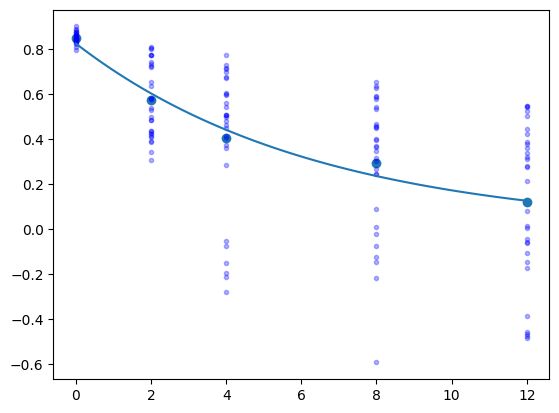

('Z', 'Z', 'Y', 'Y')
[0.84842286 0.85755295] 0.012074365909299492


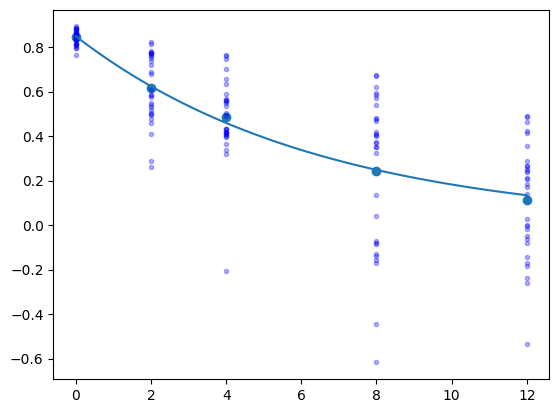

('Z', 'Z', 'Y', 'Z')
[0.86117528 0.80124625] 0.02195523581392983


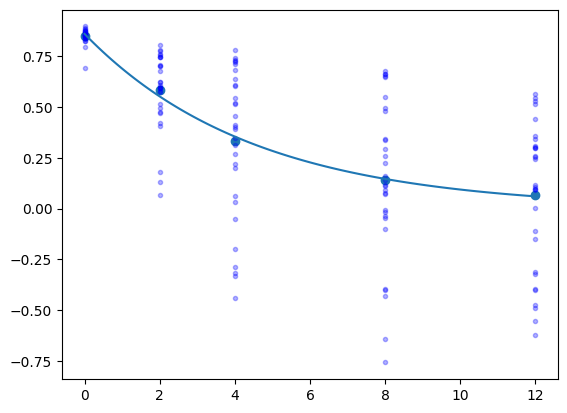

('Z', 'Z', 'Z', 'I')
[0.87544125 0.95106409] 0.003243554998984217


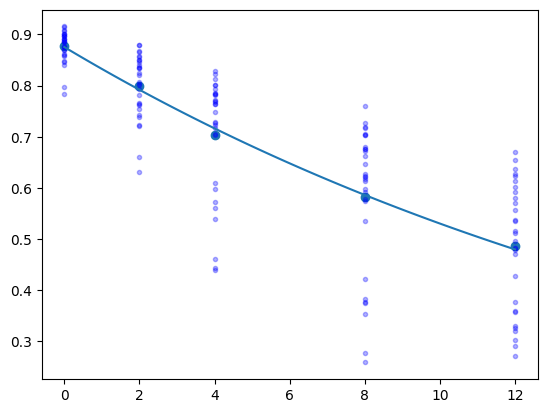

('Z', 'Z', 'Z', 'X')
[0.84963667 0.90344651] 0.009227032009131298


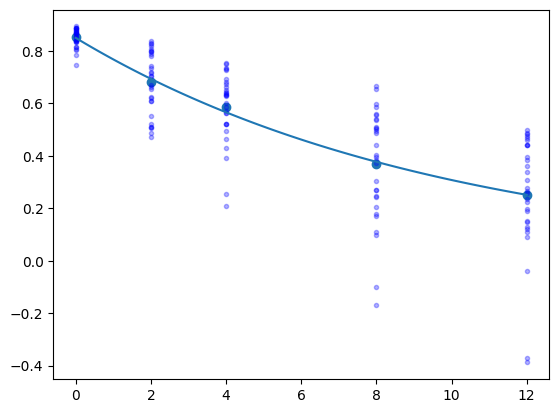

('Z', 'Z', 'Z', 'Y')
[0.85926457 0.89843912] 0.007976929949979351


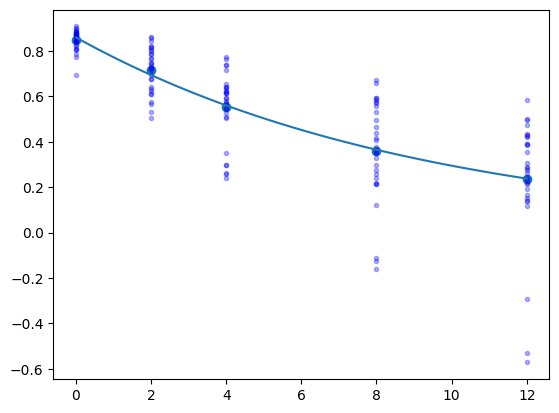

('Z', 'Z', 'Z', 'Z')
[0.8333421  0.94686548] 0.0033189558898869213


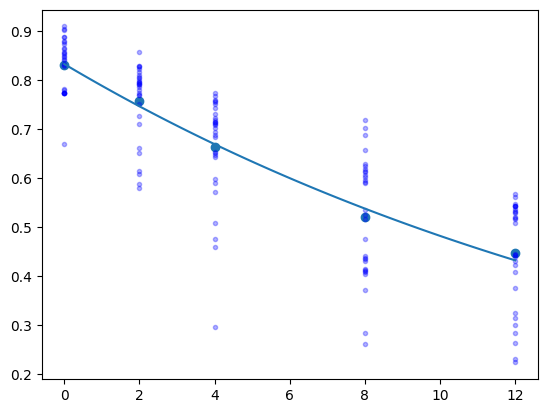

('I', 'I', 'I', 'I')
[0.98865563 0.97436853] 0.002920719522765116


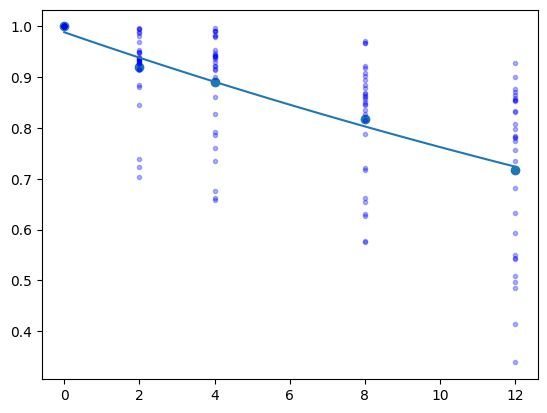

('I', 'I', 'I', 'X')
[0.97177873 0.90922378] 0.010171157893126536


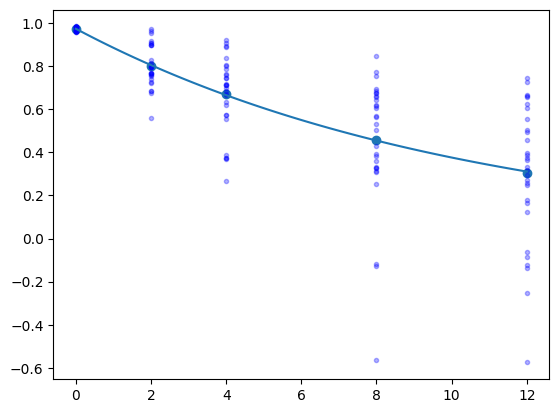

('I', 'I', 'I', 'Y')
[0.93576417 0.93295682] 0.008639716029397226


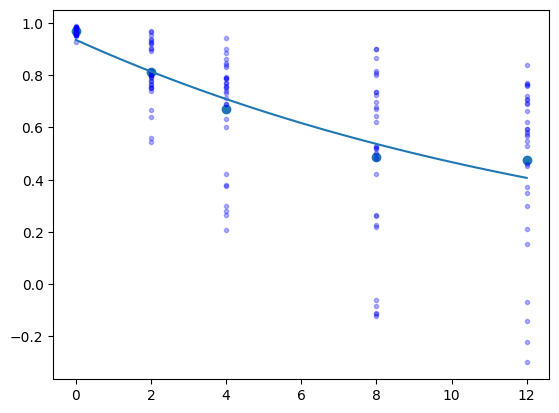

('I', 'I', 'I', 'Z')
[0.95904133 0.96561874] 0.0026951105303663404


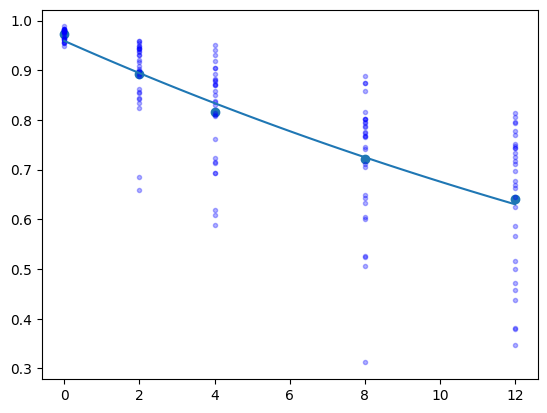

('I', 'I', 'X', 'I')
[0.97435761 0.8338447 ] 0.014363669374391933


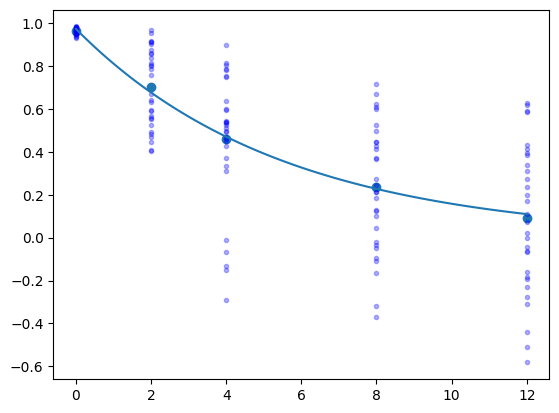

('I', 'I', 'X', 'X')
[0.92274525 0.87162237] 0.014640991439828202


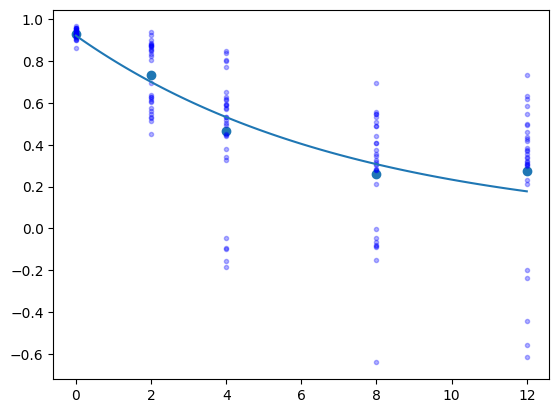

('I', 'I', 'X', 'Y')
[0.92129972 0.87025485] 0.01563790007483721


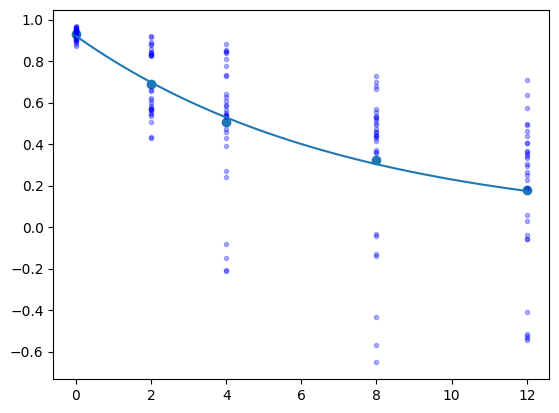

('I', 'I', 'X', 'Z')
[0.92102572 0.82505079] 0.020431321437766263


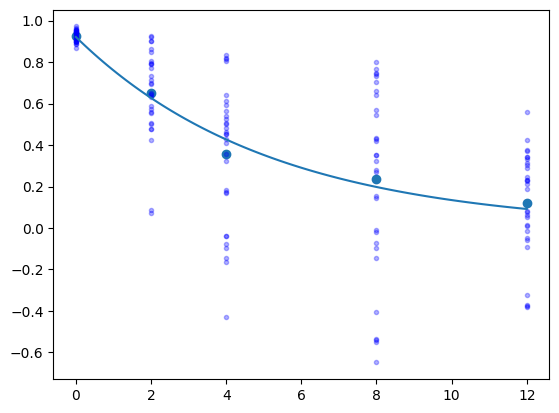

('I', 'I', 'Y', 'I')
[0.94629565 0.83923185] 0.015641229019793


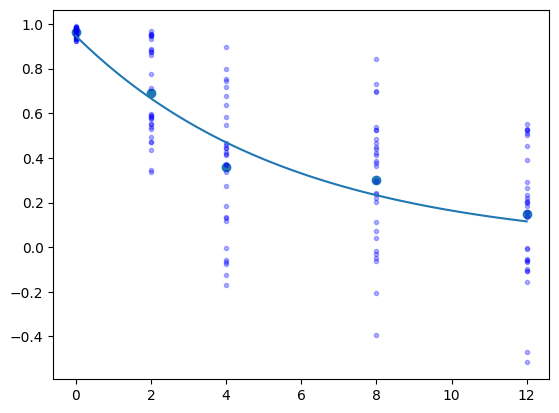

('I', 'I', 'Y', 'X')
[0.95270854 0.84383169] 0.015336630372863565


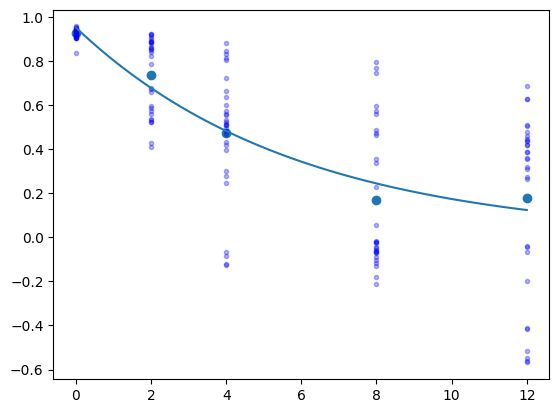

('I', 'I', 'Y', 'Y')
[0.93412321 0.86172746] 0.01477487420989887


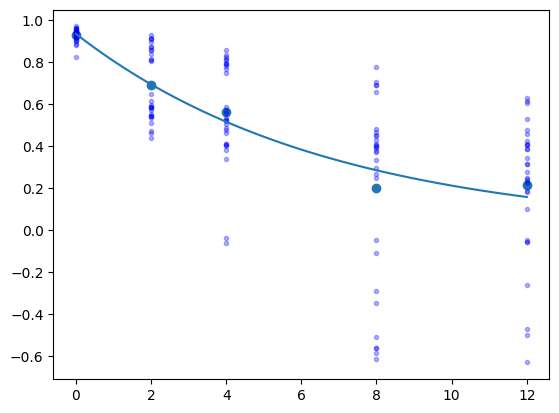

('I', 'I', 'Y', 'Z')
[0.9612887  0.84412757] 0.01275168128027931


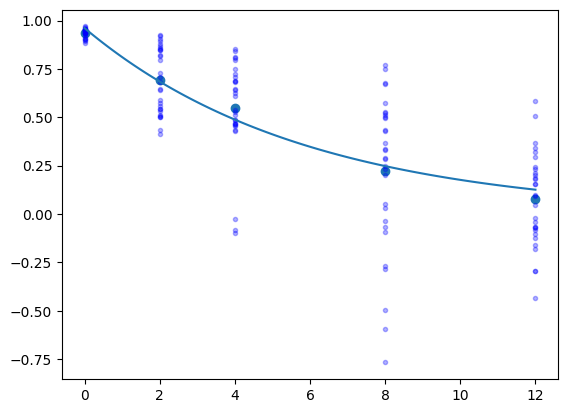

('I', 'I', 'Z', 'I')
[0.9358851  0.97092234] 0.002427283177458768


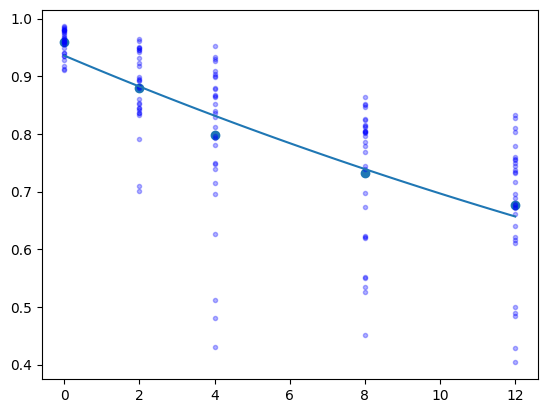

('I', 'I', 'Z', 'X')
[0.92510063 0.91518871] 0.00867316006639466


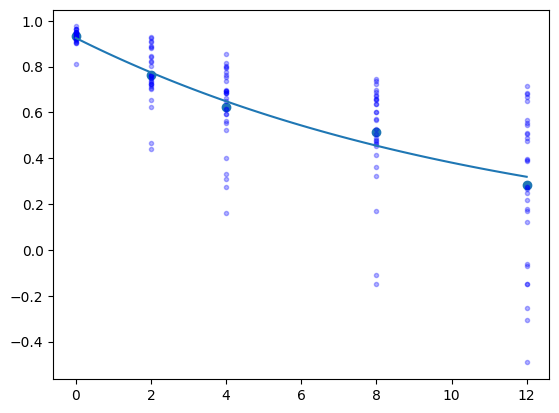

('I', 'I', 'Z', 'Y')
[0.93931318 0.90333731] 0.008165371746801207


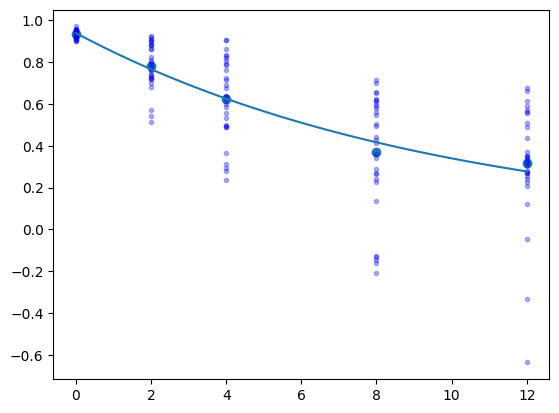

('I', 'I', 'Z', 'Z')
[0.91548185 0.96266332] 0.0022518929210743194


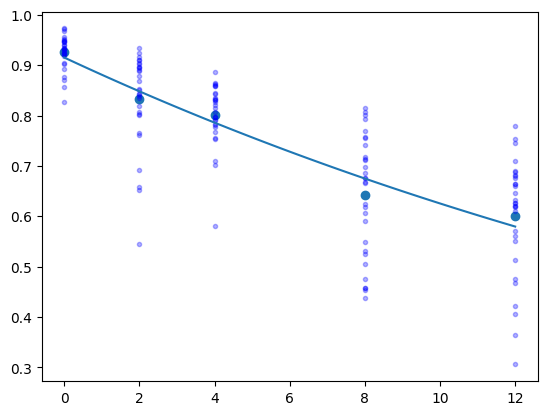

('I', 'X', 'I', 'I')
[0.90728326 0.87153235] 0.015804229472671173


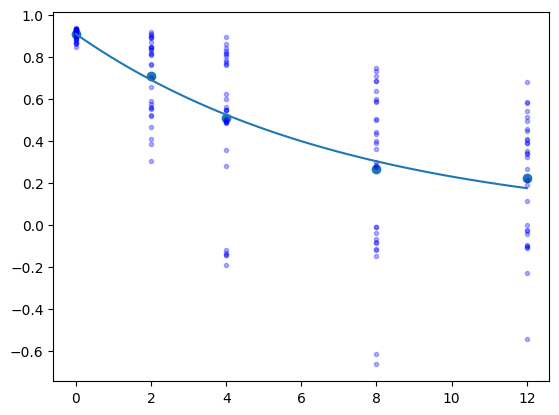

('I', 'X', 'I', 'X')
[0.86435636 0.84313806] 0.014596166164001346


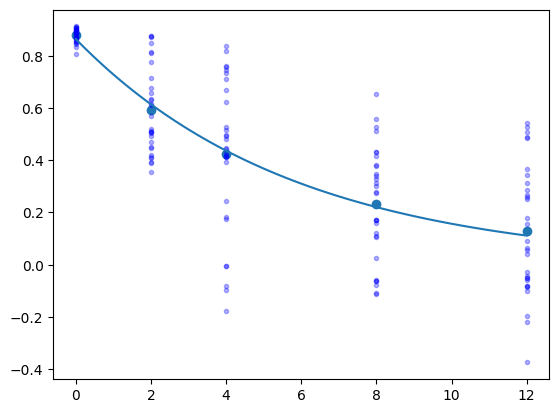

('I', 'X', 'I', 'Y')
[0.89289226 0.82121328] 0.013311038215308447


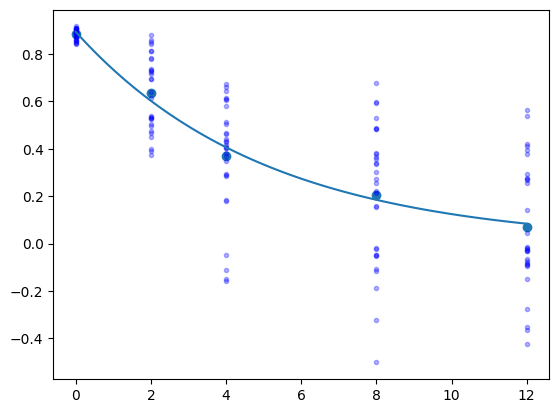

('I', 'X', 'I', 'Z')
[0.86781929 0.8774212 ] 0.012933982899741542


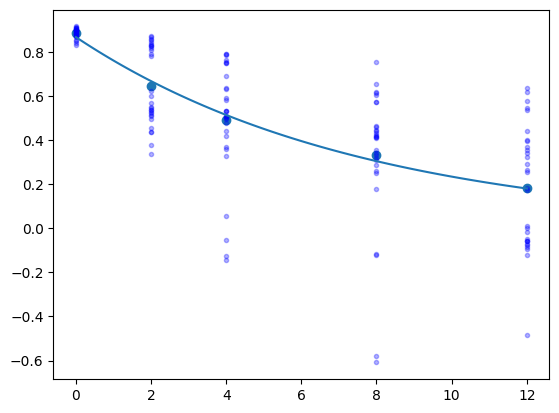

('I', 'X', 'X', 'I')
[0.86913054 0.90055413] 0.008165056257507764


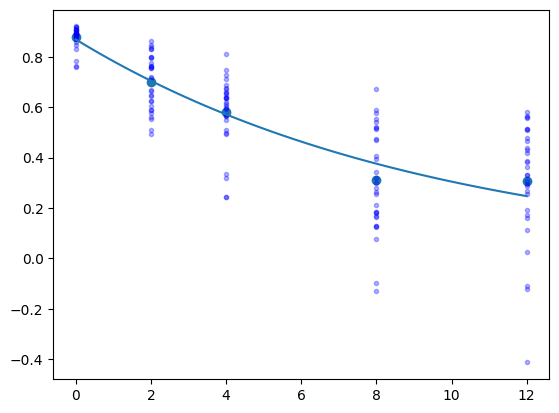

('I', 'X', 'X', 'X')
[0.86252973 0.94785852] 0.00225989679702239


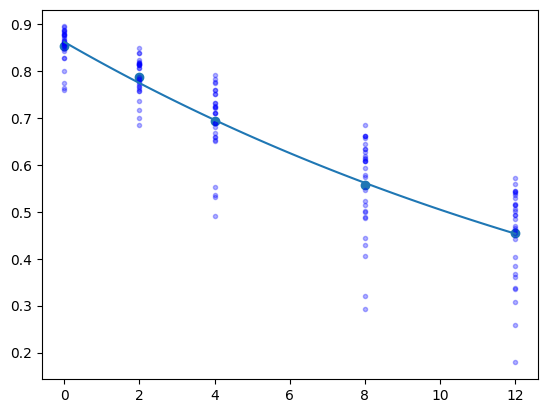

('I', 'X', 'X', 'Y')
[0.83174335 0.94821225] 0.0028133618940258103


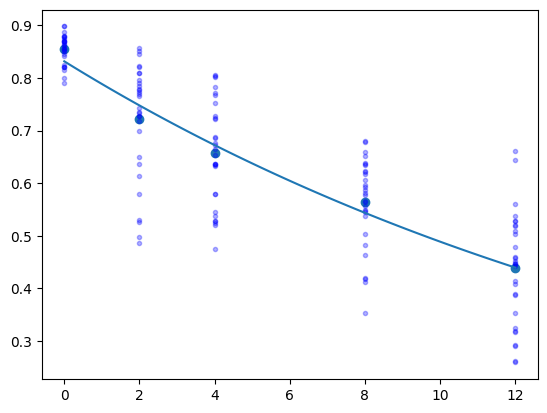

('I', 'X', 'X', 'Z')
[0.83843731 0.91088303] 0.007984099336545081


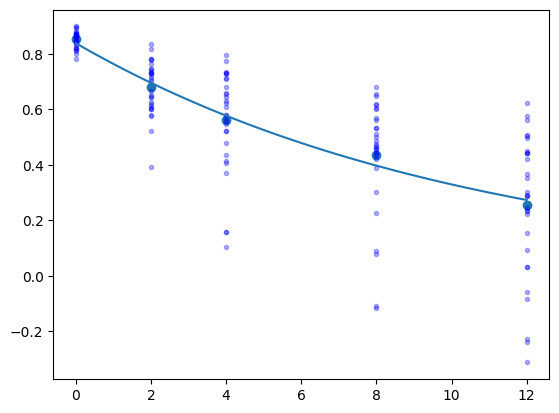

('I', 'X', 'Y', 'I')
[0.90627777 0.88691548] 0.008487622188612712


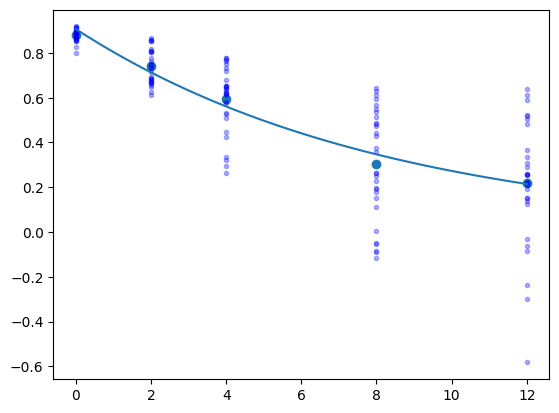

('I', 'X', 'Y', 'X')
[0.84917467 0.9476683 ] 0.003504158089584252


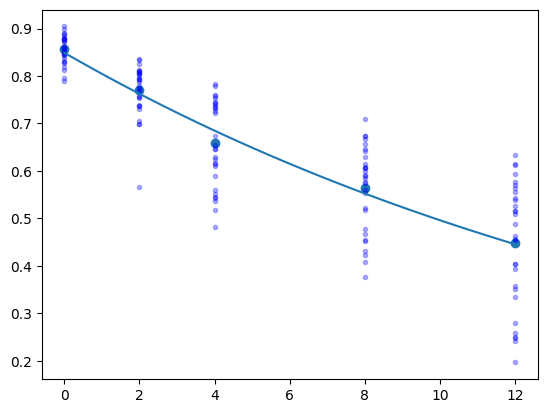

('I', 'X', 'Y', 'Y')
[0.85398299 0.94759614] 0.002538688986335649


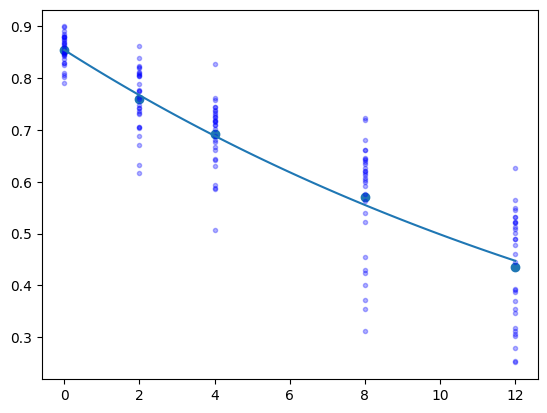

('I', 'X', 'Y', 'Z')
[0.84490105 0.91734238] 0.006767253690192016


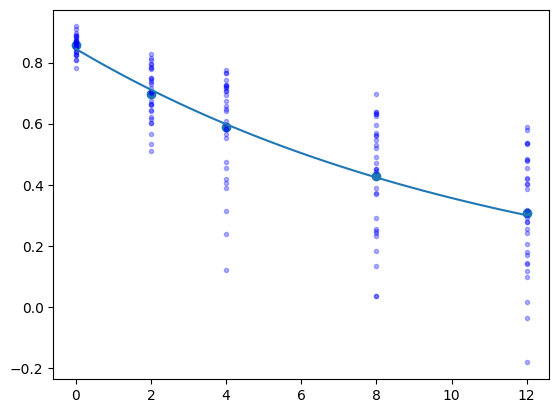

('I', 'X', 'Z', 'I')
[0.84238447 0.88516196] 0.017489213599180427


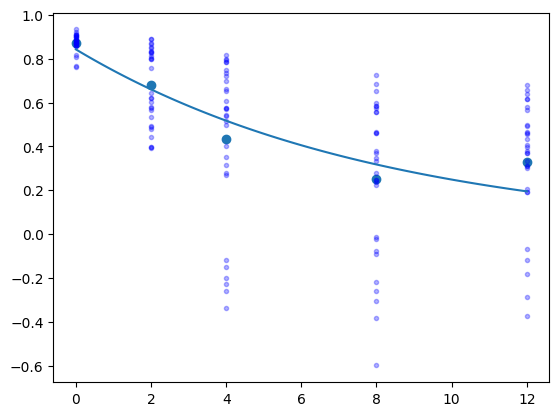

('I', 'X', 'Z', 'X')
[0.84189947 0.83028983] 0.014565471738070705


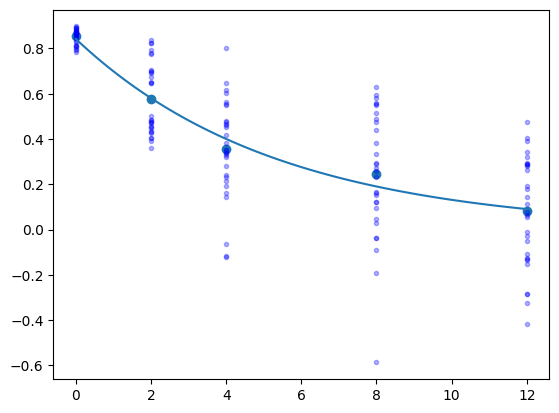

('I', 'X', 'Z', 'Y')
[0.8299367  0.83192889] 0.01906346583230035


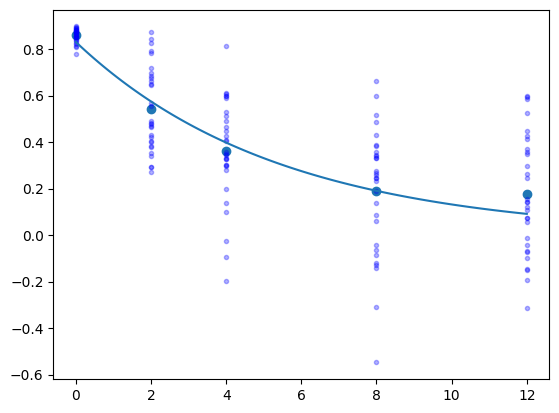

('I', 'X', 'Z', 'Z')
[0.80410486 0.88041913] 0.01204774804445908


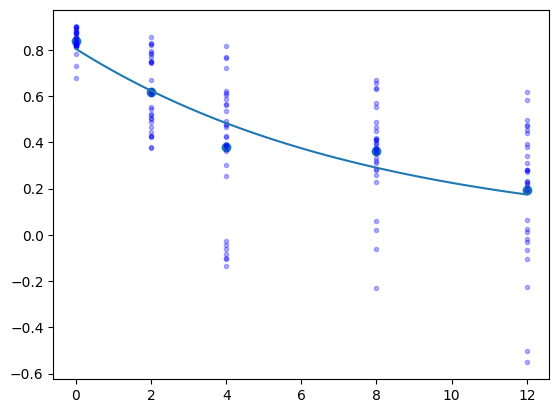

('I', 'Y', 'I', 'I')
[0.91779658 0.87179438] 0.01196646385088022


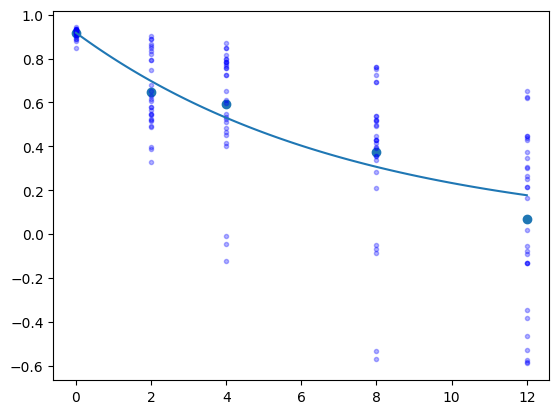

('I', 'Y', 'I', 'X')
[0.89211131 0.81428758] 0.015881109928972726


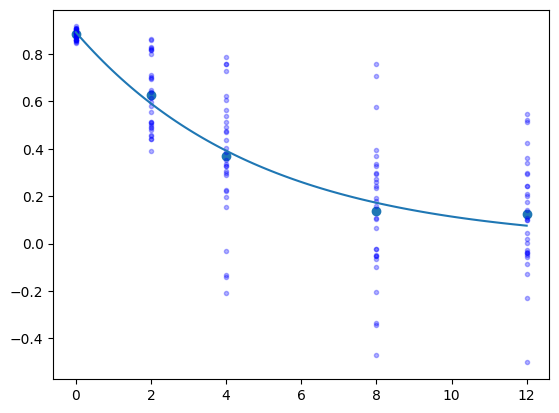

('I', 'Y', 'I', 'Y')
[0.88941146 0.82045074] 0.013029966165827108


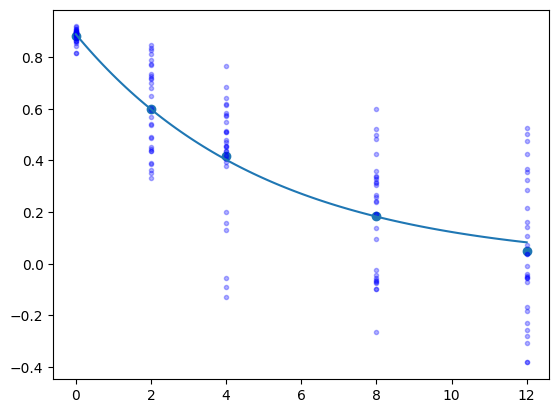

('I', 'Y', 'I', 'Z')
[0.87021461 0.86224616] 0.0157263467893089


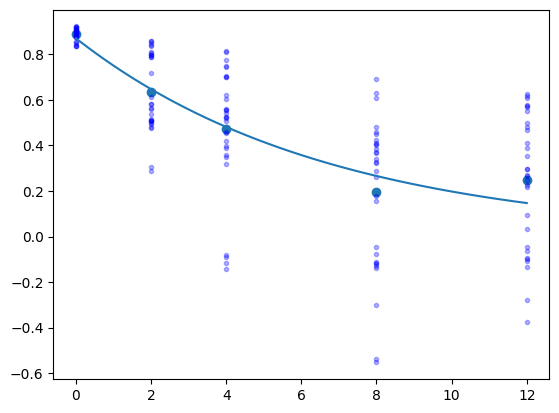

('I', 'Y', 'X', 'I')
[0.86818088 0.91225846] 0.00878081318099918


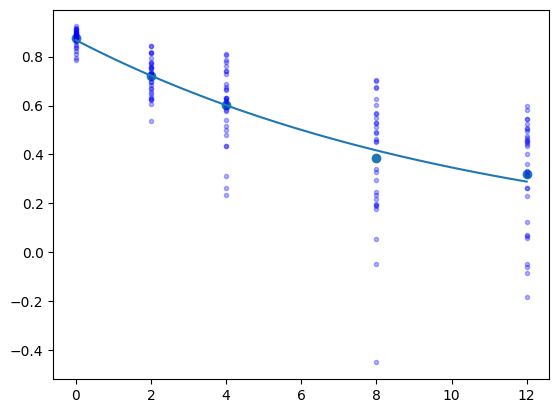

('I', 'Y', 'X', 'X')
[0.83961511 0.94919922] 0.002805612361384069


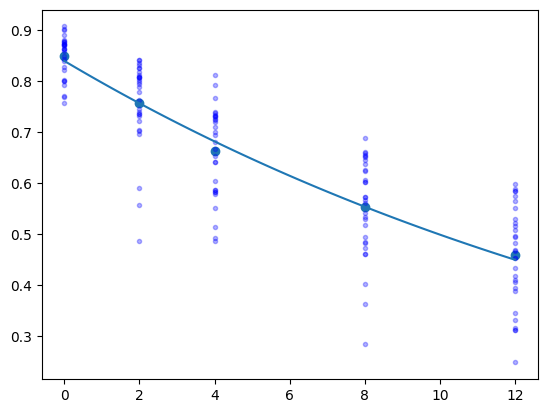

('I', 'Y', 'X', 'Y')
[0.85958274 0.94613286] 0.0029290050625131146


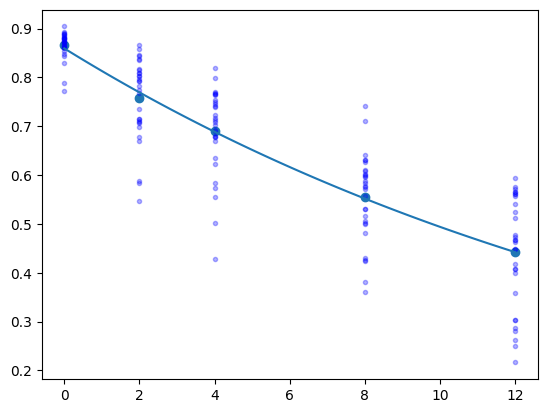

('I', 'Y', 'X', 'Z')
[0.83753098 0.91337322] 0.006901429074110111


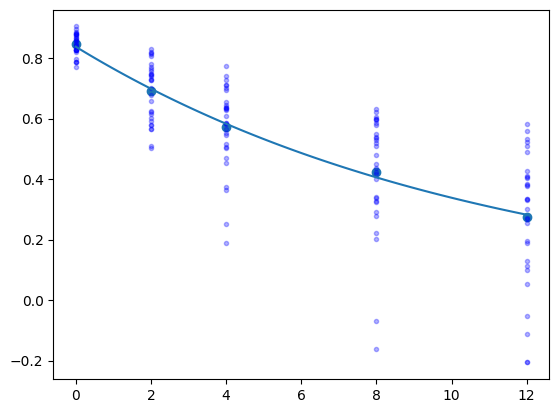

('I', 'Y', 'Y', 'I')
[0.87967791 0.90513978] 0.007098292248203431


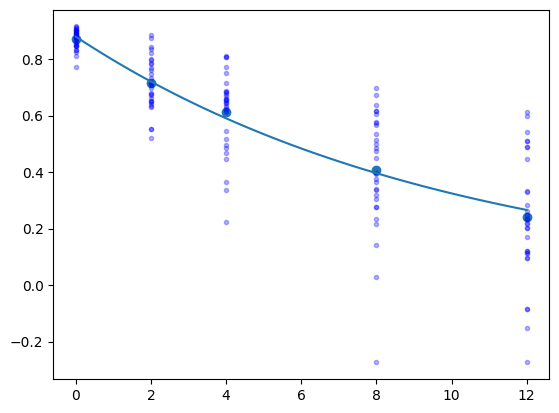

('I', 'Y', 'Y', 'X')
[0.84843761 0.94474139] 0.0028677087985628387


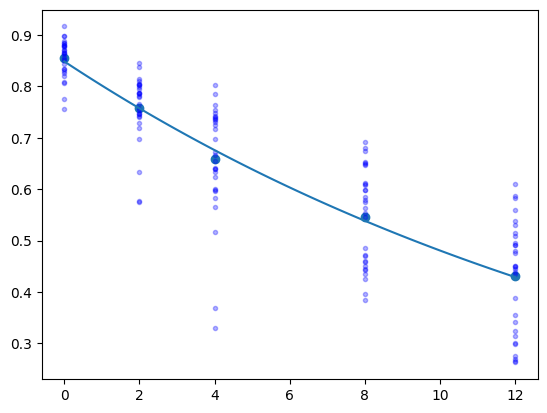

('I', 'Y', 'Y', 'Y')
[0.81801852 0.95082164] 0.0031573858428799464


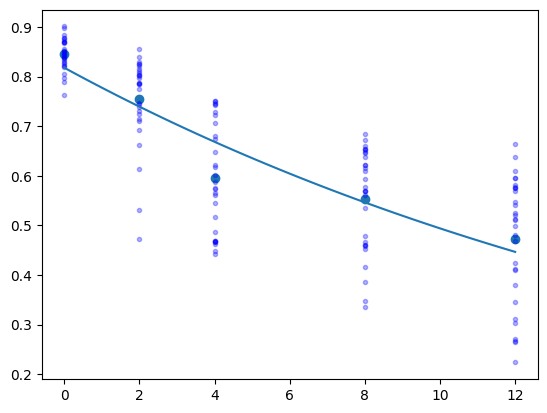

('I', 'Y', 'Y', 'Z')
[0.86552419 0.89319663] 0.008767902727512631


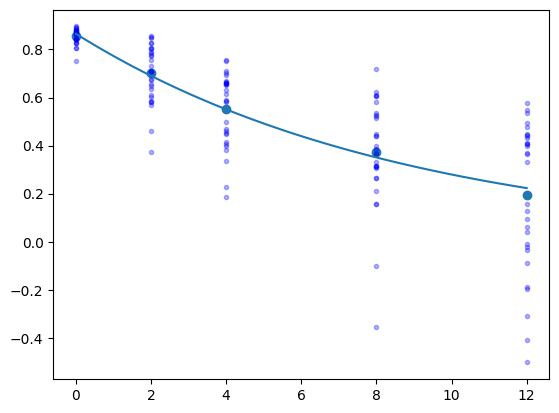

('I', 'Y', 'Z', 'I')
[0.8833755  0.84345615] 0.018712723800314524


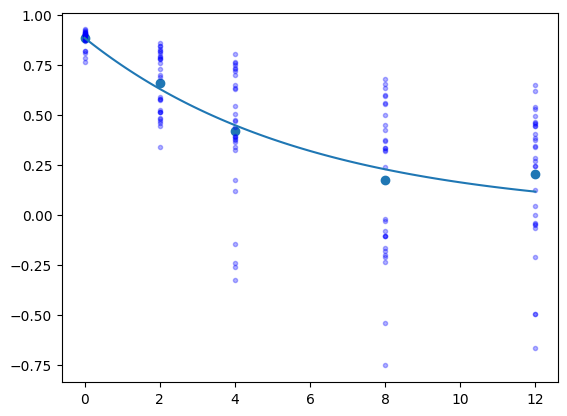

('I', 'Y', 'Z', 'X')
[0.87591002 0.78890721] 0.0150606788325631


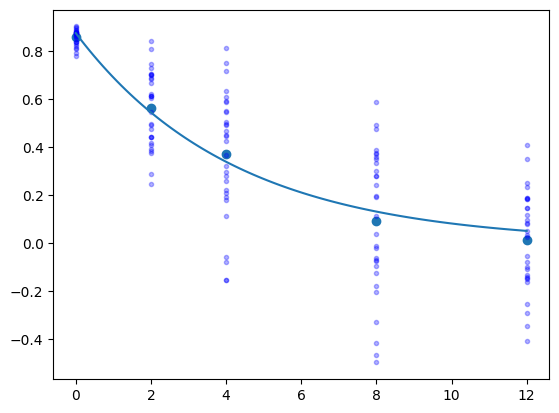

('I', 'Y', 'Z', 'Y')
[0.85730153 0.82416882] 0.014686855584066304


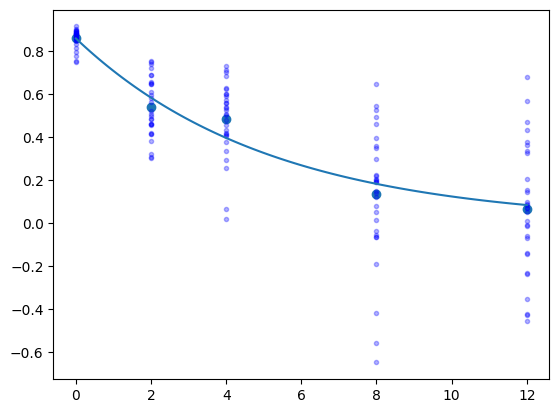

('I', 'Y', 'Z', 'Z')
[0.8518502  0.85708018] 0.015347172515170789


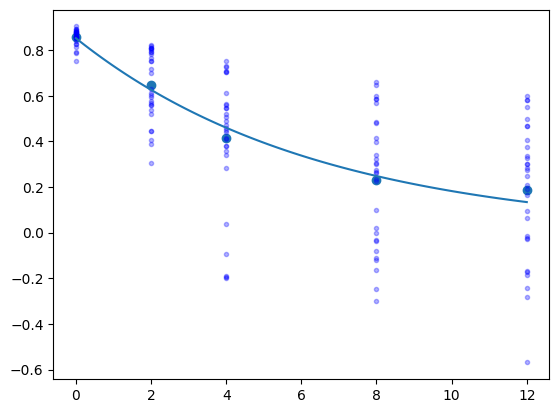

('I', 'Z', 'I', 'I')
[0.89341241 0.9504791 ] 0.003200772098072234


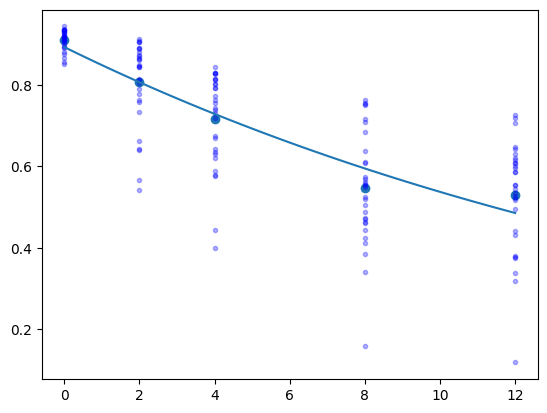

('I', 'Z', 'I', 'X')
[0.896281   0.90519845] 0.007696078306745693


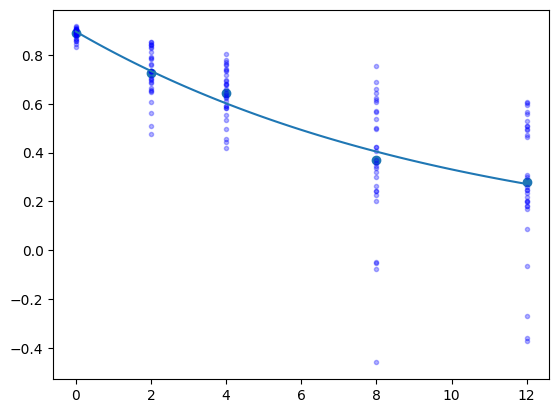

('I', 'Z', 'I', 'Y')
[0.86252943 0.90532293] 0.007700286911071627


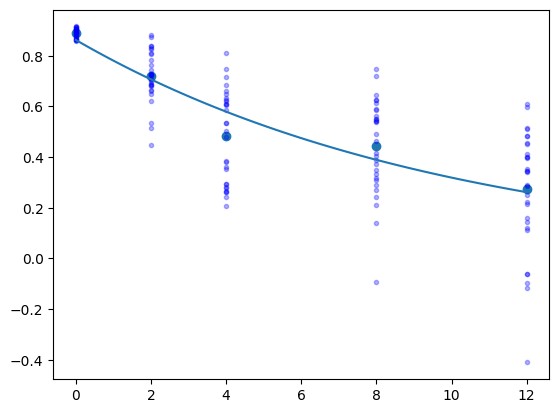

('I', 'Z', 'I', 'Z')
[0.87770475 0.95359255] 0.0029760592132361957


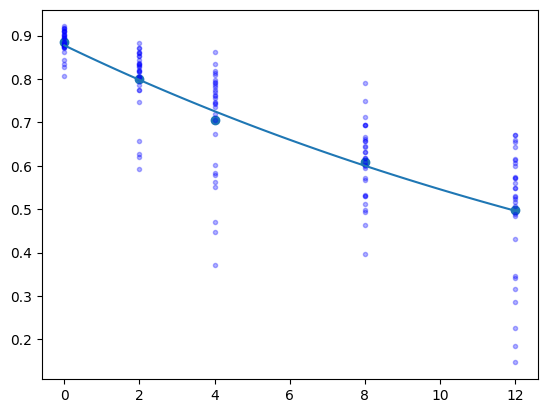

('I', 'Z', 'X', 'I')
[0.86090694 0.79529649] 0.024012875720235364


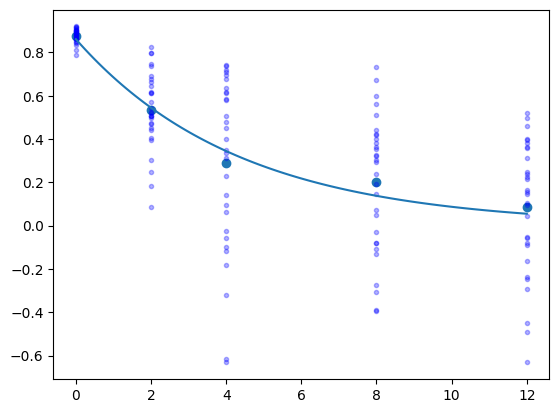

('I', 'Z', 'X', 'X')
[0.83566607 0.85037651] 0.015099004562154288


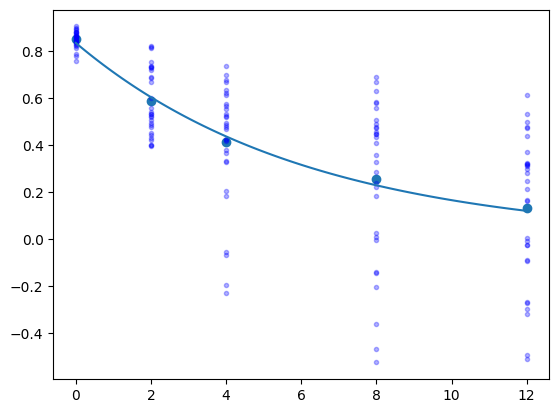

('I', 'Z', 'X', 'Y')
[0.84353368 0.85865325] 0.012982653680415688


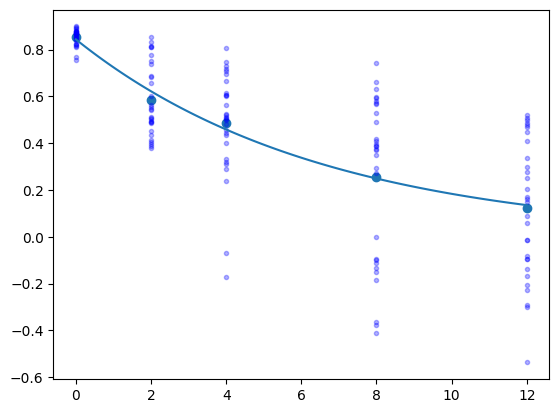

('I', 'Z', 'X', 'Z')
[0.84105514 0.82941782] 0.019775453731040924


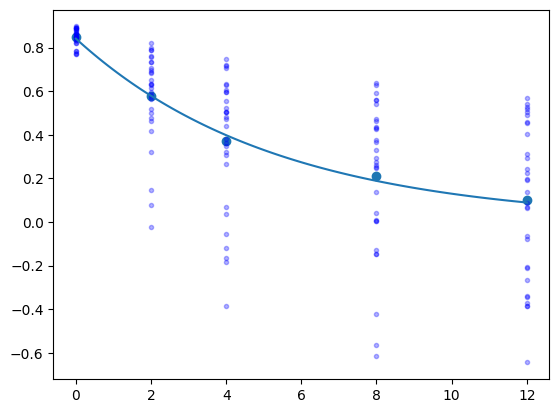

('I', 'Z', 'Y', 'I')
[0.89883245 0.82425567] 0.018533468110177708


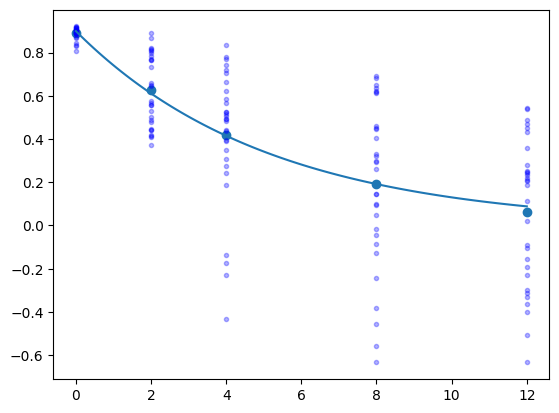

('I', 'Z', 'Y', 'X')
[0.82474984 0.85575263] 0.016031855035446876


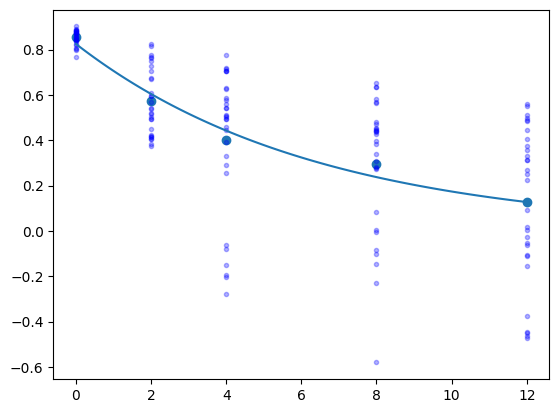

('I', 'Z', 'Y', 'Y')
[0.86500038 0.85876007] 0.011802910147931922


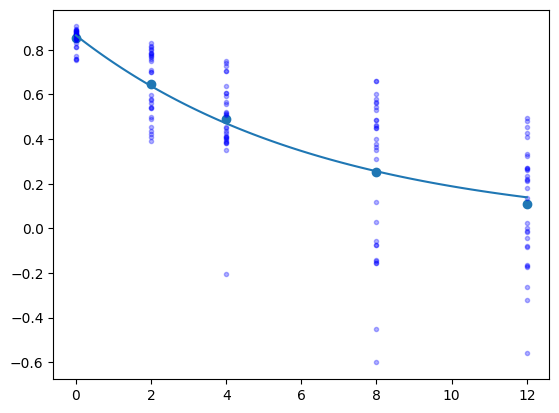

('I', 'Z', 'Y', 'Z')
[0.8693056  0.80081737] 0.022750530316781353


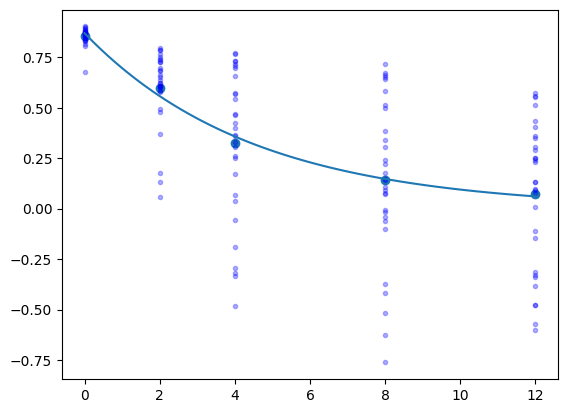

('I', 'Z', 'Z', 'I')
[0.87718296 0.95145017] 0.0028828629933780048


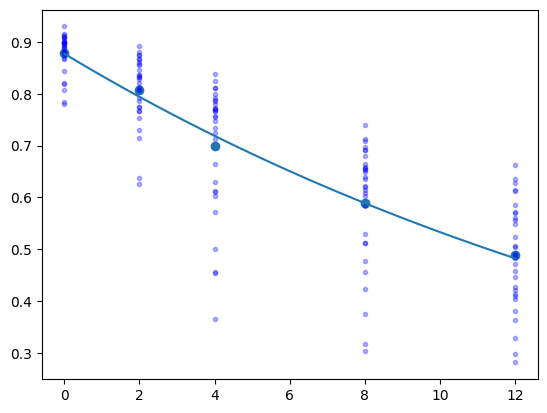

('I', 'Z', 'Z', 'X')
[0.86759166 0.90094017] 0.007194723180347947


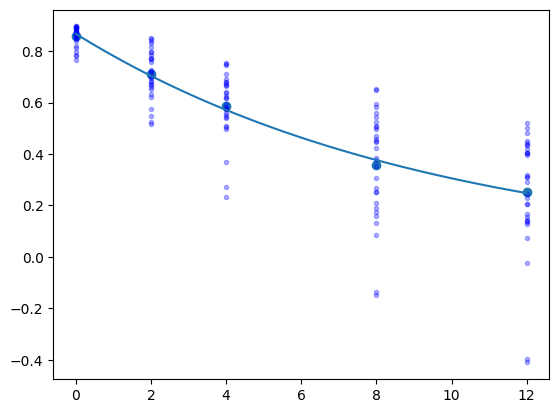

('I', 'Z', 'Z', 'Y')
[0.86656294 0.8956957 ] 0.00907282825164485


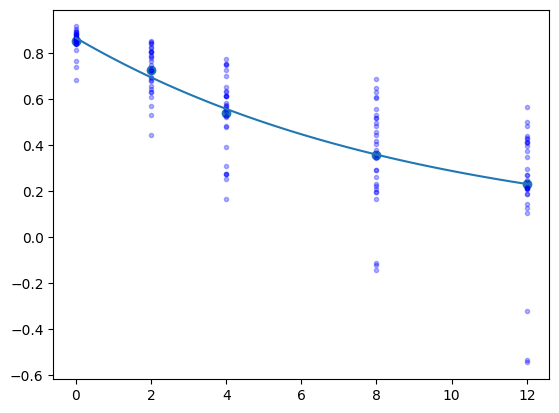

('I', 'Z', 'Z', 'Z')
[0.84907441 0.946828  ] 0.002700695055991638


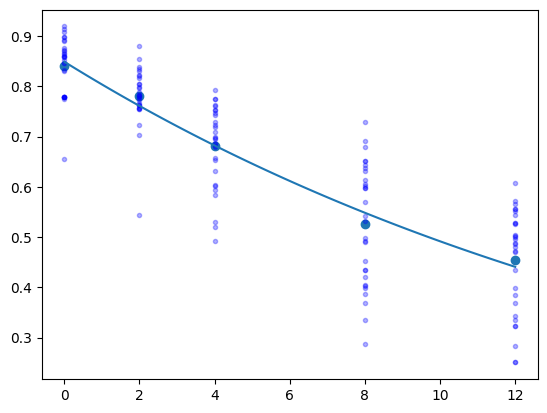

In [15]:
for p, energy_lists in circuit_alt_energies_by_pauli.items():
    print(p)
    means = [np.mean(l) for l in energy_lists]
    res = curve_fit(decay_form, depths, means, p0=[1,0.99])[0]
    eigs[(p,True)] = res[1]
    
    std = bootstrap_error(energy_lists, depths, bootstrap_samples=100, n_shots=5000)
    eigs_std[(p,True)] = std
    
    print(res, std)
    xs = np.linspace(0,12, 100)
    f = [decay_form(x, *res) for x in xs]
    plt.scatter(depths, means)
    plt.plot(xs, f)
    for d, elist in zip(depths, energy_lists):
        plt.scatter([d for _ in elist], elist, alpha=0.3, color='blue', marker='.')
    plt.show()

In [16]:
energy_lists = circuit_alt_energies_by_pauli[('Z', 'X', 'X', 'X')]
means = [np.mean(l) for l in energy_lists]
res = curve_fit(decay_form, depths, means, p0=[1,0.99])[0]

std = bootstrap_error(energy_lists, depths, bootstrap_samples=100, n_shots=5000)

print(res, std)

[0.84316533 0.94958993] 0.0025523087400796647


In [17]:
from matplotlib import colormaps
cmap = colormaps['Blues']

In [18]:
infs = {}
fstds = {}
for s in subsets:
    subset_paulis = compute_required_paulis(s, ['Q40'])
    fidelity = np.mean([eigs[(p, True)] for p in subset_paulis]+[eigs[(p, False)] for p in subset_paulis])
    f_std = np.mean([eigs_std[(p, True)] for p in subset_paulis]+[eigs_std[(p, False)] for p in subset_paulis])
    infs[s] = 1-fidelity
    fstds[s] = f_std
    print(s, 1-fidelity, f_std)

('Q40',) 0.02186826159300248 0.0025281588206184464
('Q41',) 0.07187038042979976 0.0077317811171699665
('Q42',) 0.0854269064450417 0.008210428944114532
('Q43',) 0.040317823777324735 0.0052690224625617866
('Q40', 'Q41') 0.07890483324964481 0.008140230411357176
('Q40', 'Q42') 0.09196580071910576 0.008679893668299372
('Q40', 'Q43') 0.050965880267646035 0.005896129330087317
('Q41', 'Q42') 0.10045481148773205 0.011118443766834126
('Q42', 'Q43') 0.09292147934002337 0.010458626762078066
('Q41', 'Q43') 0.09651469999370332 0.009794271687669834
('Q40', 'Q41', 'Q42') 0.10765996266746647 0.01131999901061087
('Q40', 'Q41', 'Q43') 0.10412634411022081 0.00998650768851694
('Q41', 'Q42', 'Q43') 0.10229642285901397 0.010663048403871476
('Q40', 'Q42', 'Q43') 0.10097306819827079 0.01078128330571448
('Q40', 'Q41', 'Q42', 'Q43') 0.10948565264412902 0.01082432373861939


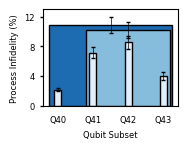

In [20]:
error_kwargs = {'elinewidth':0.5, 'capsize':1.5}
fig, ax = plt.subplots(1,1, figsize=(1.75,1.25))
exp = '07212021'

palette = [cmap(0.1+i/3) for i in range(4)]
ax.bar([5.5],[100*infs[('Q40', 'Q41', 'Q42', 'Q43')]],3.5, color=palette[2],yerr=[100*fstds[('Q40', 'Q41', 'Q42', 'Q43')]], edgecolor='black',error_kw=error_kwargs)
ax.bar([6],[100*infs[('Q41', 'Q42', 'Q43')]],2.4, color=palette[1], yerr=[100*fstds[('Q40','Q42','Q43')]], edgecolor='black',error_kw=error_kwargs)
ax.bar([4,5,6,7],[100*infs[('Q40',)], 100*infs[('Q41',)], 100*infs[('Q42',)], 100*infs[('Q43',)]], 0.2, color=palette[0], yerr=[100*fstds[('Q40',)], 100*fstds[('Q41',)], 100*fstds[('Q42',)], 100*fstds[('Q43',)]], edgecolor='black',error_kw=error_kwargs)

ax.set_xticks((4, 5, 6, 7))
for label in ax.get_yticklabels(): label.set_fontsize(6)
for label in ax.get_xticklabels(): label.set_fontsize(6)
ax.set_xticklabels(('Q40', 'Q41', 'Q42', 'Q43'),fontsize=6)
ax.set_xlabel('Qubit Subset', fontsize=6)
ax.set_ylabel(r'''Process Infidelity (%)''', fontsize=6)


ax.yaxis.set_tick_params(width=1, length=2) 

ax.xaxis.set_tick_params(width=0)
plt.yticks([0,4,8,12])
plt.ylim(0, 13)    

plt.savefig('4q_subset_fidelity.pdf')
plt.show()


In [21]:
#make a waterfall plot with this?

In [22]:
np.mean(list(eigs.values()))

0.890514347355871

In [23]:
np.std(list(eigs_std.values()))

0.006066872812182779

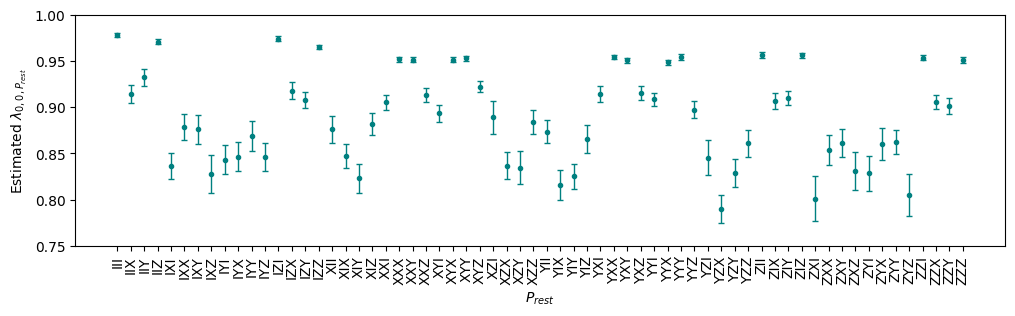

[('I', 'I', 'I'), ('I', 'I', 'Z'), ('I', 'Z', 'I'), ('I', 'Z', 'Z'), ('X', 'X', 'X'), ('X', 'X', 'Y'), ('X', 'Y', 'X'), ('X', 'Y', 'Y'), ('Y', 'X', 'X'), ('Y', 'X', 'Y'), ('Y', 'Y', 'Y'), ('Z', 'I', 'I'), ('Z', 'I', 'Z'), ('Z', 'Z', 'I'), ('Z', 'Z', 'Z')]
[('I', 'X', 'Z'), ('X', 'I', 'Y'), ('Y', 'I', 'X'), ('Y', 'I', 'Y'), ('Y', 'Z', 'X'), ('Y', 'Z', 'Y'), ('Z', 'X', 'I'), ('Z', 'Y', 'I'), ('Z', 'Y', 'Z')]


In [24]:
#try sorting by weight
plt.figure(figsize=(12,3))
xlabels = []
i = 0
largest_values = []
smallest_values = []
eigs_sorted = []
eig_sum_errs = []
for p in cs_by_pauli.keys():
    xlabels.append(''.join(p[1:]))
    #construct the keys we'll plot at this xvalue
    eig_sum = 0.25*(eigs[(('Z',)+p[1:], False)]+eigs[(('Z',)+p[1:], True)]+eigs[(('I',)+p[1:], False)]+eigs[(('I',)+p[1:], True)])
    eig_err = 0.25*(eigs_std[(('Z',)+p[1:], False)]+eigs_std[(('Z',)+p[1:], True)]+eigs_std[(('I',)+p[1:], False)]+eigs_std[(('I',)+p[1:], True)])
    eigs_sorted.append(eig_sum)
    eig_sum_errs.append(eig_err)
    plt.errorbar(i, eig_sum, color='teal', marker='.', yerr=eig_err, elinewidth=1, capsize=2)
    i += 1
    if eig_sum > 0.95:
        largest_values.append(p[1:])
    if eig_sum < 0.83:
        smallest_values.append(p[1:])
plt.xticks(range(len(xlabels)), xlabels, rotation=90)
plt.yticks([0.75, 0.80, 0.85, 0.90, 0.95, 1])
plt.ylabel(r'''Estimated $\lambda_{0,0,P_{rest}}$''')
plt.xlabel(r'''$P_{rest}$''')
#plt.savefig('ibm_osaka_05_19_T00')
plt.show()

print(largest_values)
print(smallest_values)

In [25]:
from scipy.linalg import hadamard
w = hadamard(4**3)

In [26]:
probs = (1/4**3)*(w @ eigs_sorted)

In [27]:
sum(eig_sum_errs)/4**3

0.010824323738619392

In [28]:
for pauli, prob in zip(cs_by_pauli.keys(), probs):
    if prob > 0.01:
        print(pauli, prob)

('Z', 'I', 'I', 'I') 0.890514347355871
('Z', 'I', 'Z', 'Z') 0.022151701691416205
('Z', 'Z', 'Z', 'I') 0.043499688296306696


In [29]:
for pauli, prob in zip(cs_by_pauli.keys(), probs):
    if 'X' not in pauli and 'Y' not in pauli:
        print(pauli[1:], prob)

('I', 'I', 'I') 0.890514347355871
('I', 'I', 'Z') 0.002345597800757465
('I', 'Z', 'I') 0.0026251666332492343
('I', 'Z', 'Z') 0.022151701691416205
('Z', 'I', 'I') 0.0009998543033639309
('Z', 'I', 'Z') 0.0014518624410849498
('Z', 'Z', 'I') 0.043499688296306696
('Z', 'Z', 'Z') -0.00038311896209513446


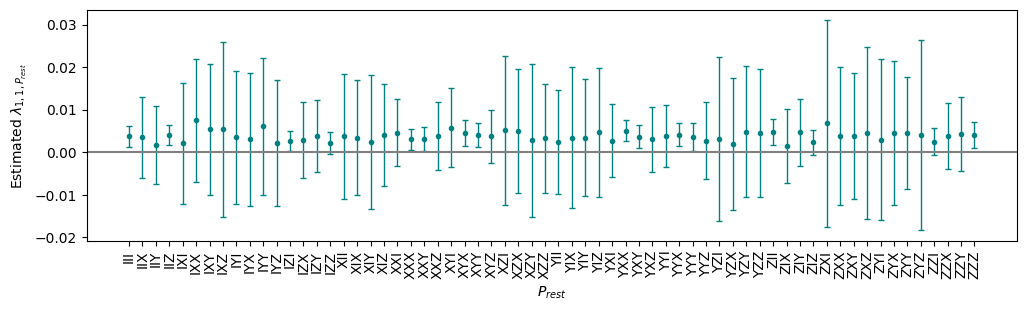

[('I', 'I', 'I'), ('I', 'I', 'Z'), ('I', 'Z', 'I'), ('I', 'Z', 'Z'), ('X', 'X', 'X'), ('X', 'X', 'Y'), ('X', 'Y', 'X'), ('X', 'Y', 'Y'), ('Y', 'X', 'X'), ('Y', 'X', 'Y'), ('Y', 'Y', 'Y'), ('Z', 'I', 'I'), ('Z', 'I', 'Z'), ('Z', 'Z', 'I'), ('Z', 'Z', 'Z')]
[('I', 'X', 'Z'), ('X', 'I', 'Y'), ('Y', 'I', 'X'), ('Y', 'I', 'Y'), ('Y', 'Z', 'X'), ('Y', 'Z', 'Y'), ('Z', 'X', 'I'), ('Z', 'Y', 'I'), ('Z', 'Y', 'Z'), ('I', 'I', 'I'), ('I', 'I', 'X'), ('I', 'I', 'Y'), ('I', 'I', 'Z'), ('I', 'X', 'I'), ('I', 'X', 'X'), ('I', 'X', 'Y'), ('I', 'X', 'Z'), ('I', 'Y', 'I'), ('I', 'Y', 'X'), ('I', 'Y', 'Y'), ('I', 'Y', 'Z'), ('I', 'Z', 'I'), ('I', 'Z', 'X'), ('I', 'Z', 'Y'), ('I', 'Z', 'Z'), ('X', 'I', 'I'), ('X', 'I', 'X'), ('X', 'I', 'Y'), ('X', 'I', 'Z'), ('X', 'X', 'I'), ('X', 'X', 'X'), ('X', 'X', 'Y'), ('X', 'X', 'Z'), ('X', 'Y', 'I'), ('X', 'Y', 'X'), ('X', 'Y', 'Y'), ('X', 'Y', 'Z'), ('X', 'Z', 'I'), ('X', 'Z', 'X'), ('X', 'Z', 'Y'), ('X', 'Z', 'Z'), ('Y', 'I', 'I'), ('Y', 'I', 'X'), ('Y', 'I', '

In [30]:
#try sorting by weight
plt.figure(figsize=(12,3))
xlabels = []
i = 0
eigs_sorted = []
eig_sum_errs = []
for p in cs_by_pauli.keys():
    xlabels.append(''.join(p[1:]))
    #construct the keys we'll plot at this xvalue
    eig_sum = 0.25*(eigs[(('Z',)+p[1:], False)]-eigs[(('Z',)+p[1:], True)]+eigs[(('I',)+p[1:], False)]-eigs[(('I',)+p[1:], True)])
    eig_err = 0.25*(eigs_std[(('Z',)+p[1:], False)]+eigs_std[(('Z',)+p[1:], True)]+eigs_std[(('I',)+p[1:], False)]+eigs_std[(('I',)+p[1:], True)])
    plt.errorbar(i, eig_sum, color='teal', marker='.', yerr=eig_err, elinewidth=1, capsize=2)
    eigs_sorted.append(eig_sum)
    eig_sum_errs.append(eig_err)
    i += 1
    if eig_sum > 0.95:
        largest_values.append(p[1:])
    if eig_sum < 0.83:
        smallest_values.append(p[1:])
plt.xticks(range(len(xlabels)), xlabels, rotation=90)
plt.axhline(0, color='gray')
#plt.yticks([0.75, 0.80, 0.85, 0.90, 0.95, 1])
plt.ylabel(r'''Estimated $\lambda_{1,1,P_{rest}}$''')
plt.xlabel(r'''$P_{rest}$''')
#plt.savefig('ibm_osaka_05_19_T11')
plt.show()

print(largest_values)
print(smallest_values)

In [31]:
probs = (1/4**3)*(w @ eigs_sorted)

In [32]:
sum(eig_sum_errs)/4**3

0.010824323738619392

In [33]:
for pauli, prob in zip(cs_by_pauli.keys(), probs):
    if prob > 0.00078:
        print(pauli, prob)

('Z', 'I', 'I', 'I') 0.003815199549366686


In [34]:
for pauli, prob in zip(cs_by_pauli.keys(), probs):
    if 'X' not in pauli and 'Y'not in pauli:
        print(pauli[1:], prob)

('I', 'I', 'I') 0.003815199549366686
('I', 'I', 'Z') -6.551191596393738e-05
('I', 'Z', 'I') -0.00032306826514141244
('I', 'Z', 'Z') 0.0001855306643413204
('Z', 'I', 'I') 4.508410030164452e-05
('Z', 'I', 'Z') -0.00015531015720682967
('Z', 'Z', 'I') -0.00022590378516634205
('Z', 'Z', 'Z') 4.189159268985863e-05


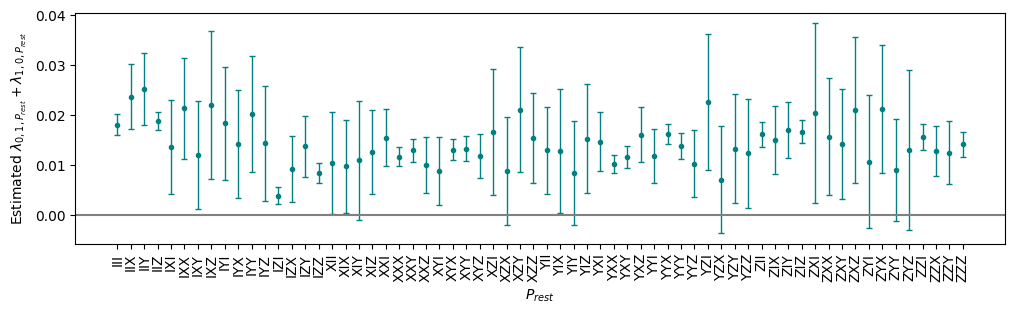

[]
[('I', 'I', 'I'), ('I', 'I', 'X'), ('I', 'I', 'Y'), ('I', 'I', 'Z'), ('I', 'X', 'I'), ('I', 'X', 'X'), ('I', 'X', 'Y'), ('I', 'X', 'Z'), ('I', 'Y', 'I'), ('I', 'Y', 'X'), ('I', 'Y', 'Y'), ('I', 'Y', 'Z'), ('I', 'Z', 'I'), ('I', 'Z', 'X'), ('I', 'Z', 'Y'), ('I', 'Z', 'Z'), ('X', 'I', 'I'), ('X', 'I', 'X'), ('X', 'I', 'Y'), ('X', 'I', 'Z'), ('X', 'X', 'I'), ('X', 'X', 'X'), ('X', 'X', 'Y'), ('X', 'X', 'Z'), ('X', 'Y', 'I'), ('X', 'Y', 'X'), ('X', 'Y', 'Y'), ('X', 'Y', 'Z'), ('X', 'Z', 'I'), ('X', 'Z', 'X'), ('X', 'Z', 'Y'), ('X', 'Z', 'Z'), ('Y', 'I', 'I'), ('Y', 'I', 'X'), ('Y', 'I', 'Y'), ('Y', 'I', 'Z'), ('Y', 'X', 'I'), ('Y', 'X', 'X'), ('Y', 'X', 'Y'), ('Y', 'X', 'Z'), ('Y', 'Y', 'I'), ('Y', 'Y', 'X'), ('Y', 'Y', 'Y'), ('Y', 'Y', 'Z'), ('Y', 'Z', 'I'), ('Y', 'Z', 'X'), ('Y', 'Z', 'Y'), ('Y', 'Z', 'Z'), ('Z', 'I', 'I'), ('Z', 'I', 'X'), ('Z', 'I', 'Y'), ('Z', 'I', 'Z'), ('Z', 'X', 'I'), ('Z', 'X', 'X'), ('Z', 'X', 'Y'), ('Z', 'X', 'Z'), ('Z', 'Y', 'I'), ('Z', 'Y', 'X'), ('Z', 'Y',

In [35]:
#try sorting by weight
plt.figure(figsize=(12,3))
xlabels = []
i = 0
largest_values = []
smallest_values = []
eigs_sorted = []
eig_sum_errs = []
for p in cs_by_pauli.keys():
    xlabels.append(''.join(p[1:]))
    #construct the keys we'll plot at this xvalue
    eig_sum = 0.5*(-1*eigs[(('Z',)+p[1:], False)]+eigs[(('I',)+p[1:], False)])
    eig_err = 0.5*np.sqrt(eigs_std[(('Z',)+p[1:], False)]**2+eigs_std[(('I',)+p[1:], False)]**2)
    plt.errorbar(i, eig_sum, color='teal', marker='.', yerr=eig_err, elinewidth=1, capsize=2)
    eigs_sorted.append(eig_sum)
    eig_sum_errs.append(eig_err)
    i += 1
    if eig_sum > 0.95:
        largest_values.append(p[1:])
    if eig_sum < 0.83:
        smallest_values.append(p[1:])
plt.xticks(range(len(xlabels)), xlabels, rotation=90)
plt.axhline(0, color='gray')
plt.ylabel(r'''Estimated $\lambda_{0,1,P_{rest}}+\lambda_{1,0,P_{rest}}$''')
plt.xlabel(r'''$P_{rest}$''')
plt.savefig('ibm_osaka_05_19_T10')
plt.show()

print(largest_values)
print(smallest_values)

In [36]:
probs = (1/4**3)*(w @ eigs_sorted)

In [37]:
for pauli, prob in zip(cs_by_pauli.keys(), probs):
    if prob > 0.001:
        print(pauli, prob)

('Z', 'I', 'I', 'I') 0.014324528483538051
('Z', 'X', 'X', 'I') 0.0011164435426736577
('Z', 'Z', 'I', 'I') 0.0014109002934944784
('Z', 'Z', 'X', 'I') 0.001074729343601897
('Z', 'Z', 'X', 'X') 0.0010072636738891524
('Z', 'Z', 'Y', 'I') 0.0015631332207096758


In [38]:
for pauli, prob in zip(cs_by_pauli.keys(), probs):
    if 'X' not in pauli and 'Y'not in pauli:
        print(pauli[1:], prob)

('I', 'I', 'I') 0.014324528483538051
('I', 'I', 'Z') 0.00015839958193135557
('I', 'Z', 'I') -0.00018700784348489943
('I', 'Z', 'Z') 0.00011835000944440677
('Z', 'I', 'I') 0.0014109002934944784
('Z', 'I', 'Z') -0.0005339056652652954
('Z', 'Z', 'I') -0.00044845863644508467
('Z', 'Z', 'Z') -0.0008226451615155356


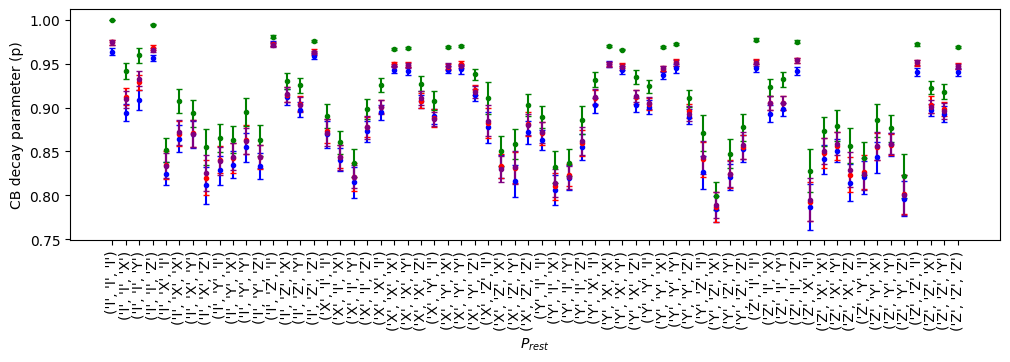

In [39]:
plt.figure(figsize=(12,3))
xlabels = []
for i, p in enumerate(cs_by_pauli.keys()):
    xlabels.append(p[1:])
    #construct the keys we'll plot at this xvalue
    plt.errorbar(i, eigs[(('Z',)+p[1:], False)], color='blue', marker='.', yerr=eigs_std[(('Z',)+p[1:], False)], capsize=2)
    plt.errorbar(i, eigs[(('Z',)+p[1:], True)], color='red', marker='.', yerr=eigs_std[(('Z',)+p[1:], True)], capsize=2)
    plt.errorbar(i, eigs[(('I',)+p[1:], False)], color='green', marker='.', yerr=eigs_std[(('I',)+p[1:], False)], capsize=2)
    plt.errorbar(i, eigs[(('I',)+p[1:], True)], color='purple', marker='.',yerr=eigs_std[(('I',)+p[1:], True)], capsize=2)
plt.xticks(range(len(xlabels)), xlabels, rotation=90)
plt.ylabel('CB decay parameter (p)')
plt.xlabel(r'''$P_{rest}$''')
#plt.savefig('ibm_osaka_05_19_all_values_single_plot_errorbars.pdf')
plt.show()

In [40]:
l2s = np.array(list(eigs[(('Z',)+p[1:], False)] for p in cs_by_pauli.keys()))
l1s = np.array(list(eigs[(('I',)+p[1:], False)] for p in cs_by_pauli.keys()))
l3s = np.array(list(eigs[(('Z',)+p[1:], True)] for p in cs_by_pauli.keys()))
l4s = np.array(list(eigs[(('I',)+p[1:], True)] for p in cs_by_pauli.keys()))

In [68]:
l2stds = np.array(list(eigs_std[(('Z',)+p[1:], False)] for p in cs_by_pauli.keys()))
l1stds = np.array(list(eigs_std[(('I',)+p[1:], False)] for p in cs_by_pauli.keys()))
l3stds = np.array(list(eigs_std[(('Z',)+p[1:], True)] for p in cs_by_pauli.keys()))
l4stds = np.array(list(eigs_std[(('I',)+p[1:], True)] for p in cs_by_pauli.keys()))

In [69]:
p1std = np.sqrt(np.sum(np.fromiter((m**2 for m in l1stds), dtype='float')))/4**3

In [70]:
p2std = np.sqrt(np.sum(np.fromiter((m**2 for m in l2stds), dtype='float')))/4**3

In [71]:
p3std = np.sqrt(np.sum(np.fromiter((m**2 for m in l3stds), dtype='float')))/4**3

In [73]:
p1s = w@l1s/4**3
p2s = w@l2s/4**3
p3s = w@l3s/4**3
p4s = w@l4s/4**3

In [75]:
p00 = (p1s+p2s+2*p3s)/4
p01 = (p1s-p2s)/2
p11 = (p1s+p2s-p3s-p4s)/4
yerr_all = np.sqrt(p1std**2+p2std**2+2*p3std**2)
yerr11 = np.sqrt(p1std**2+p2std**2)

In [126]:
all_values = list(p00)+list(p01)+list(p11)
all_errs = [yerr_all for _ in p00]+[yerr11 for _ in p00]+[yerr_all for _ in p00]
all_labels = ['(0,0), '+''.join(p[1:]) for p in cs_by_pauli.keys()]+['(0,1)/(1,0), '+''.join(p[1:]) for p in cs_by_pauli.keys()]+['(1,1), '+''.join(p[1:]) for p in cs_by_pauli.keys()]

In [128]:
value_label_tuples = zip(all_values, all_labels,all_errs)

In [129]:
sorted_rates = sorted(value_label_tuples, key=lambda x: x[0], reverse=True)

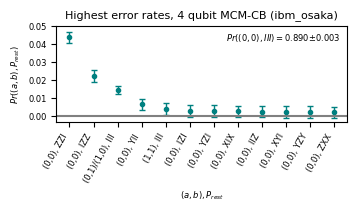

In [158]:
#try sorting by weight
plt.figure(figsize=(3.75,1.25))
xlabels = []
i = 0
for v,p,e in sorted_rates[1:13]:
    if not all([q == 'I' for q in p[1:]]):
        xlabels.append(p)
        #construct the keys we'll plot at this xvalue
        plt.errorbar(i, v, color='teal', marker='.', yerr=e, elinewidth=1, capsize=2)
        i += 1

plt.xticks(range(len(xlabels)), xlabels, rotation=60,size=6,ha='right')
plt.axhline(0, color='gray')
plt.yticks([0,0.01, 0.02, 0.03, 0.04,0.05])
plt.text(6.5,0.042, r'''$Pr((0,0),III)=${:.3f}$\pm${:.3f}'''.format(sorted_rates[0][0], sorted_rates[0][2]))
plt.ylabel(r'''$Pr((a,b),P_{rest})$''')
plt.xlabel(r'''$(a,b),P_{rest}$''')
plt.title('Highest error rates, 4 qubit MCM-CB (ibm_osaka)',size=8)
plt.savefig('ibm_osaka_05_19_summary.pdf')
plt.show()

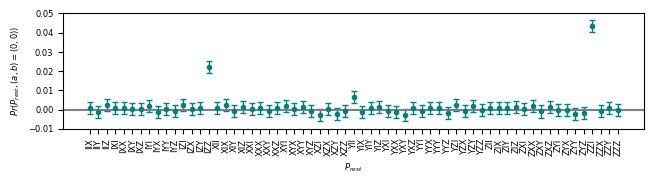

In [90]:
plt.figure(figsize=(7.5,1.5))
xlabels = []
i = 0
largest_values = []
smallest_values = []
eigs_sorted = []
eig_sum_errs = []
for p in cs_by_pauli.keys():
    if not all([q == 'I' for q in p[1:]]):
        xlabels.append(''.join(p[1:]))
        #construct the keys we'll plot at this xvalue
        plt.errorbar(i, p00[i+1], color='teal', marker='.', yerr=yerr_all, elinewidth=1, capsize=2)
        eigs_sorted.append(eig_sum)
        eig_sum_errs.append(eig_err)
        i += 1

plt.xticks(range(len(xlabels)), xlabels, rotation=90,size=6)
plt.axhline(0, color='gray')
plt.ylim(-0.01, 0.05)
plt.ylabel(r'''$Pr(P_{rest}, (a,b)=(0,0))$''')
plt.xlabel(r'''$P_{rest}$''')
plt.savefig('ibm_osaka_05_19_Pr00.pdf')
plt.show()

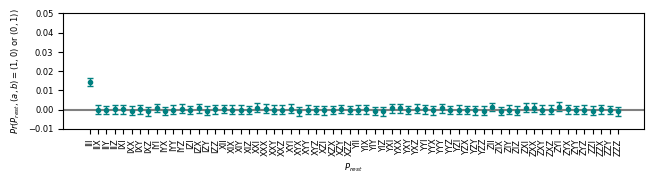

In [91]:
plt.figure(figsize=(7.5,1.5))
xlabels = []
i = 0
largest_values = []
smallest_values = []
eigs_sorted = []
eig_sum_errs = []
for p in cs_by_pauli.keys():
    if not all([q == 'I' for q in p]):
        xlabels.append(''.join(p[1:]))
        #construct the keys we'll plot at this xvalue
        plt.errorbar(i, p01[i], color='teal', marker='.', yerr=yerr11, elinewidth=1, capsize=2)
        eigs_sorted.append(eig_sum)
        eig_sum_errs.append(eig_err)
        i += 1

plt.xticks(range(len(xlabels)), xlabels, rotation=90)
plt.axhline(0, color='gray')
plt.ylabel(r'''$Pr(P_{rest}, (a,b)=(1,0)$ or $(0,1))$''')
plt.xlabel(r'''$P_{rest}$''')
plt.ylim(-0.01, 0.05)
plt.savefig('ibm_osaka_05_19_Pr10.pdf')
plt.show()

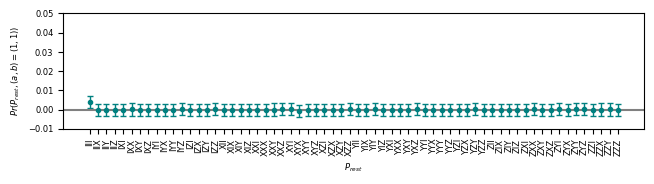

In [92]:
plt.figure(figsize=(7.5,1.5))
xlabels = []
i = 0
largest_values = []
smallest_values = []
eigs_sorted = []
eig_sum_errs = []
for p in cs_by_pauli.keys():
    if not all([q == 'I' for q in p]):
        xlabels.append(''.join(p[1:]))
        #construct the keys we'll plot at this xvalue
        plt.errorbar(i, p11[i], color='teal', marker='.', yerr=yerr_all, elinewidth=1, capsize=2)
        eigs_sorted.append(eig_sum)
        eig_sum_errs.append(eig_err)
        i += 1

plt.xticks(range(len(xlabels)), xlabels, rotation=90)
plt.axhline(0, color='gray')
plt.ylabel(r'''$Pr(P_{rest}, (a,b)=(1,1))$''')
plt.xlabel(r'''$P_{rest}$''')
plt.ylim(-0.01, 0.05)
plt.savefig('ibm_osaka_05_19_Pr11')
plt.show()